<a href="https://colab.research.google.com/github/yuriborg/time_series/blob/main/model_testing_previsao_geral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.5/193.5 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from darts.metrics import r2_score, mape, rmse
from darts import TimeSeries
from darts.models import AutoARIMA, ExponentialSmoothing, Croston, BATS
from darts.models import TBATS,  Prophet, FFT, KalmanForecaster
from darts.models import EnsembleModel, RegressionEnsembleModel
from darts.models import RNNModel, BlockRNNModel, NBEATSModel, NHiTSModel
from darts.models import TCNModel, TransformerModel, TFTModel, DLinearModel
from darts.models import NLinearModel, TiDEModel, FourTheta
from darts.models import EnsembleModel, RegressionEnsembleModel
from darts.models import LightGBMModel, XGBModel, LinearRegressionModel
from darts.models import EnsembleModel, RegressionEnsembleModel
from darts.models import RandomForest, RegressionModel, CatBoostModel
from darts.utils.statistics import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.models import NBEATSModel
from darts.utils.statistics import remove_seasonality,remove_trend,stationarity_test_adf
from darts.utils.statistics import extract_trend_and_seasonality, check_seasonality, stationarity_test_kpss
from darts.models import FFT, AutoARIMA, ExponentialSmoothing, Theta
from darts.metrics import mae
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import RandomForest, LightGBMModel, XGBModel, ARIMA, AutoARIMA
from darts.models import RNNModel, BlockRNNModel, NBEATSModel, TFTModel
from darts.models import NHiTSModel, TCNModel, TCNModel, TransformerModel
from darts.models import DLinearModel, NLinearModel, TiDEModel, VARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from darts.utils.utils import ModelMode, SeasonalityMode
from statsmodels.tsa.stattools import adfuller
plt.rcParams['figure.figsize'] = (15, 6)
%reload_ext autoreload

# Functions

In [ ]:
def extract_data(path='2012-today_copa_m04_demand_sencing_grouped.csv'):
  uploaded = files.upload()
  df = pd.read_csv(path)
  return df

In [ ]:
def monthly_freq(dataframe):
  dataframe['data'] = pd.to_datetime(dataframe['data'])

  dataframe = (dataframe.set_index('data')
          .reindex(pd.date_range(dataframe['data'].iloc[0],
                                dataframe['data'].iloc[-1],
                                freq='D'))
          .rename_axis(['data'])
          .fillna(0.0)
          .reset_index())

  dataframe['data'] = pd.to_datetime(dataframe['data']) - pd.to_timedelta(30, unit='d')
  dataframe = dataframe.groupby(pd.Grouper(key='data', freq='M'))['volume'].sum().reset_index().sort_values('data')

  dataframe.drop(dataframe.tail(1).index, inplace=True)

  return dataframe

In [ ]:
def weekly_freq(dataframe):
  dataframe['data'] = pd.to_datetime(dataframe['data'])

  dataframe = (dataframe.set_index('data')
          .reindex(pd.date_range(dataframe['data'].iloc[0],
                                dataframe['data'].iloc[-1],
                                freq='D'))
          .rename_axis(['data'])
          .fillna(0.0)
          .reset_index())

  dataframe['data'] = pd.to_datetime(dataframe['data']) - pd.to_timedelta(7, unit='d')
  dataframe = dataframe.groupby(pd.Grouper(key='data', freq='W-MON'))['volume'].sum().reset_index().sort_values('data')

  dataframe.drop(dataframe.tail(1).index, inplace=True)

  return dataframe

In [ ]:
def create_timeseries(dataframe):
  ts = TimeSeries.from_dataframe(dataframe,
                               time_col='data',
                               value_cols='volume')

  return ts

In [ ]:
def preprocess_timeseries(timeseries):

  print("Checking for seasonality")
  print(check_seasonality(timeseries))

  print("Removing seasonality ")
  if check_seasonality(timeseries)[0] == True:
    series1 = remove_seasonality(timeseries)
  if check_seasonality(timeseries)[0] != True:
    series1 = timeseries

  print("Searching for trend")
  print("Removing trend")
  series2 = remove_trend(series1)
  series2.plot()

  return series2

In [ ]:
def plot_model(val,
               plant_name,
               predictor,
               model_name):

  plt.figure(figsize=(25, 10), dpi=100)
  val.plot(label="Planta: {}".format(plant_name))
  predictor.plot(label="{}".format(model_name))
  plt.title("MAPE: {}, RMSE: {}, R2_Score: {}".format(mape(val, predictor),
                                                    rmse(val, predictor),
                                                    r2_score(val, predictor)))

In [ ]:
def train_test_split(time_series,
                     dataframe,
                     split_rate=0.85):
  train, test = time_series.split_before(pd.Timestamp(dataframe['data']
                                                         .loc[round(len(dataframe['data'])
                                                           * split_rate)]))

  return train, test

# Data Extraction

In [ ]:
df = extract_data()
df.head()

Saving 2012-today_copa_m04_demand_sencing_grouped.csv to 2012-today_copa_m04_demand_sencing_grouped.csv


planta_cliente        data  volume
0         AGUDOS  2014-01-02   69.18
1         AGUDOS  2014-01-03   97.06
2         AGUDOS  2014-01-05  172.83
3         AGUDOS  2014-01-13   31.54
4         AGUDOS  2014-01-14   99.69

# Data Preparing

In [ ]:
df_m = df.groupby(['data'])['volume'].sum()
df_m = pd.DataFrame(df_m)
df_m.reset_index(inplace=True)
df_m = monthly_freq(df_m)
df_m.drop(df_m.tail(1).index, inplace=True)
df_m

data    volume
0   2013-12-31  24622.68
1   2014-01-31  27325.03
2   2014-02-28  21641.27
3   2014-03-31  24355.89
4   2014-04-30  21844.40
..         ...       ...
114 2023-06-30  24514.06
115 2023-07-31  26778.49
116 2023-08-31  28797.04
117 2023-09-30  29694.07
118 2023-10-31  30656.82

[119 rows x 2 columns]

In [ ]:
df_w = df.groupby(['data'])['volume'].sum()
df_w = pd.DataFrame(df_w)
df_w.reset_index(inplace=True)
df_w = weekly_freq(df_w)
df_w.drop(df_w.tail(1).index, inplace=True)
df_w

data   volume
0   2013-12-30  3971.39
1   2014-01-06  6129.48
2   2014-01-13  5951.20
3   2014-01-20  6326.93
4   2014-01-27  4706.75
..         ...      ...
515 2023-11-13  7031.02
516 2023-11-20  7083.57
517 2023-11-27  5638.73
518 2023-12-04  7010.98
519 2023-12-11  8407.98

[520 rows x 2 columns]

In [ ]:
ts_m = create_timeseries(df_m)
ts_w = create_timeseries(df_w)

In [ ]:
trend_w, seasonality_w = extract_trend_and_seasonality(ts_w,
                                                       model=ModelMode.ADDITIVE)
trend_m, seasonality_m = extract_trend_and_seasonality(ts_m,
                                                       model=ModelMode.ADDITIVE)

<Axes: xlabel='data'>

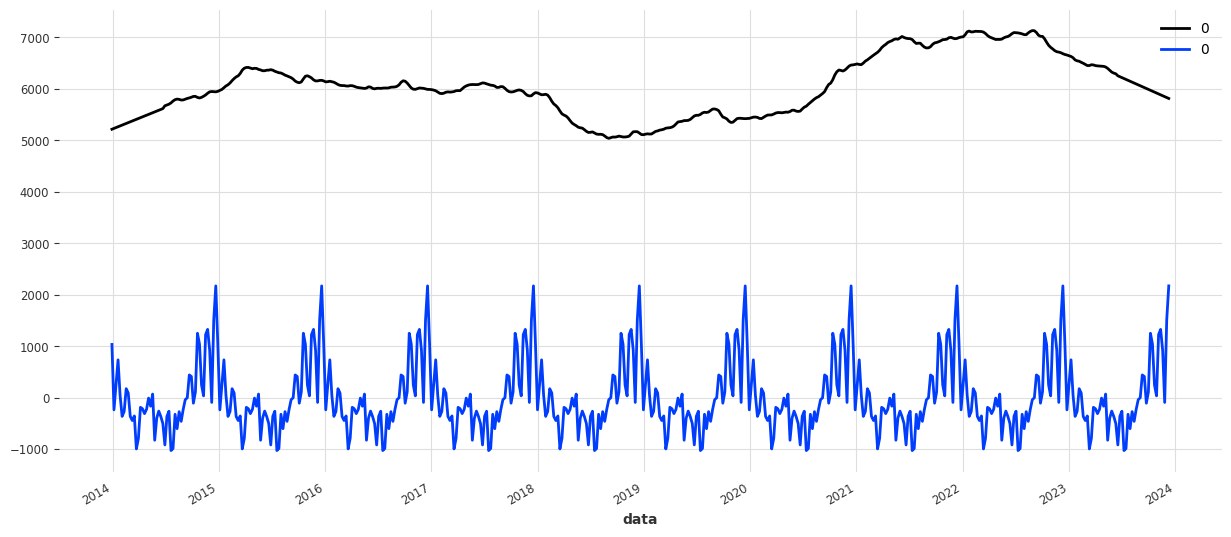

In [ ]:
trend_w.plot()
seasonality_w.plot()

<Axes: xlabel='data'>

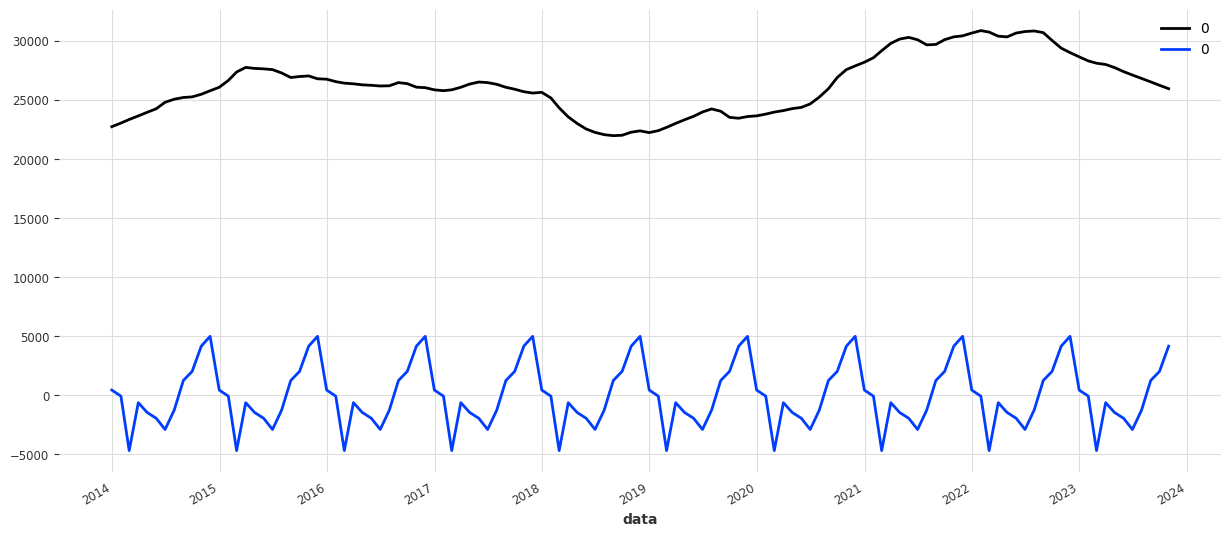

In [ ]:
trend_m.plot()
seasonality_m.plot()

In [ ]:
# ts_m = preprocess_timeseries(ts_m)
# ts_w = preprocess_timeseries(ts_w)
train_m, test_m = train_test_split(ts_m, df_m)
train_w, test_w = train_test_split(ts_w, df_w)

# Autocorrelation(ACF) and Partial AutoCorrelation (PACF)

<Axes: xlabel='data'>

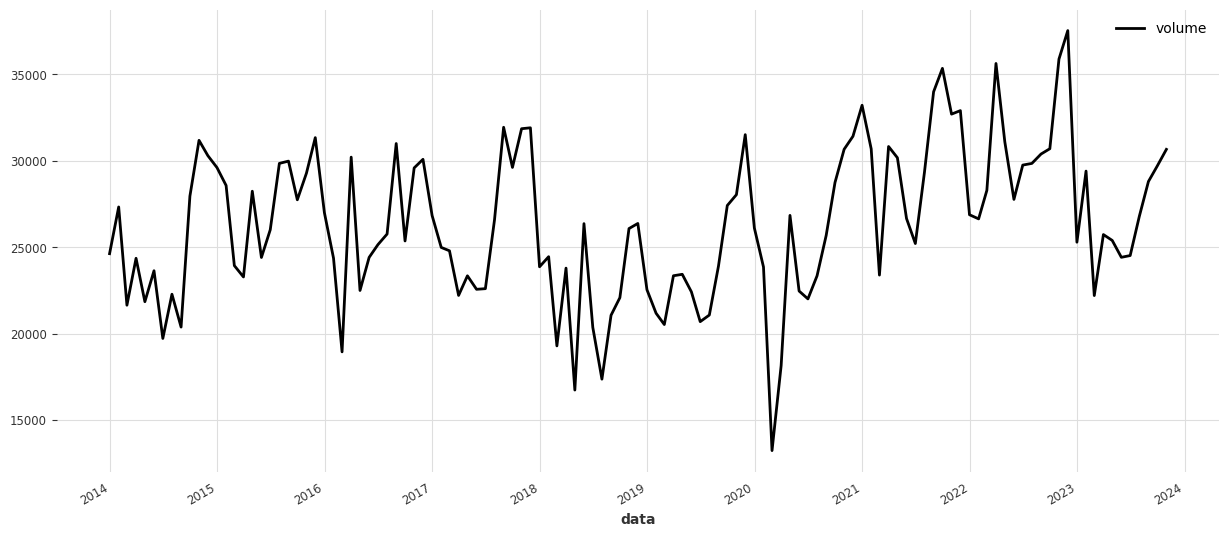

In [ ]:
ts_m.plot()

<Axes: xlabel='data'>

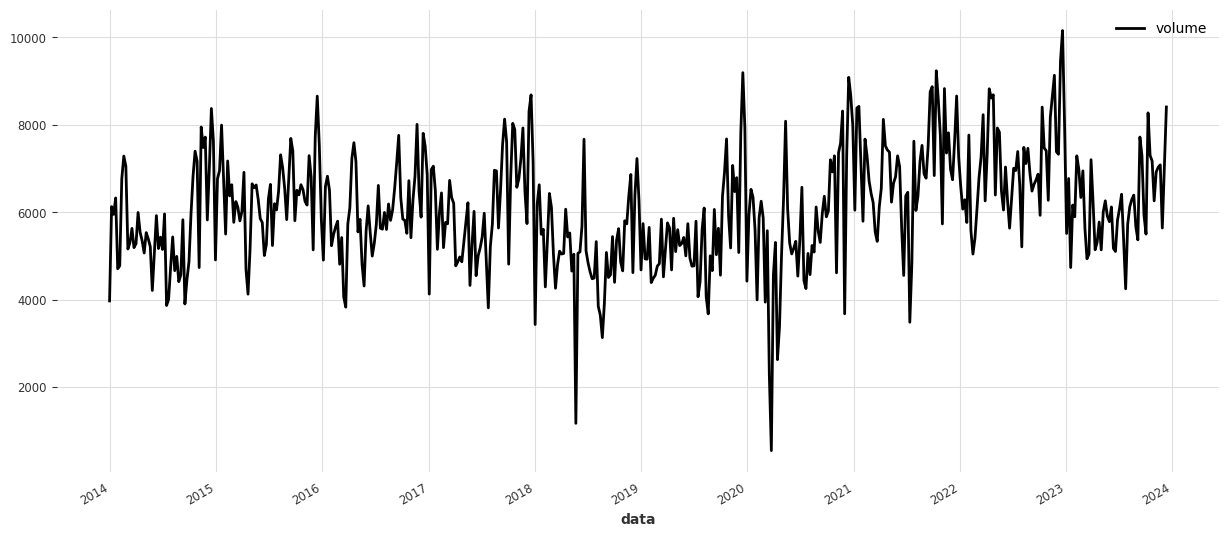

In [ ]:
ts_w.plot()

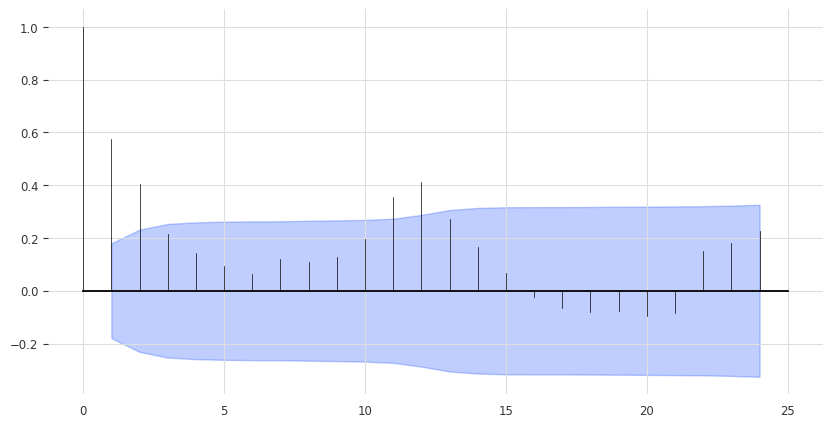

In [ ]:
plot_acf(ts_m)

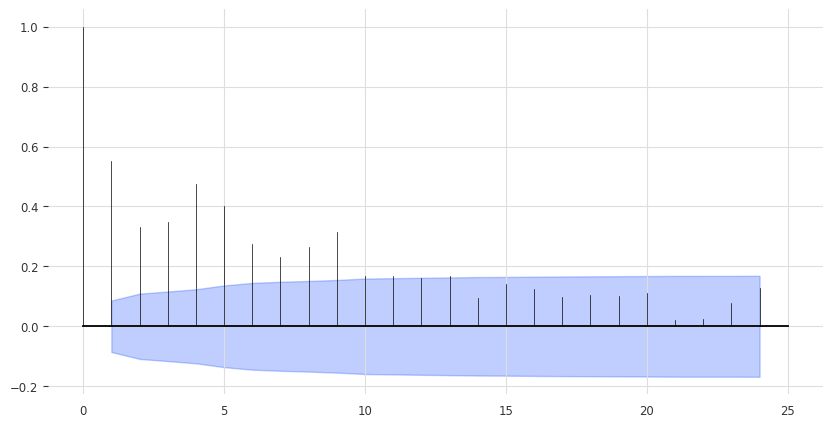

In [ ]:
plot_acf(ts_w)

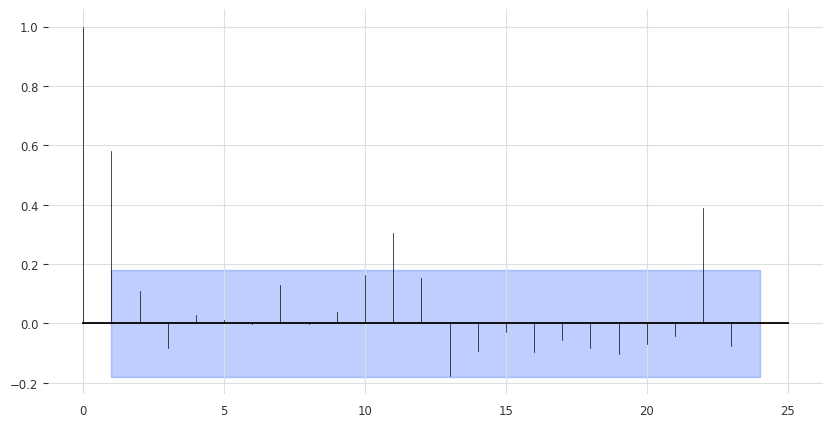

In [ ]:
plot_pacf(ts_m)

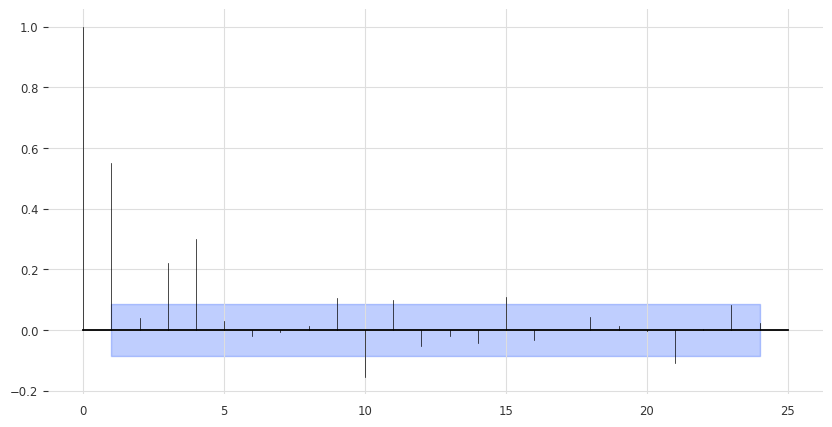

In [ ]:
plot_pacf(ts_w)

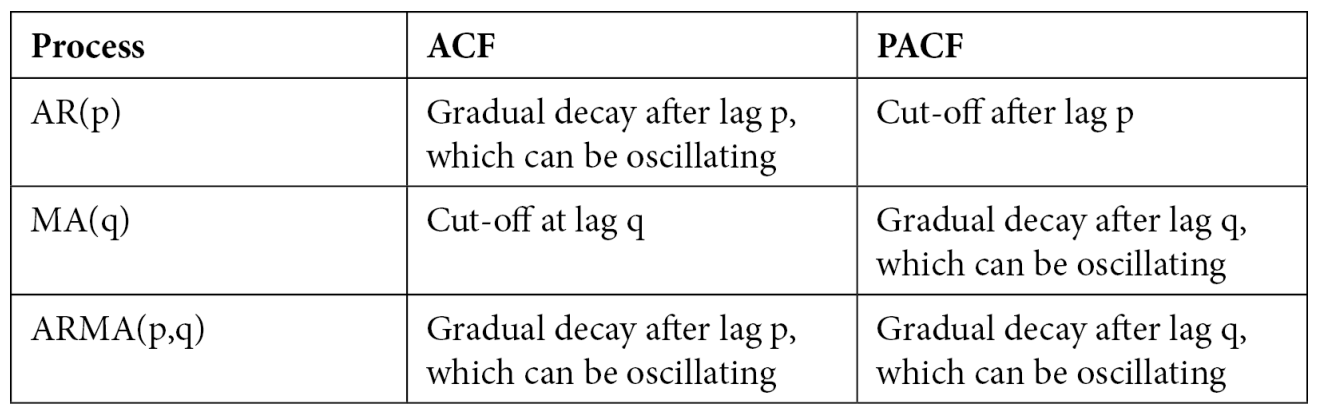

# Models

## Statistical

### ARIMA

In [ ]:
model_arima_m = ARIMA(p=5, d=2, q=10)
model_arima_w = ARIMA(p=1, d=2, q=1)

pred_arima_m = model_arima_m.fit(train_m).predict(len(test_m))
pred_arima_w = model_arima_w.fit(train_w).predict(len(test_w))

In [ ]:
# parameters_arima={
#     'p': [1,2,3,4,5,6,7,8,9,10],
#     'd': [1,2,3],
#     'q': [1,2,3,4,5]}

# model_arima_m.gridsearch(
#     parameters=parameters_arima,
#     series=train_m,
#     forecast_horizon=6)

# model_arima_w.gridsearch(
#     parameters=parameters_arima,
#     series=train_w,
#     forecast_horizon=6)

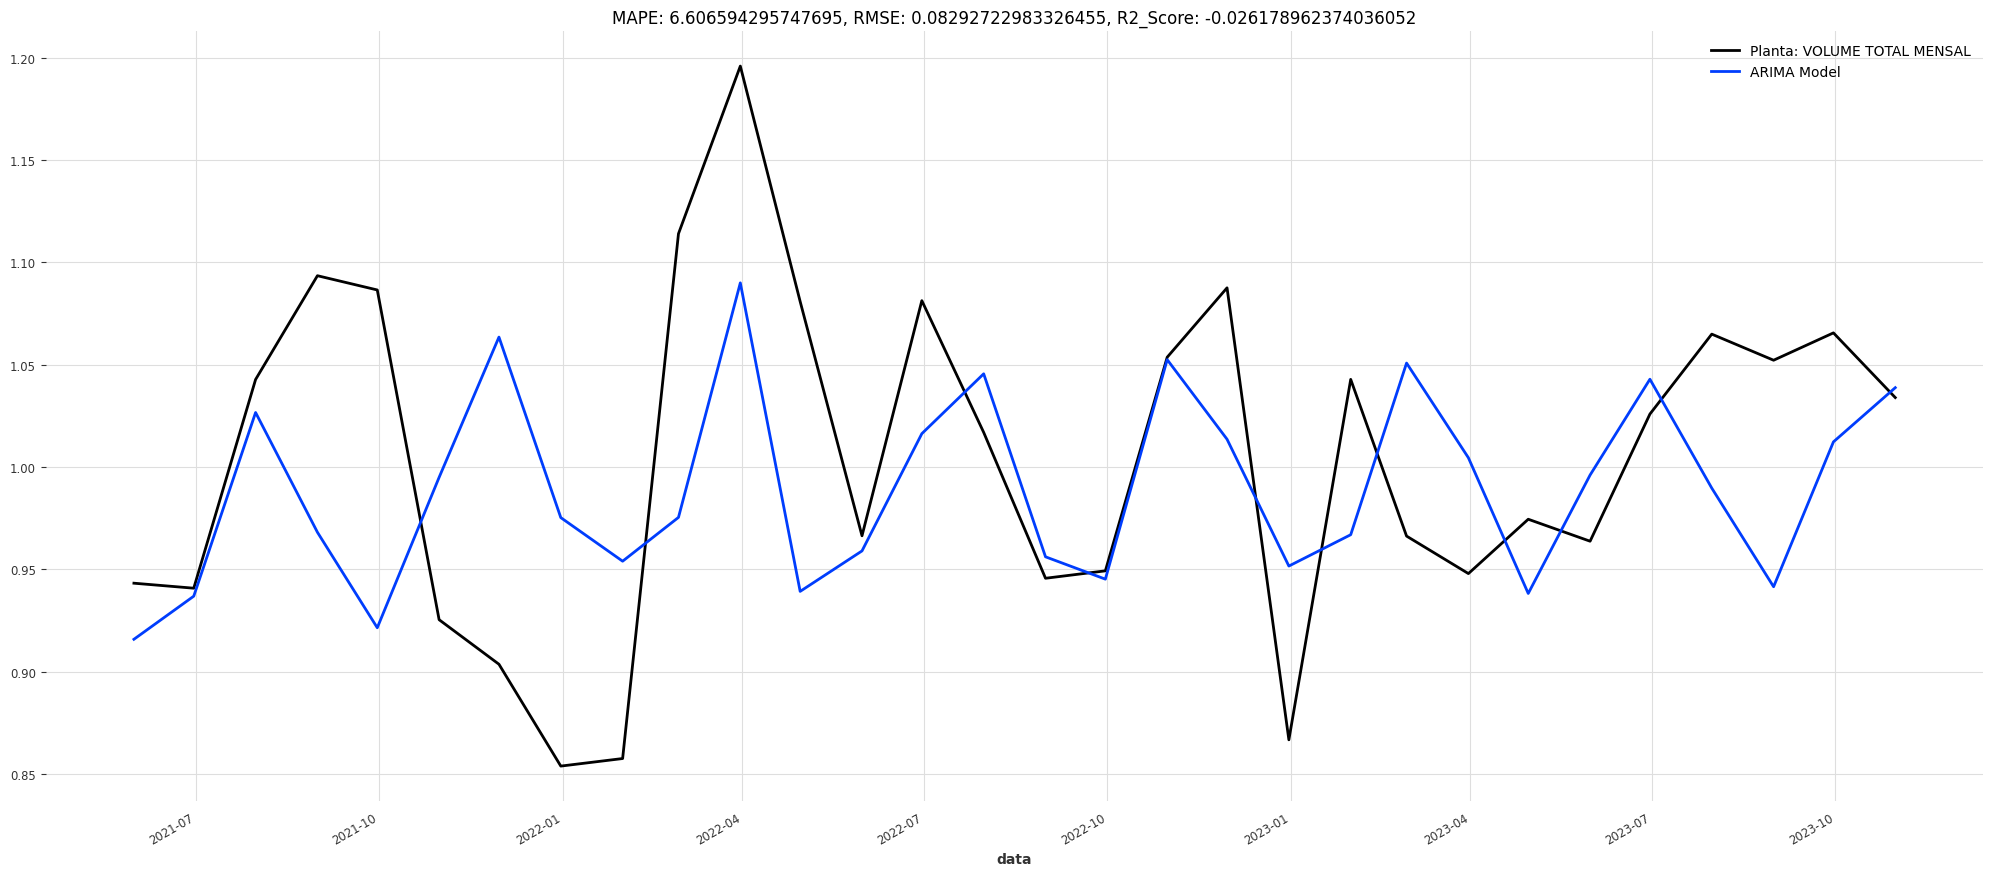

In [ ]:
plot_model(test_m,
           'VOLUME TOTAL MENSAL',
           pred_arima_m,
           'ARIMA Model')

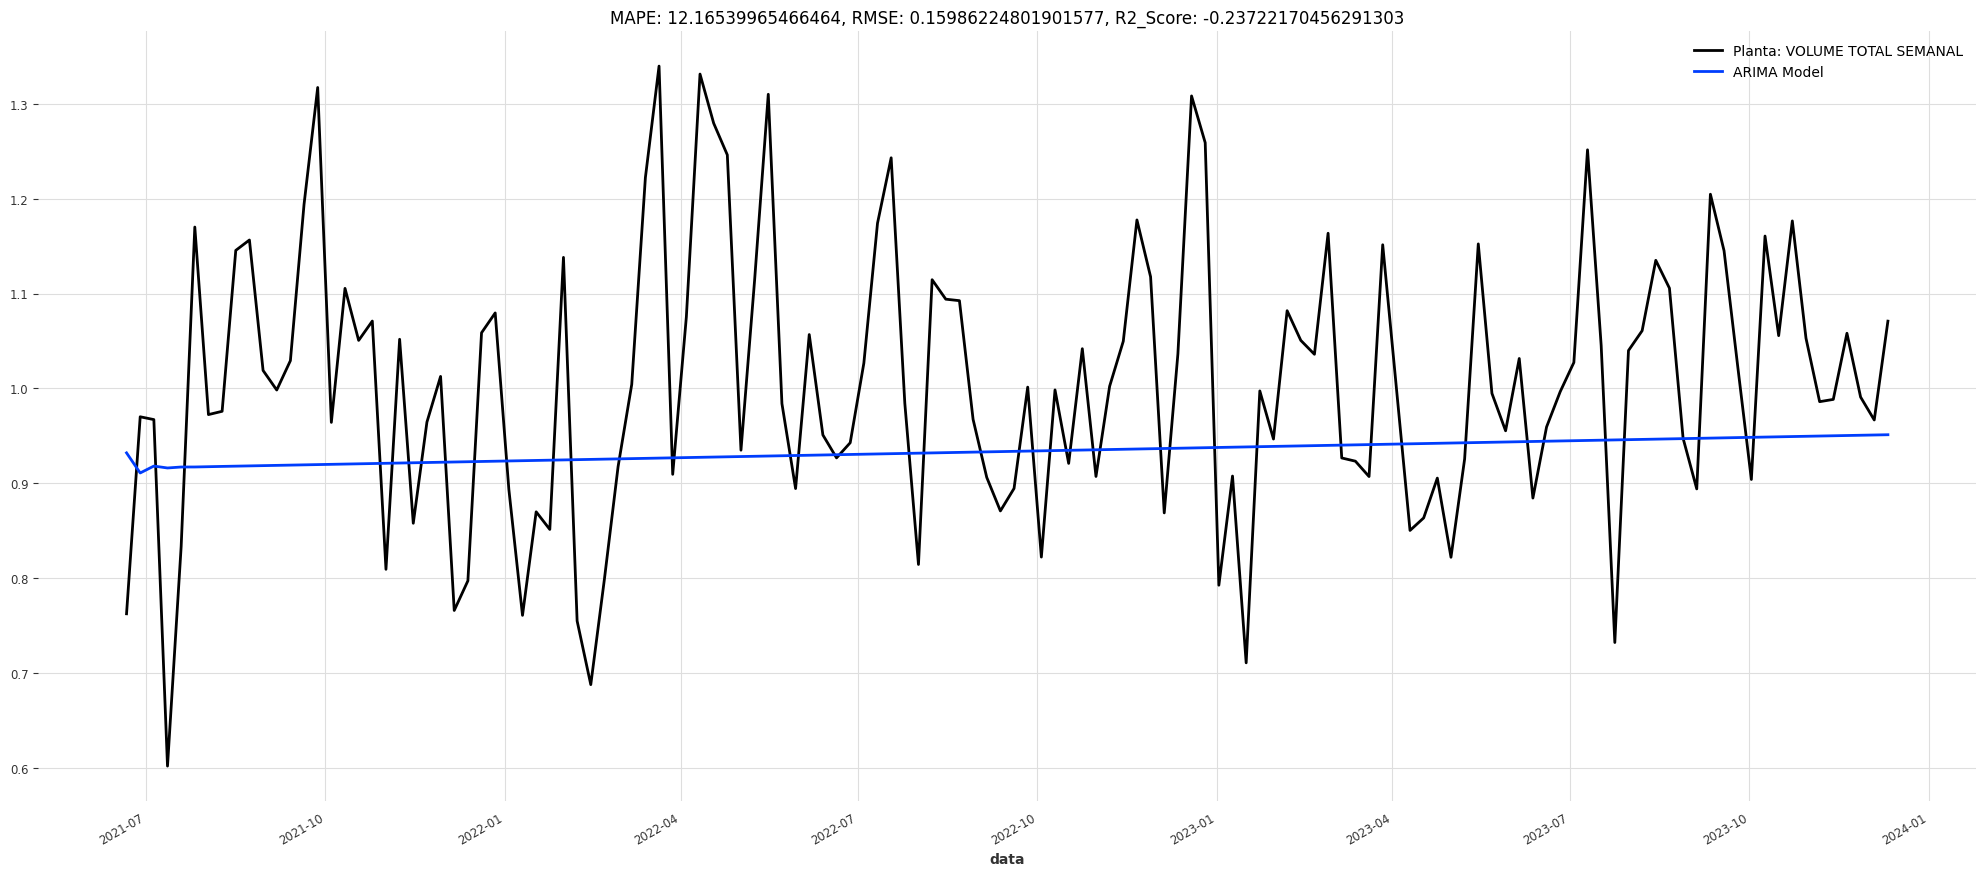

In [ ]:
plot_model(test_w,
           'VOLUME TOTAL SEMANAL',
           pred_arima_w,
           'ARIMA Model')

### Exponential Smoothing

In [ ]:
model_es_m = ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE,
                                  seasonal=SeasonalityMode.ADDITIVE,
                                  seasonal_periods = 12)

model_es_w = ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE,
                                  seasonal=SeasonalityMode.ADDITIVE,
                                  seasonal_periods=48)

pred_es_m = model_es_m.fit(train_m).predict(len(test_m))
pred_es_w = model_es_w.fit(train_w).predict(len(test_w))

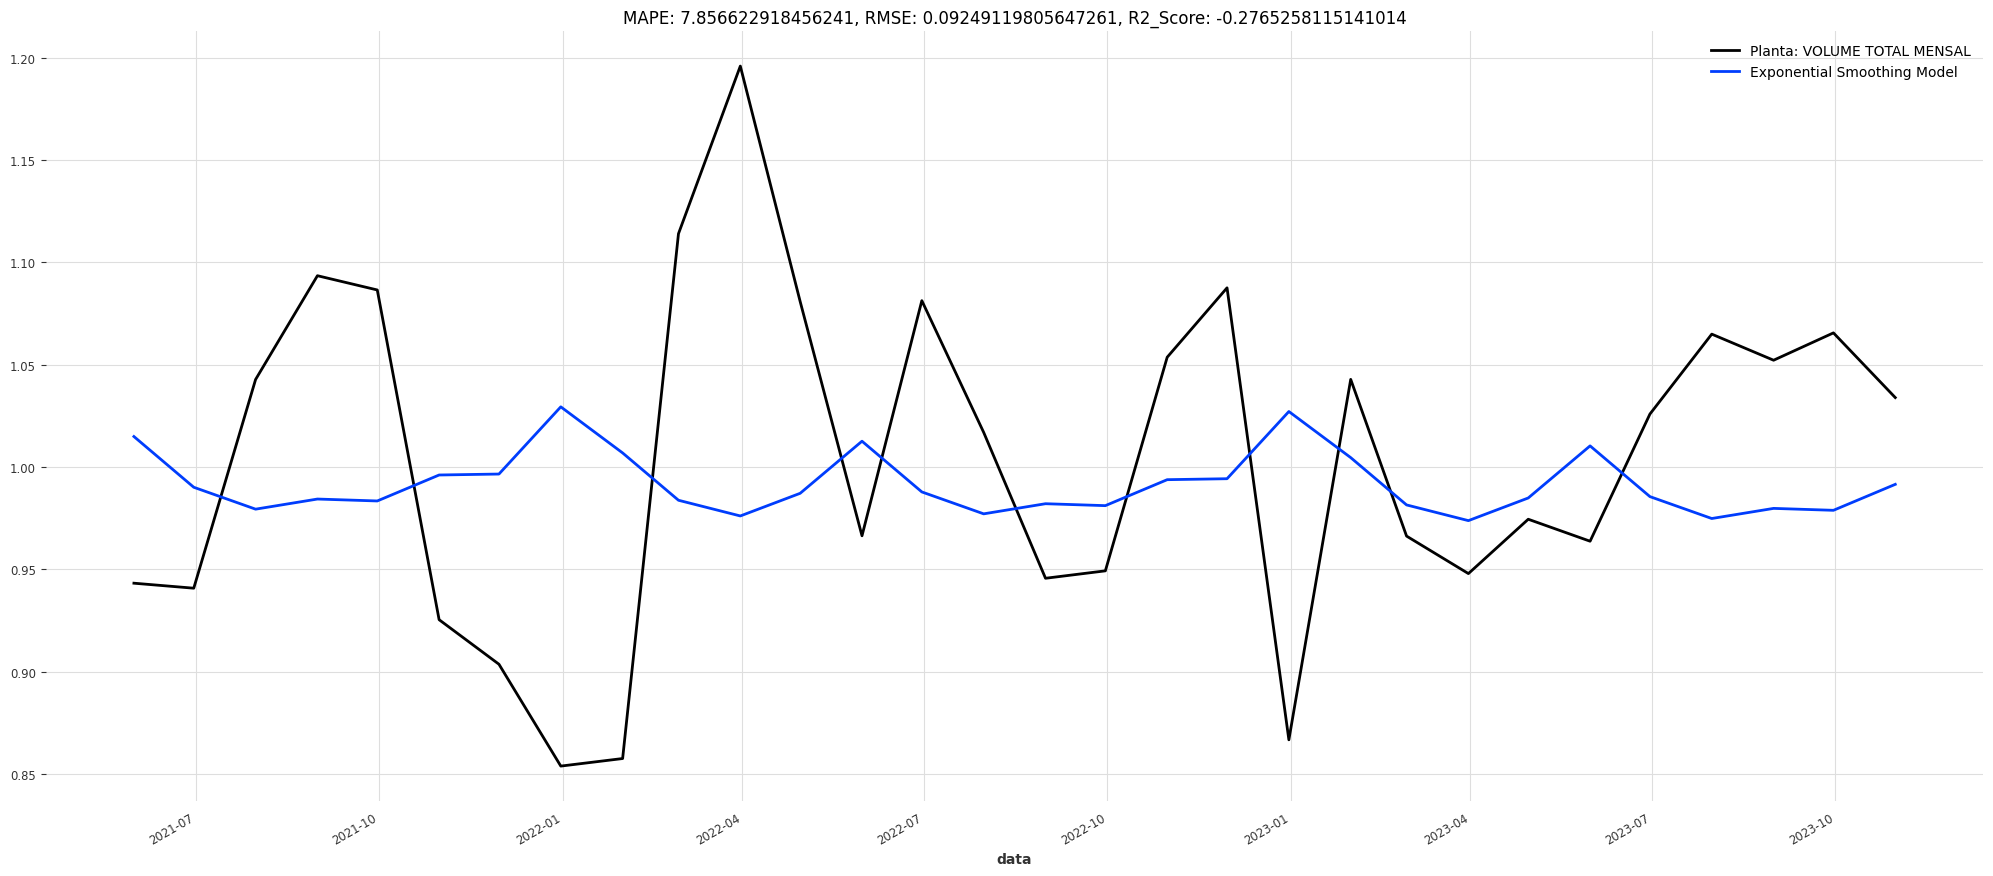

In [ ]:
plot_model(test_m,
           'VOLUME TOTAL MENSAL',
           pred_es_m,
           'Exponential Smoothing Model')

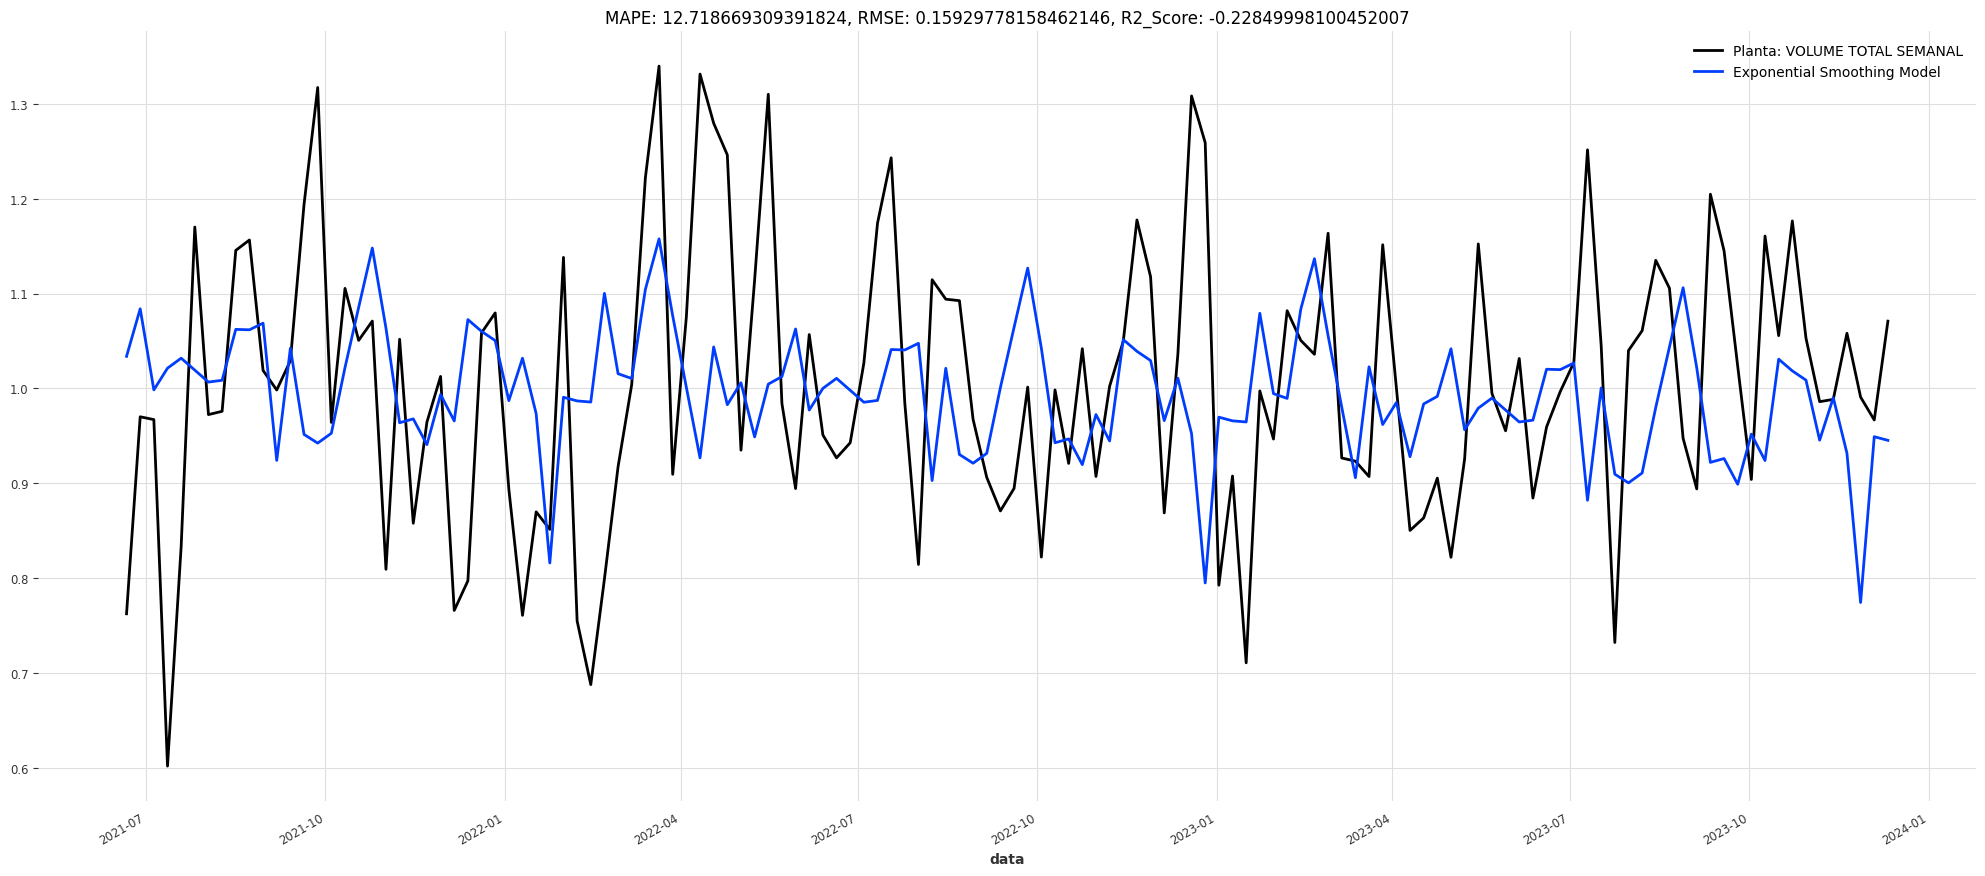

In [ ]:
plot_model(test_w,
           'VOLUME TOTAL SEMANAL',
           pred_es_w,
           'Exponential Smoothing Model')

### BATS and TBATS

In [ ]:
model_bats_m = BATS(use_trend=True,
                    seasonal_periods='freq',
                    random_state=1)
model_bats_w = BATS(use_trend=True,
                    seasonal_periods='freq',
                    random_state=1)

pred_bats_m = model_bats_m.fit(train_m).predict(len(test_m))
pred_bats_w = model_bats_w.fit(train_w).predict(len(test_w))

In [ ]:
# parameters_bats={
#     'use_box_cox': [True,False],
#     'box_cox_bounds': [(0, 1),(0, 2),(0, 3)],
#     'use_trend': [True,False],
#     'use_damped_trend': [True,False],
#     'seasonal_periods': [None, 'freq'],
#     'use_arma_errors': [True,False],
#     'n_jobs': [1,2,3,4,5],
#     'multiprocessing_start_method': ['spawn','forkserver','fork']}


# model_bats_m.gridsearch(
#     parameters=parameters_bats,
#     series=train_m,
#     forecast_horizon=6)

# model_bats_w.gridsearch(
#     parameters=parameters_bats,
#     series=train_w,
#     forecast_horizon=24)

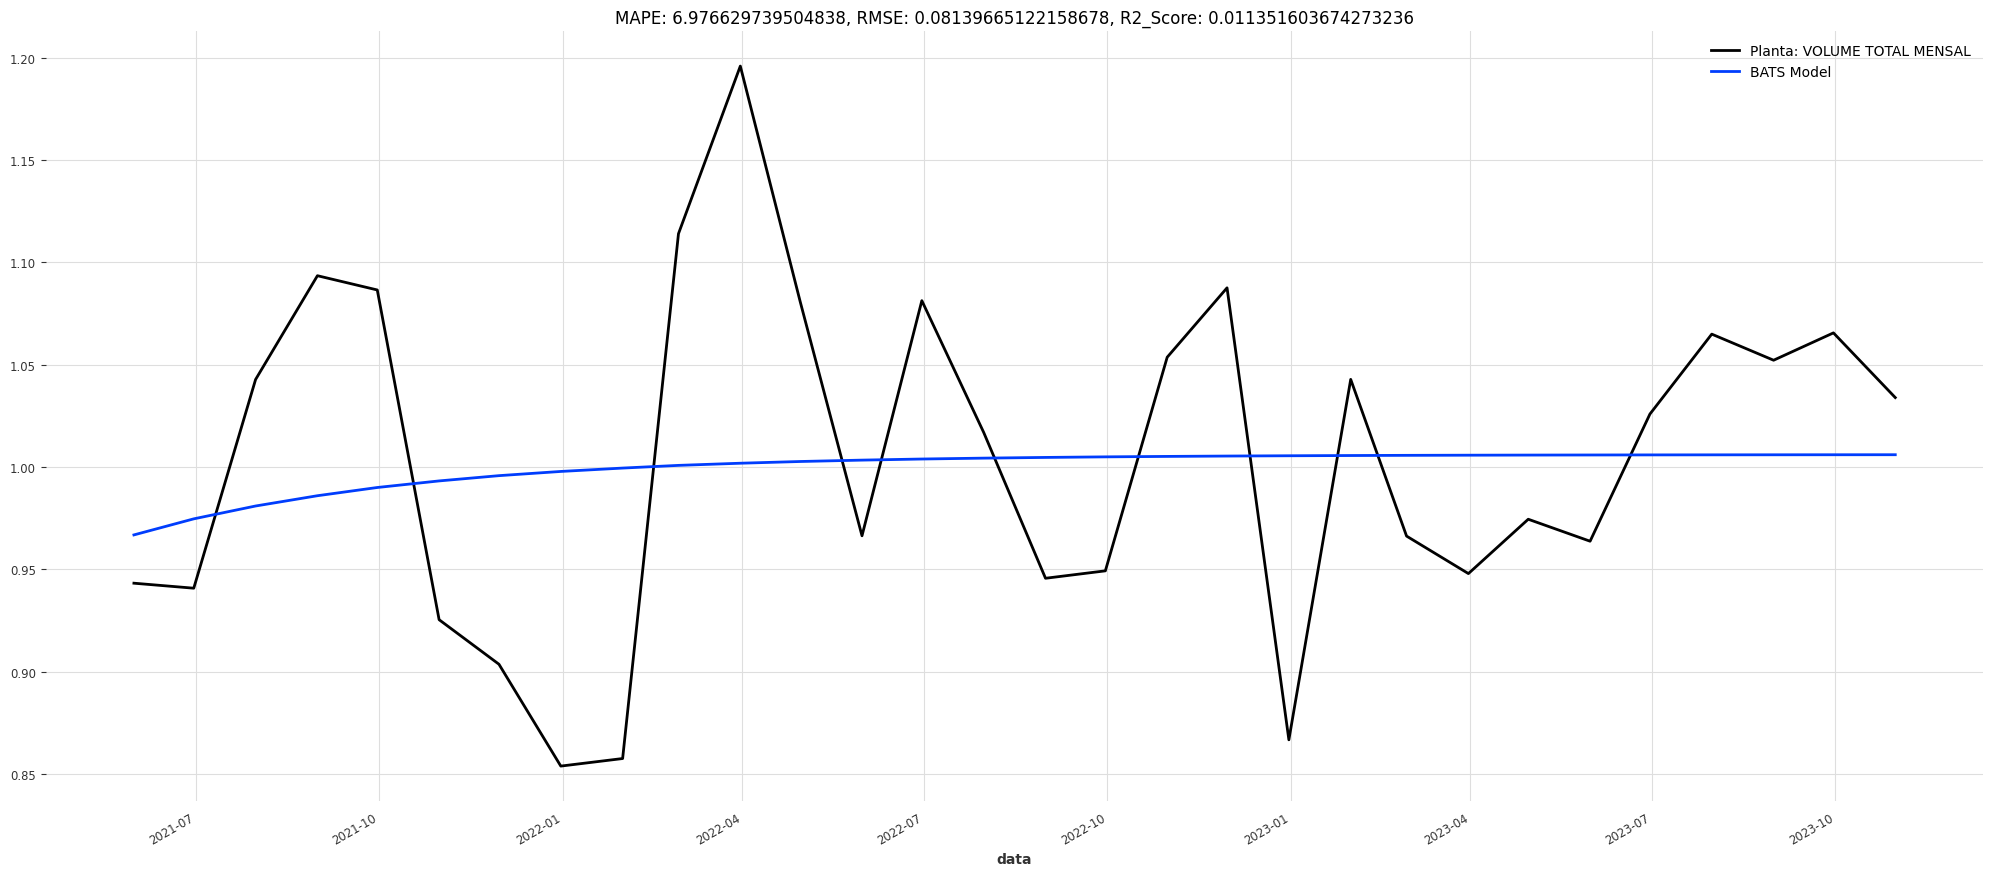

In [ ]:
plot_model(test_m,
           'VOLUME TOTAL MENSAL',
           pred_bats_m,
           'BATS Model')

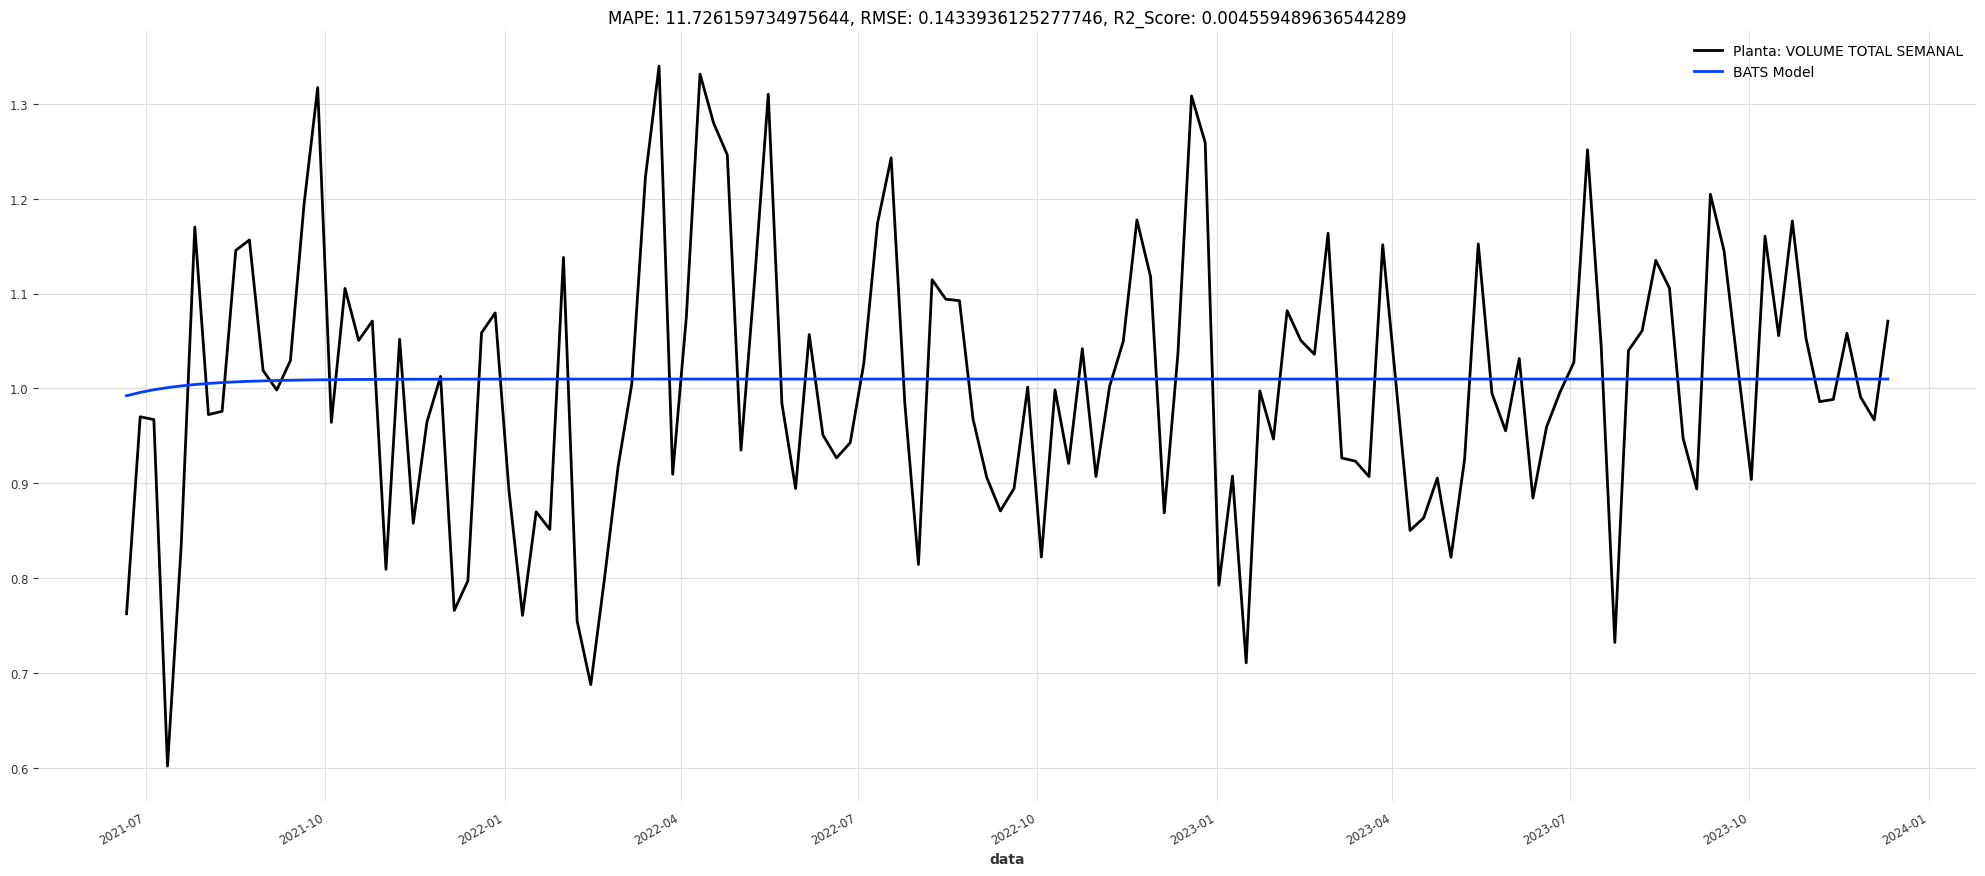

In [ ]:
plot_model(test_w,
           'VOLUME TOTAL SEMANAL',
           pred_bats_w,
           'BATS Model')

In [ ]:
model_tbats_m = TBATS(use_trend=True,
                    seasonal_periods='freq',
                    random_state=1)
model_tbats_w = TBATS(use_trend=True,
                    seasonal_periods='freq',
                    random_state=1)

pred_tbats_m = model_tbats_m.fit(train_m).predict(len(test_m))
pred_tbats_w = model_tbats_w.fit(train_w).predict(len(test_w))

In [ ]:
# parameters_tbats={
#     'use_box_cox': [True,False],
#     'box_cox_bounds': [(0, 1),(0, 2),(0, 3)],
#     'use_trend': [True,False],
#     'use_damped_trend': [True, False],
#     'seasonal_periods': [None,'freq'],
#     'use_arma_errors': [True,False],
#     'n_jobs': [1,2,3,4,5],
#     'multiprocessing_start_method': ['spawn','forkserver','fork']}

# model_tbats_m.gridsearch(
#     parameters=parameters_tbats,
#     series=train_m,
#     forecast_horizon=6)

# model_tbats_w.gridsearch(
#     parameters=parameters_tbats,
#     series=train_w,
#     forecast_horizon=24)

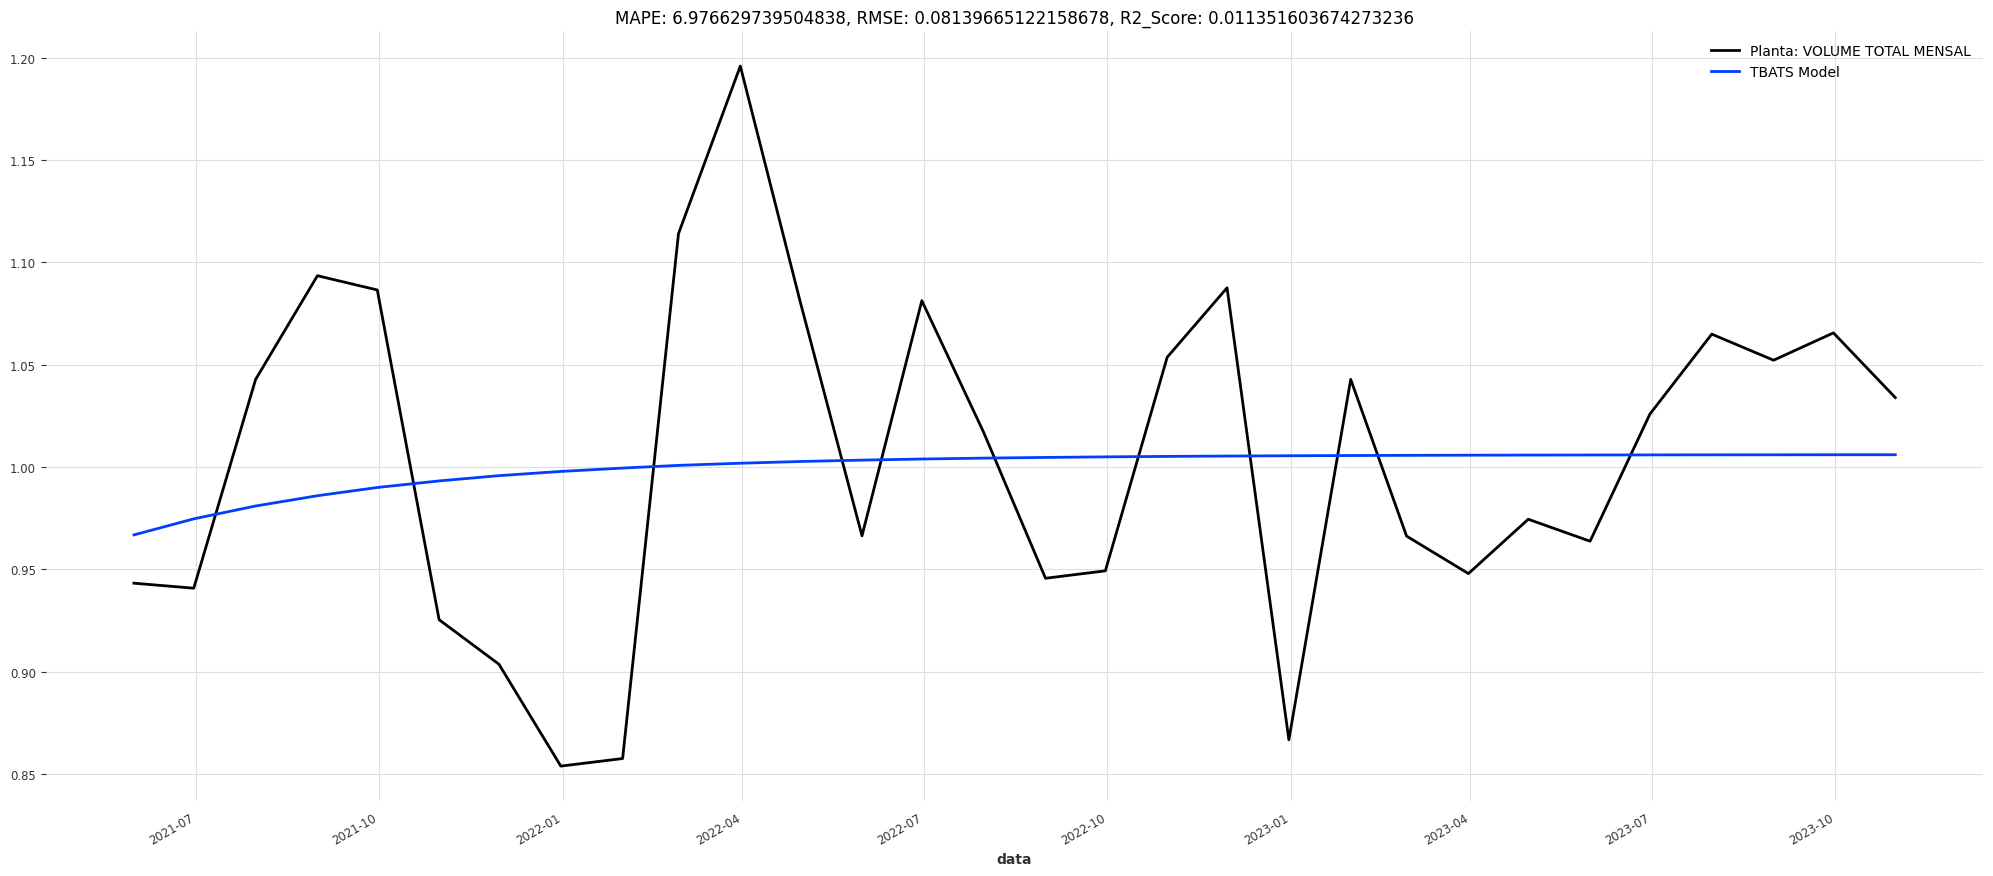

In [ ]:
plot_model(test_m,
           'VOLUME TOTAL MENSAL',
           pred_tbats_m,
           'TBATS Model')

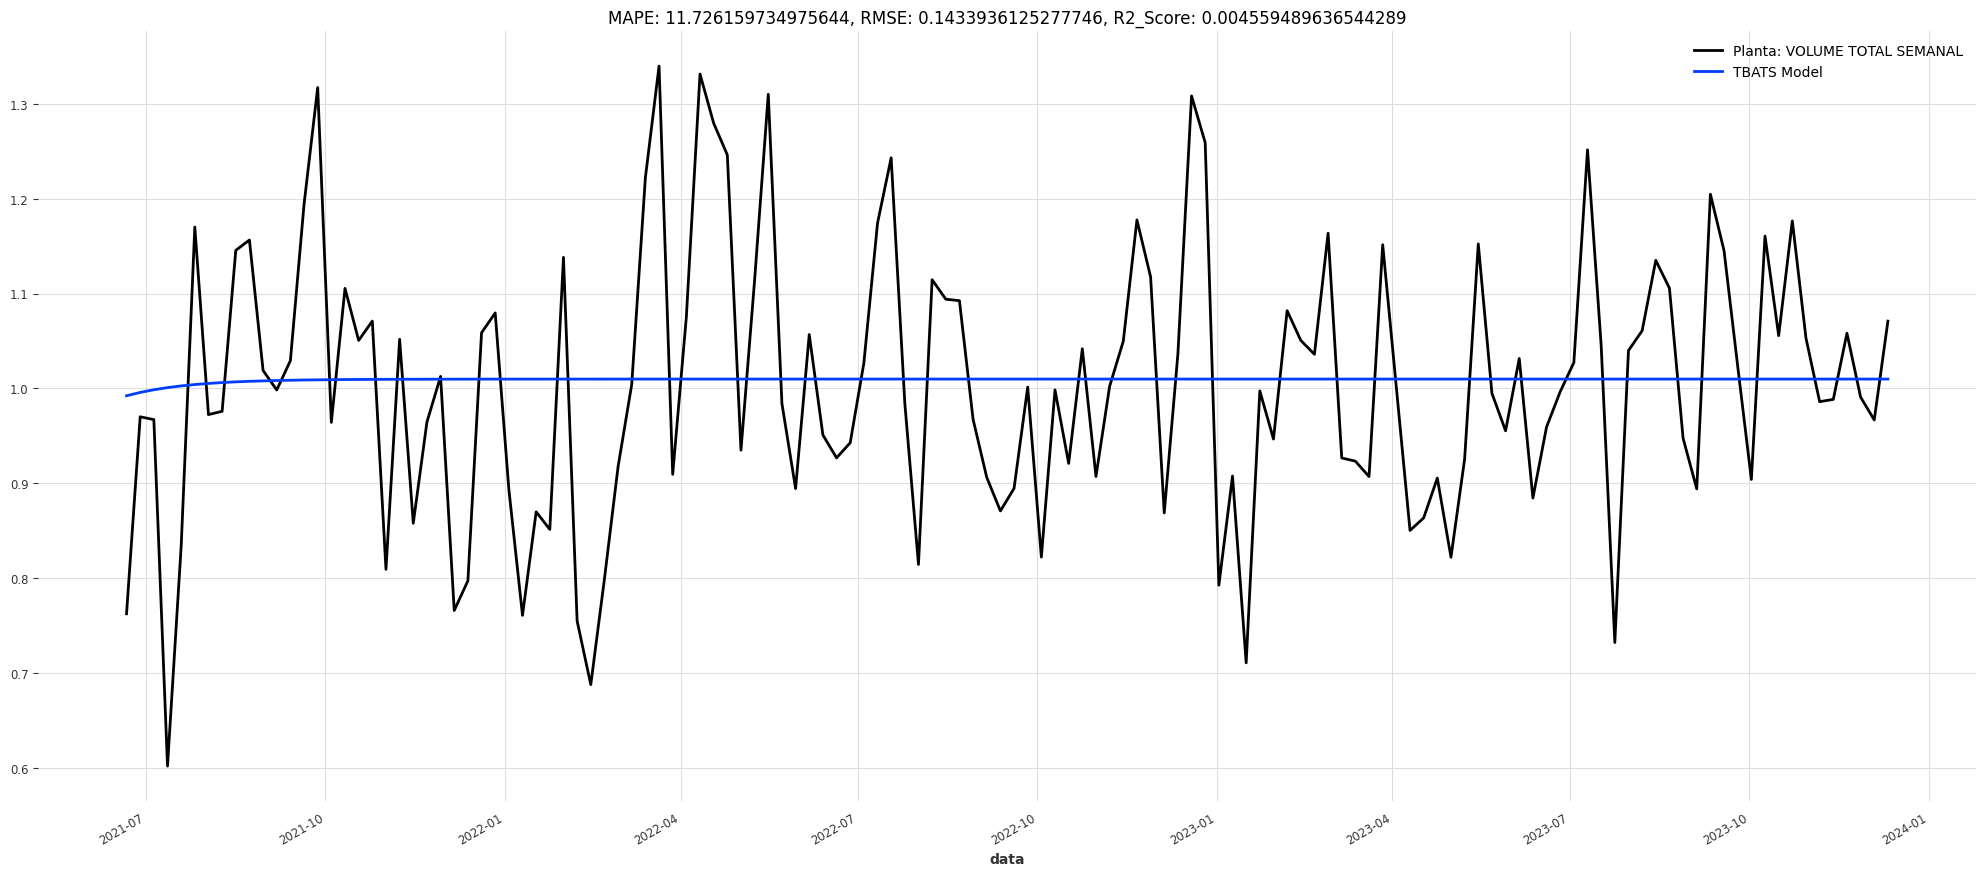

In [ ]:
plot_model(test_w,
           'VOLUME TOTAL SEMANAL',
           pred_tbats_w,
           'TBATS Model')

### Theta and FourTheta

In [ ]:
model_theta_m = Theta(seasonality_period=15,
                      season_mode=SeasonalityMode.ADDITIVE)
model_theta_w = Theta(seasonality_period=10,
                      season_mode=SeasonalityMode.ADDITIVE)

pred_theta_m = model_theta_m.fit(train_m).predict(len(test_m))
pred_theta_w = model_theta_w.fit(train_w).predict(len(test_w))

In [ ]:
# parameters_theta={
#     'theta': [1,2,3],
#     'seasonality_period': [None, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72]}


# model_theta_m.gridsearch(
#     parameters=parameters_theta,
#     series=train_m,
#     forecast_horizon=6)

# model_theta_w.gridsearch(
#     parameters=parameters_theta,
#     series=train_w,
#     forecast_horizon=24)

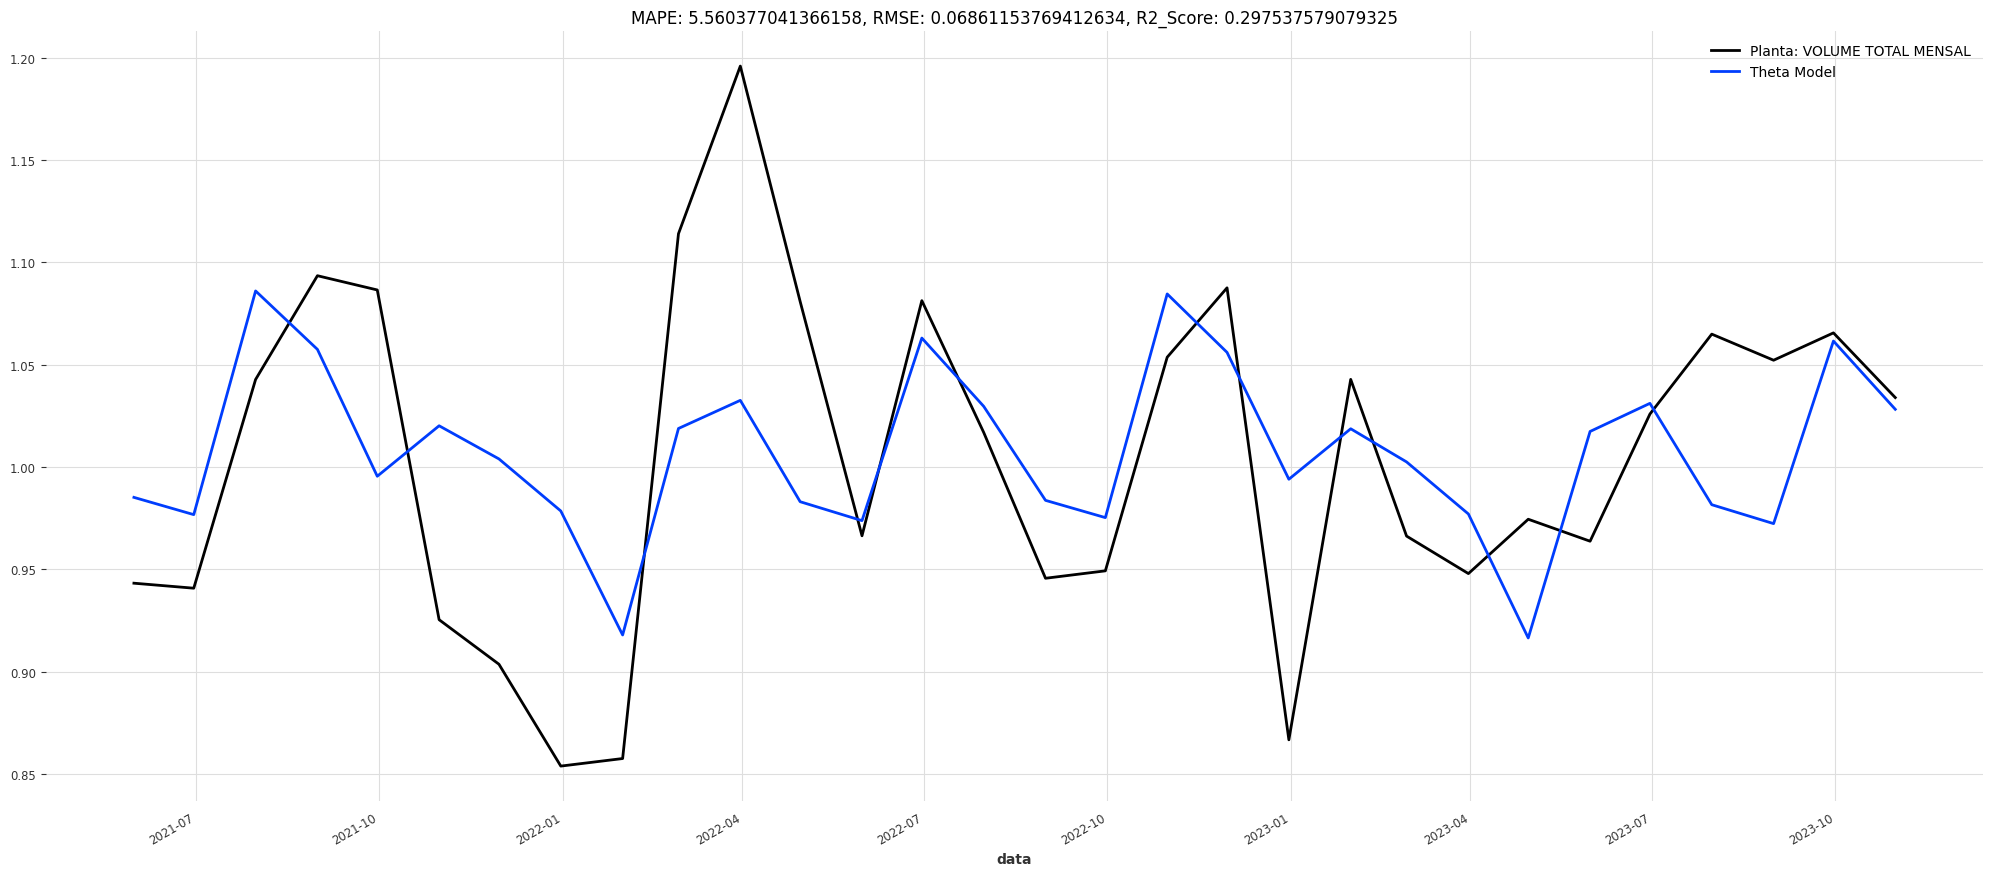

In [ ]:
plot_model(test_m,
           'VOLUME TOTAL MENSAL',
           pred_theta_m,
           'Theta Model')

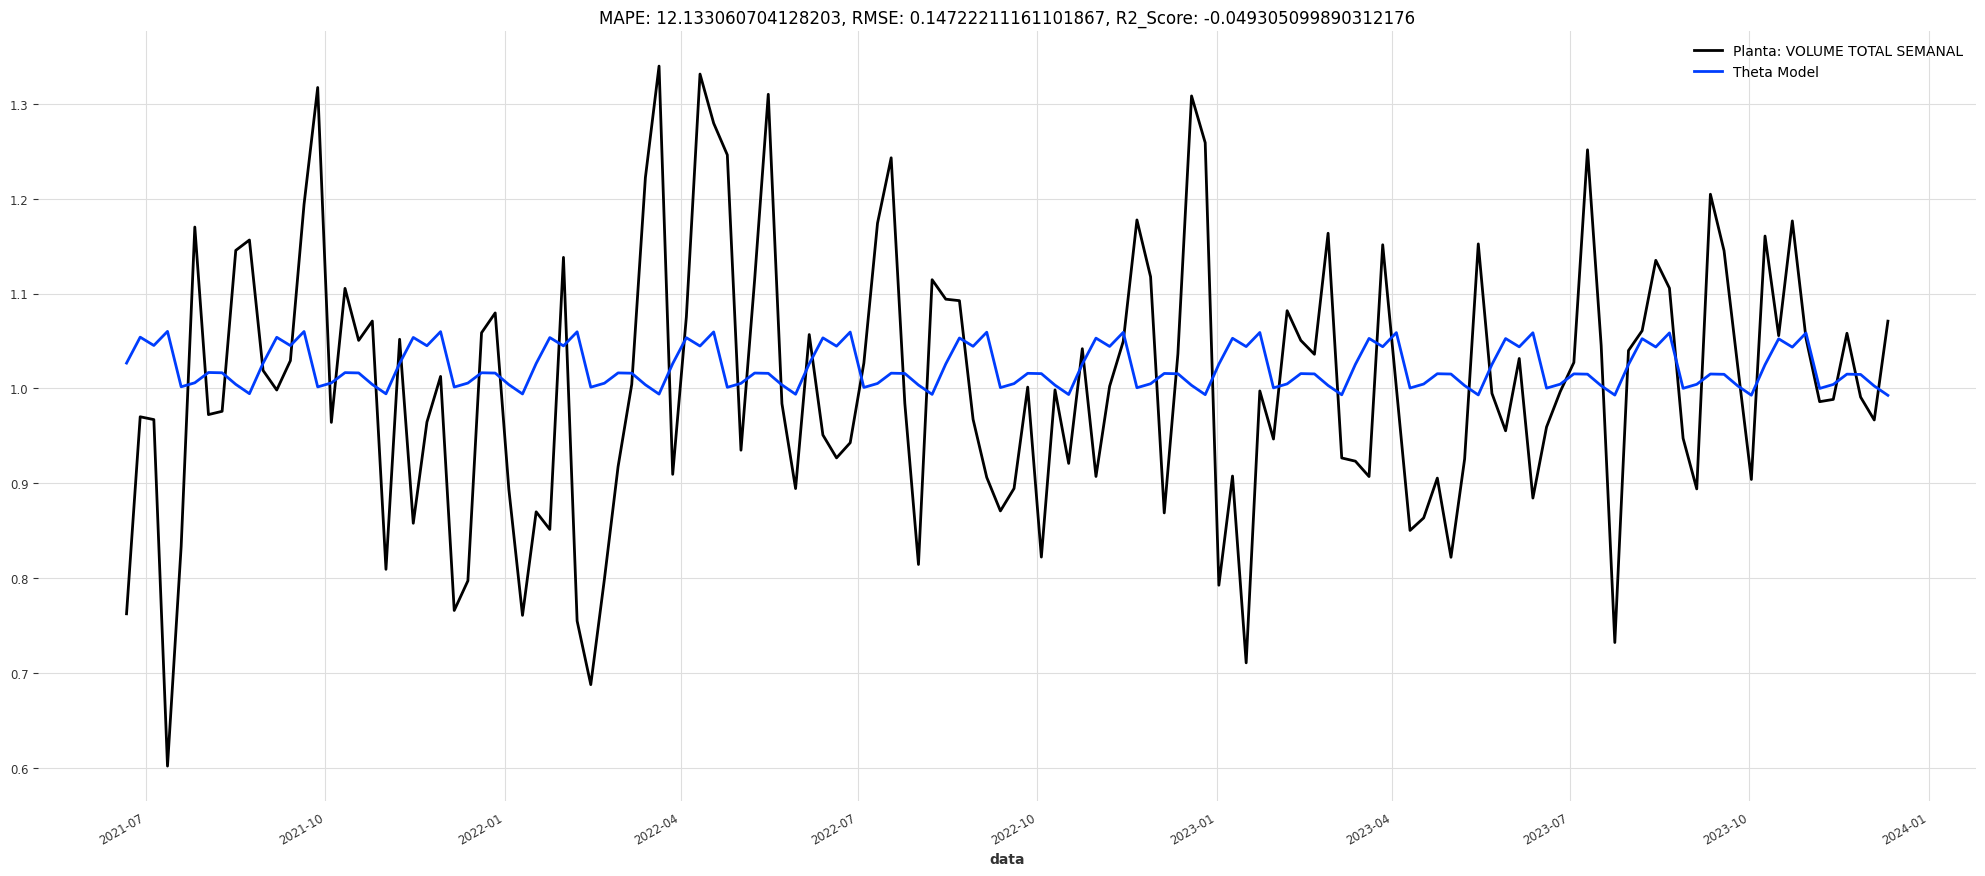

In [ ]:
plot_model(test_w,
           'VOLUME TOTAL SEMANAL',
           pred_theta_w,
           'Theta Model')

In [ ]:
model_fourtheta_m = FourTheta(seasonality_period=15,
                              season_mode=SeasonalityMode.ADDITIVE)
model_fourtheta_w = FourTheta(seasonality_period=10,
                              season_mode=SeasonalityMode.ADDITIVE)

pred_fourtheta_m = model_fourtheta_m.fit(train_m).predict(len(test_m))
pred_fourtheta_w = model_fourtheta_w.fit(train_w).predict(len(test_w))

In [ ]:
# parameters_fourtheta={
#     'theta': [0,1,2,3,4],
#     'seasonality_period': [None, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72]}


# model_fourtheta_m.gridsearch(
#     parameters=parameters_fourtheta,
#     series=train_m,
#     forecast_horizon=6)

# model_fourtheta_w.gridsearch(
#     parameters=parameters_fourtheta,
#     series=train_w,
#     forecast_horizon=24)

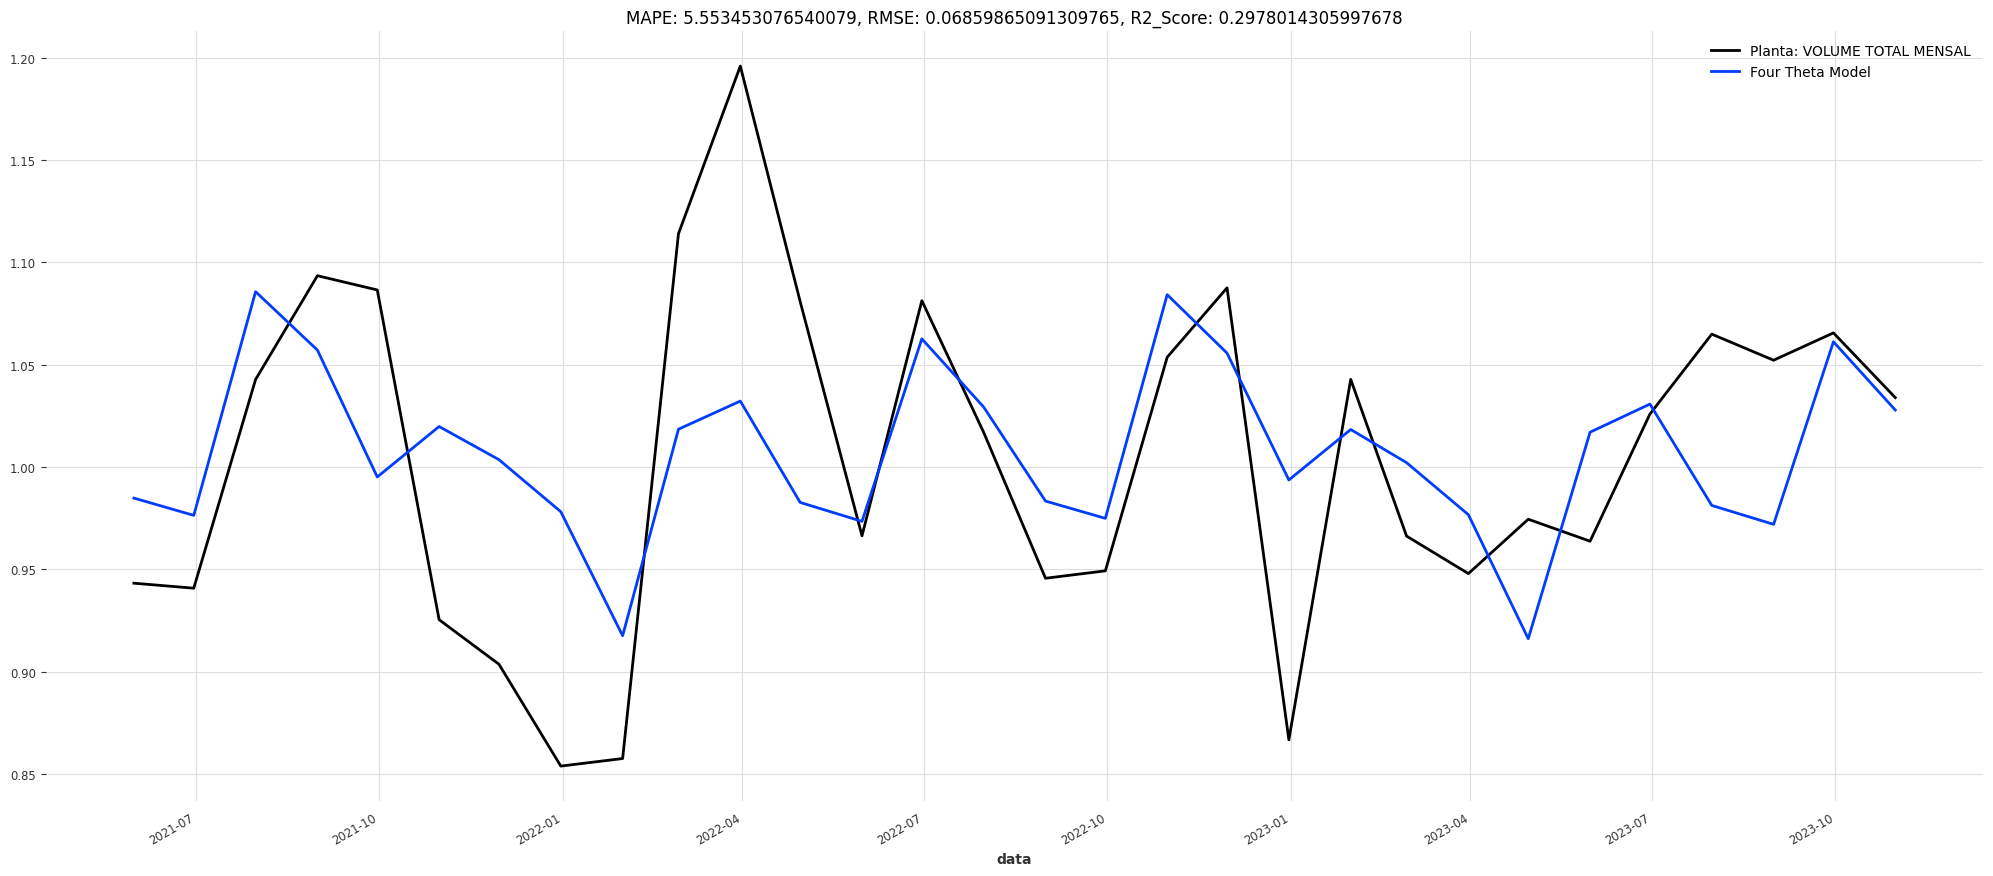

In [ ]:
plot_model(test_m,
           'VOLUME TOTAL MENSAL',
           pred_fourtheta_m,
           'Four Theta Model')

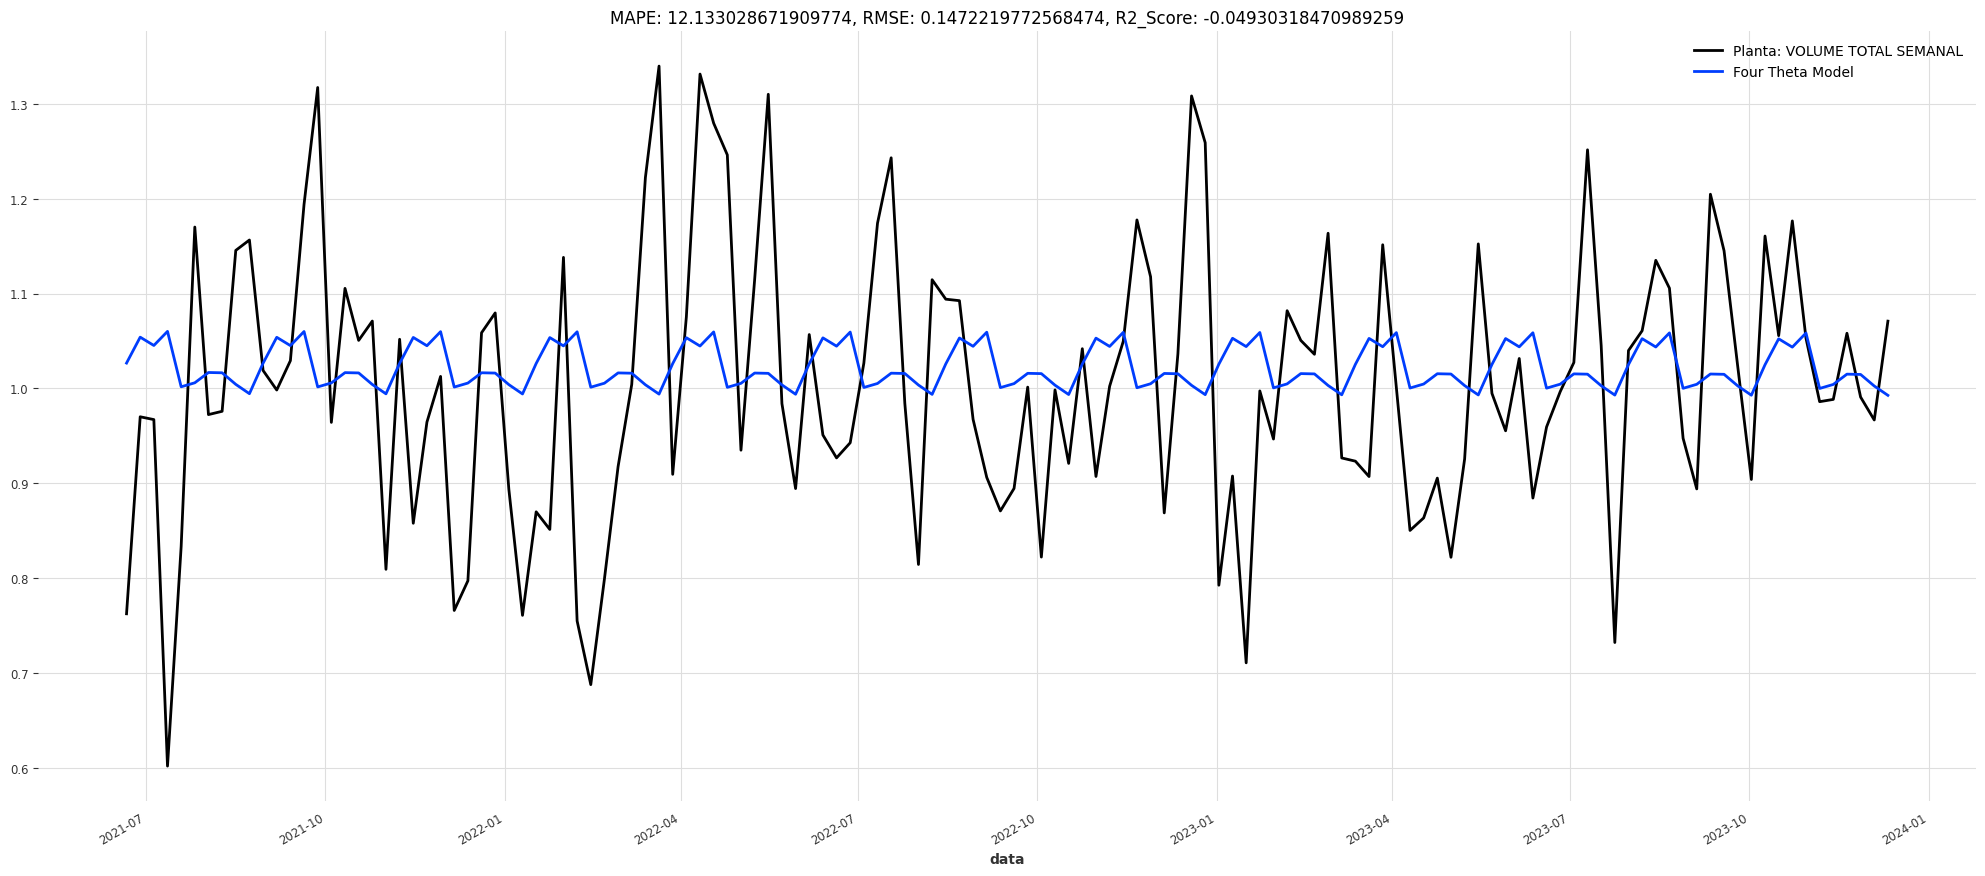

In [ ]:
plot_model(test_w,
           'VOLUME TOTAL SEMANAL',
           pred_fourtheta_w,
           'Four Theta Model')

### FFT

In [ ]:
model_fft_m = FFT(required_matches={'month'})
model_fft_w = FFT(required_matches={'day'})

pred_fft_m = model_fft_m.fit(train_m).predict(len(test_m))
pred_fft_w = model_fft_w.fit(train_w).predict(len(test_w))

In [ ]:
# parameters_fft={
#     'nr_freqs_to_keep': [0,1,2,3,4,5],
#     'required_matches': [{'month'},{'week'} ,{'day'}],
#     'trend': ['poly', 'exp', None],
#     'trend_poly_degree': [1,2,3]}

# model_fft_m.gridsearch(
#     parameters=parameters_fft,
#     series=train_m,
#     forecast_horizon=6)

# model_fft_w.gridsearch(
#     parameters=parameters_fft,
#     series=train_w,
#     forecast_horizon=24)

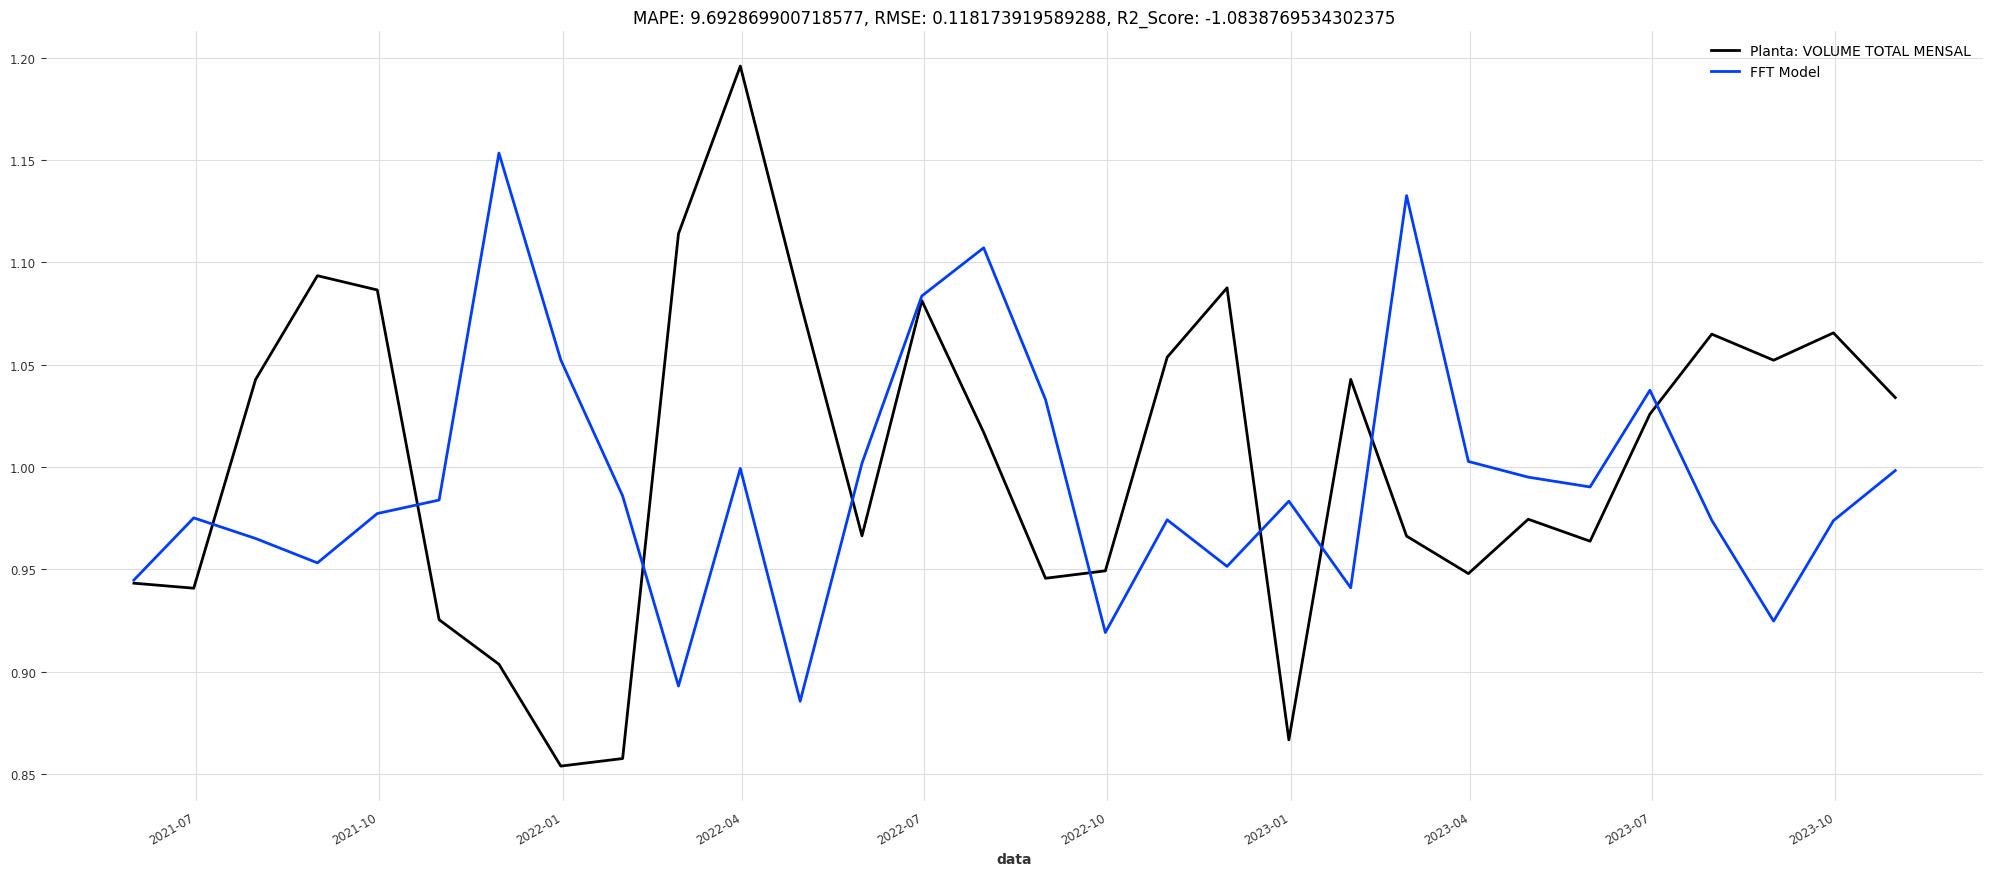

In [ ]:
plot_model(test_m,
           'VOLUME TOTAL MENSAL',
           pred_fft_m,
           'FFT Model')

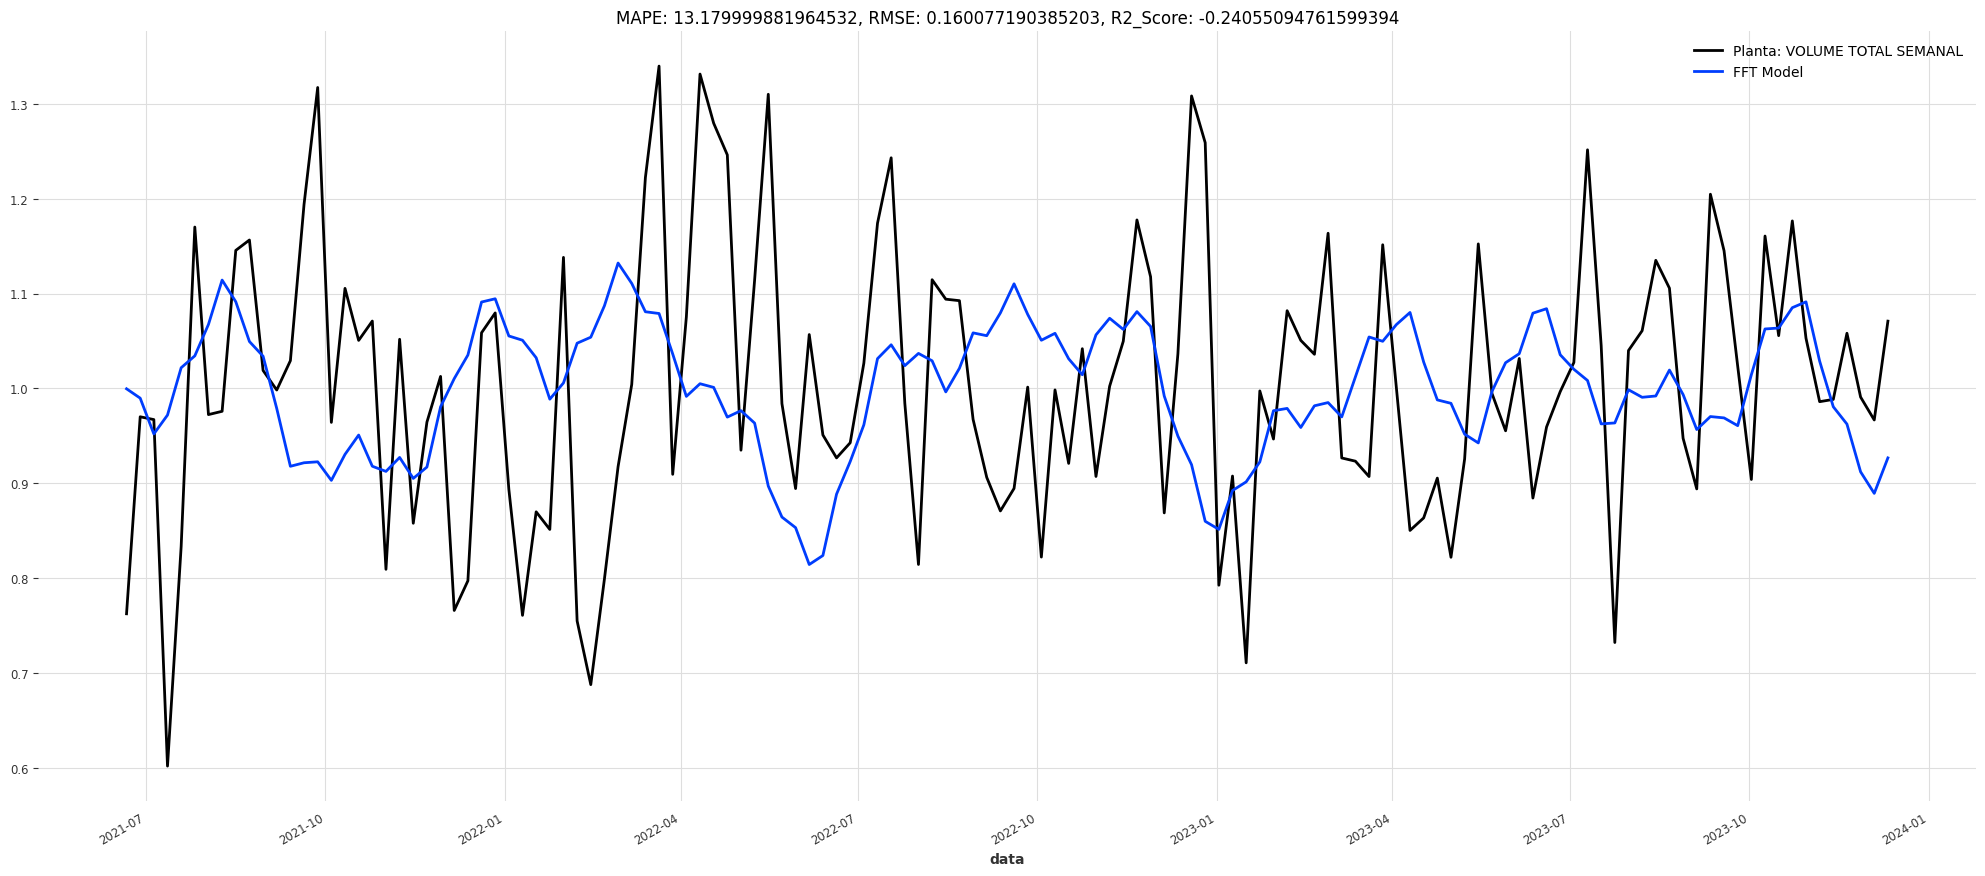

In [ ]:
plot_model(test_w,
           'VOLUME TOTAL SEMANAL',
           pred_fft_w,
           'FFT Model')

### Kalman Filter

In [ ]:
model_kalmanfilter_m = KalmanForecaster(dim_x=50)
model_kalmanfilter_w = KalmanForecaster(dim_x=50)

pred_kalmanfilter_m = model_kalmanfilter_m.fit(train_m).predict(len(test_m))
pred_kalmanfilter_w = model_kalmanfilter_w.fit(train_w).predict(len(test_w))

In [ ]:
# parameters_kalmanfilter={
#     'dim_x': [5,10,15,20,25,30,35,40,45,
#               50,55,60,65,70,75,80]}

# model_kalmanfilter_m.gridsearch(
#     parameters=parameters_kalmanfilter,
#     series=train_m,
#     forecast_horizon=6)

# model_kalmanfilter_w.gridsearch(
#     parameters=parameters_kalmanfilter,
#     series=train_w,
#     forecast_horizon=24)

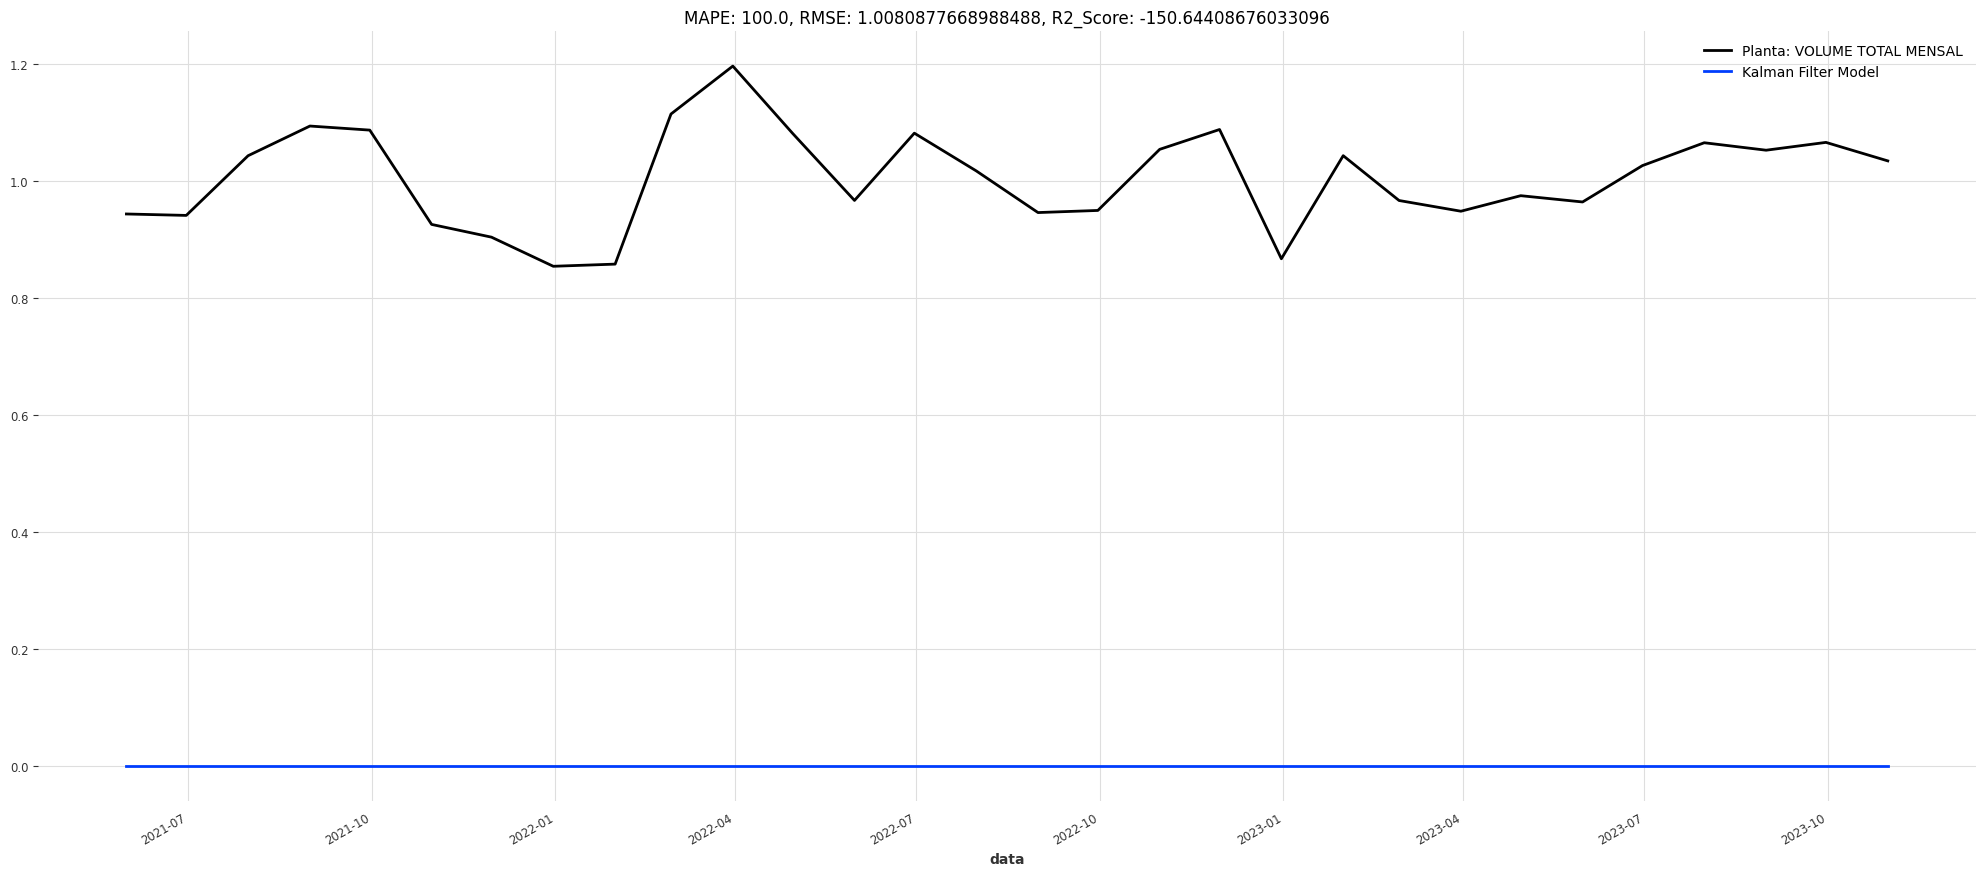

In [ ]:
plot_model(test_m,
           'VOLUME TOTAL MENSAL',
           pred_kalmanfilter_m,
           'Kalman Filter Model')

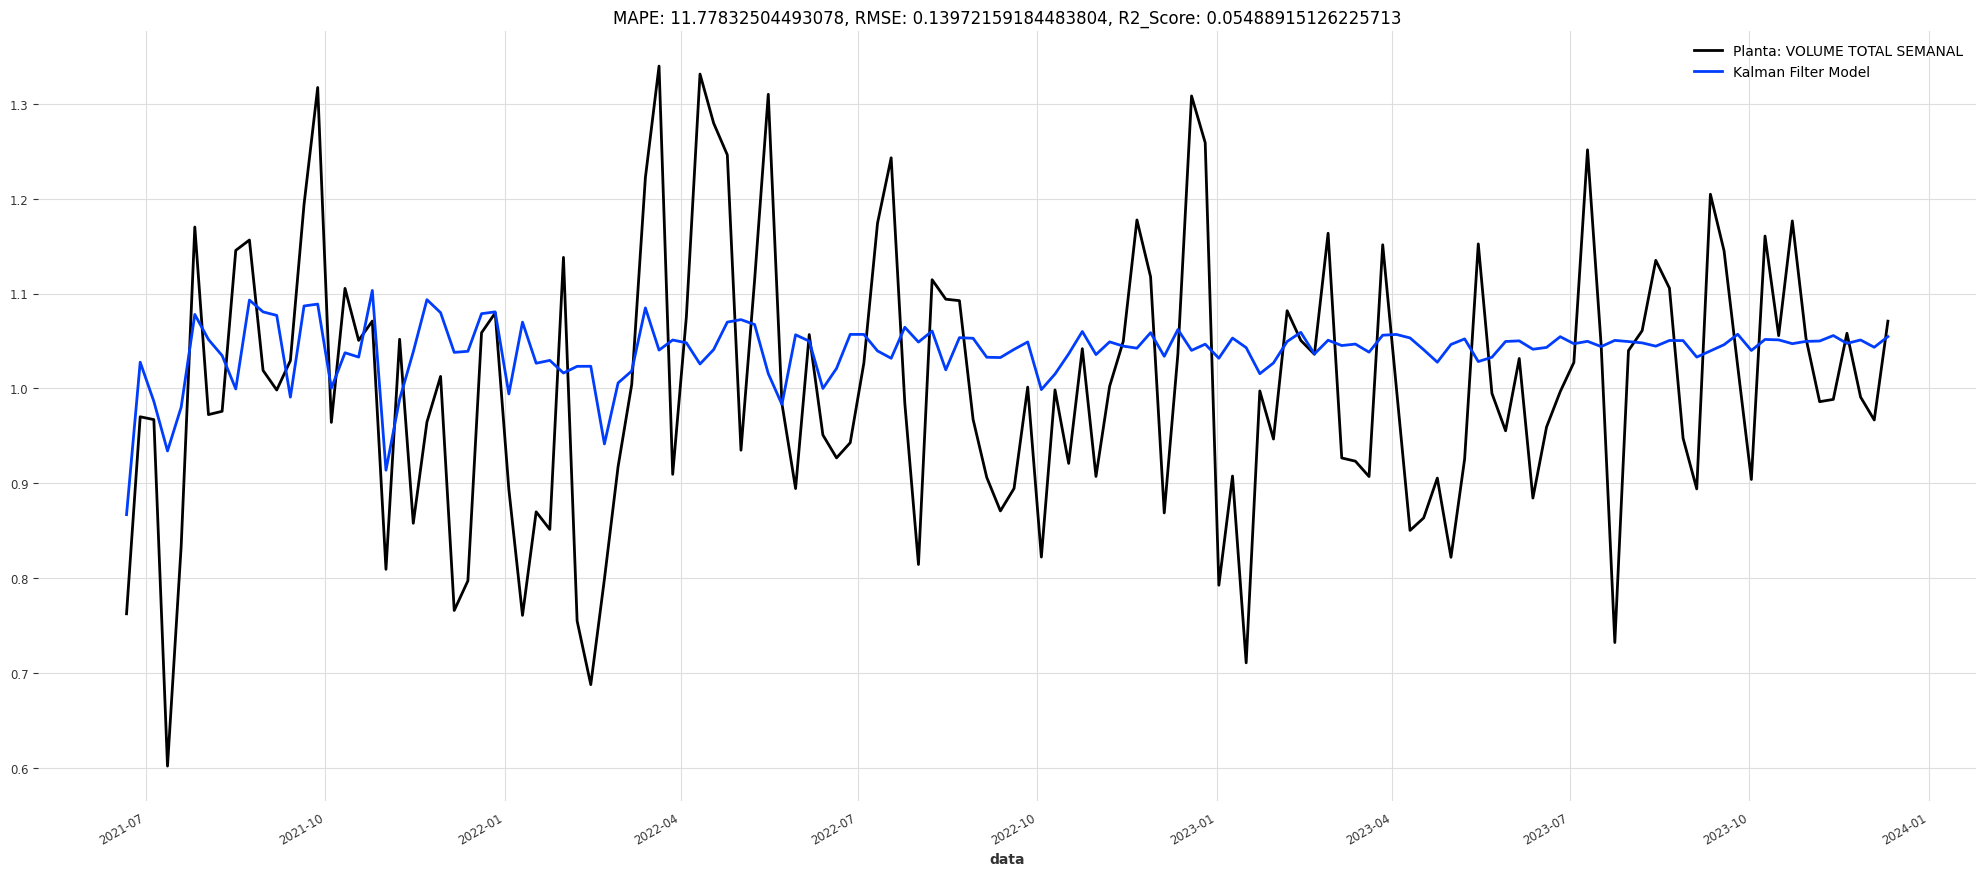

In [ ]:
plot_model(test_w,
           'VOLUME TOTAL SEMANAL',
           pred_kalmanfilter_w,
           'Kalman Filter Model')

### Croston Method

In [ ]:
model_croston_m = Croston(version='optimized')
model_croston_w = Croston(version='optimized')

pred_croston_m = model_croston_m.fit(train_m).predict(len(test_m))
pred_croston_w = model_croston_w.fit(train_w).predict(len(test_w))

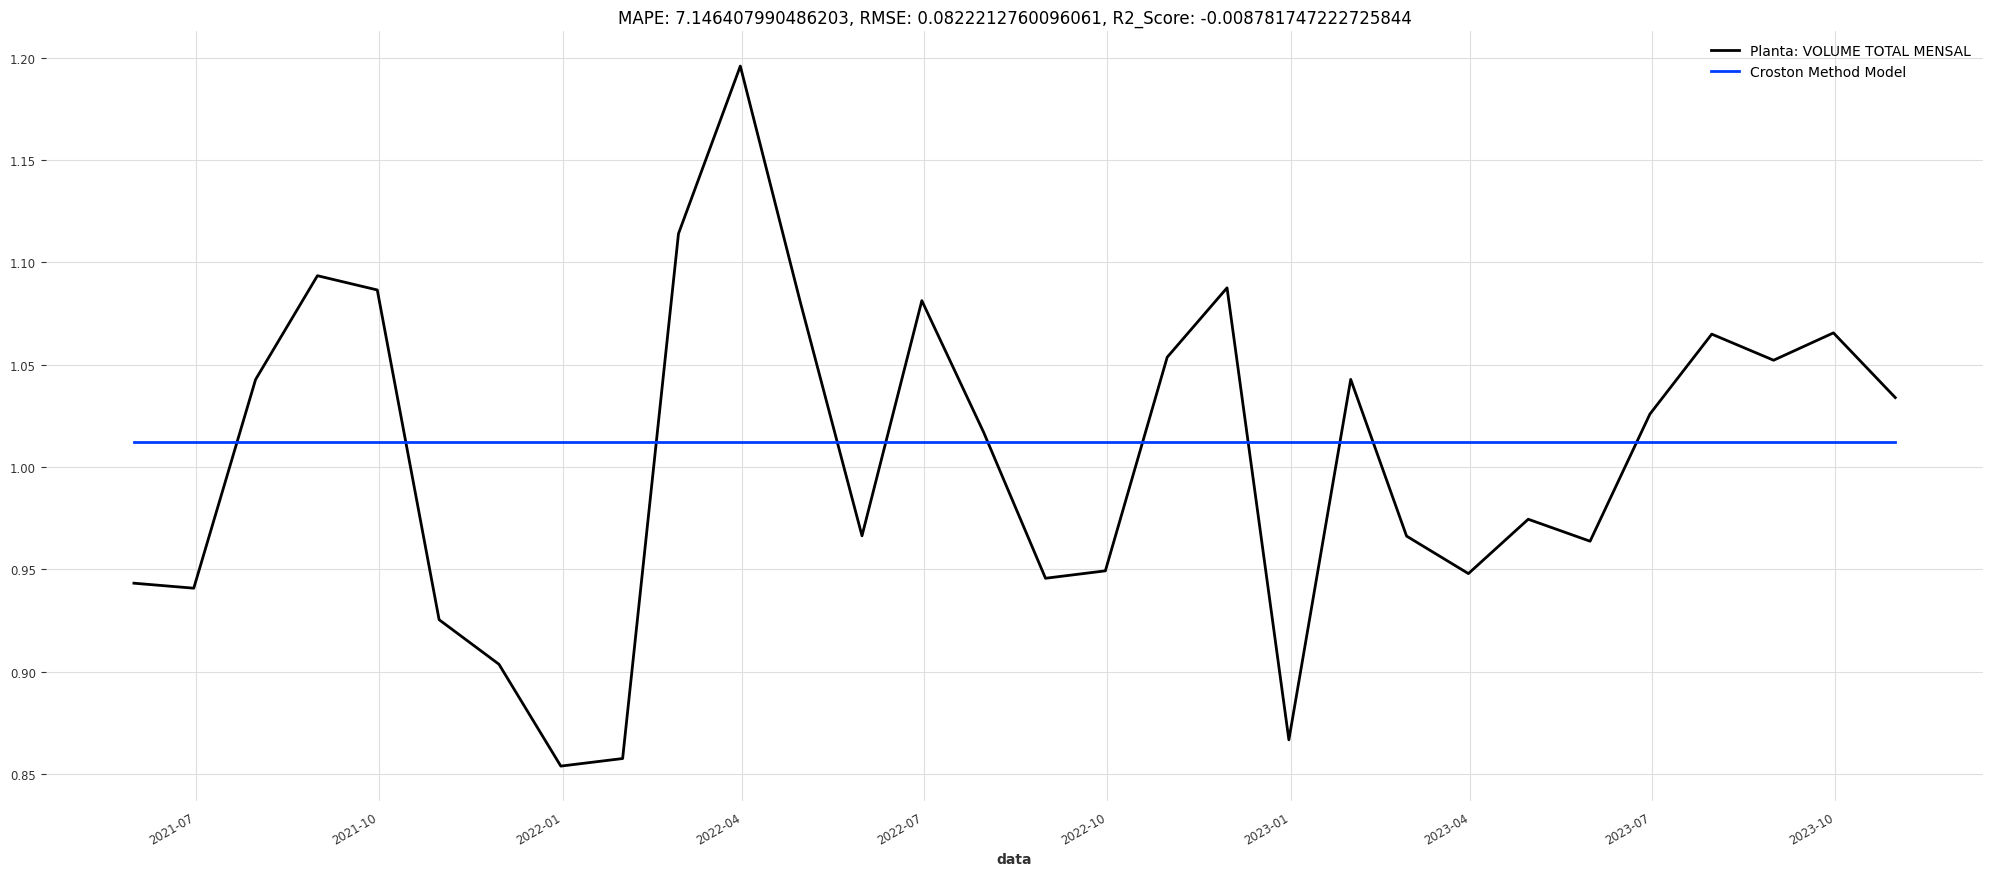

In [ ]:
plot_model(test_m,
           'VOLUME TOTAL MENSAL',
           pred_croston_m,
           'Croston Method Model')

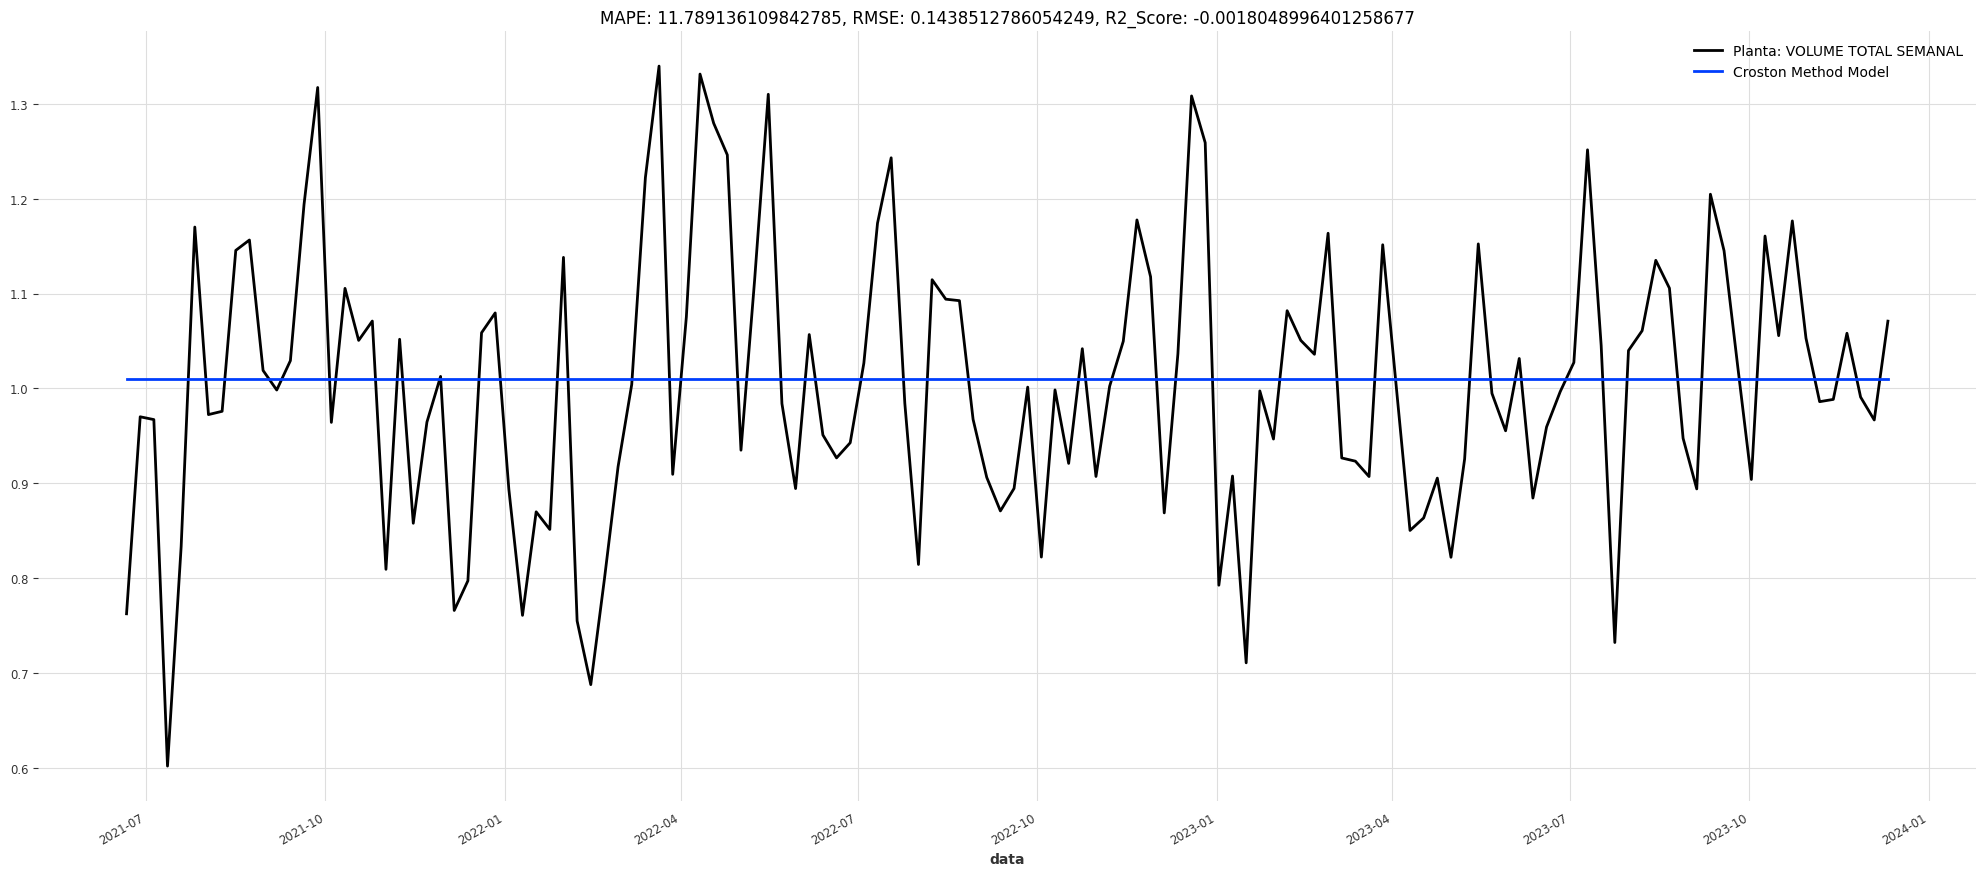

In [ ]:
plot_model(test_w,
           'VOLUME TOTAL SEMANAL',
           pred_croston_w,
           'Croston Method Model')

### Prophet

In [ ]:
model_prophet_m = Prophet(add_seasonalities={
                                  'name':"monthly_seasonality",
                                  'seasonal_periods':12,
                                  'fourier_order':5,
                                  'mode':"additive"
                                  },
                          country_holidays='Brazil')

model_prophet_w = Prophet(add_seasonalities={
                                  'name':"daily_seasonality",
                                  'seasonal_periods':10,
                                  'fourier_order':5,
                                  'mode':"additive"
                                  },
                          country_holidays='Brazil')

pred_prophet_m = model_prophet_m.fit(train_m).predict(len(test_m))
pred_prophet_w = model_prophet_w.fit(train_w).predict(len(test_w))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8usvshy2/3wznl54p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8usvshy2/ft2o2lri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43100', 'data', 'file=/tmp/tmp8usvshy2/3wznl54p.json', 'init=/tmp/tmp8usvshy2/ft2o2lri.json', 'output', 'file=/tmp/tmp8usvshy2/prophet_modelz3egx71l/prophet_model-20240416183106.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:31:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali

In [ ]:
# parameters_prophet_m={
#     'add_seasonalities': [{'name':"monthly_seasonality",
#                           'seasonal_periods':1,
#                           'fourier_order':3,
#                           'mode':"additive"},
#                          {'name':"monthly_seasonality",
#                           'seasonal_periods':3,
#                           'fourier_order':5,
#                           'mode':"additive"},
#                           {'name':"monthly_seasonality",
#                           'seasonal_periods':6,
#                           'fourier_order':10,
#                           'mode':"additive"},
#                           {'name':"monthly_seasonality",
#                           'seasonal_periods':10,
#                           'fourier_order':12,
#                           'mode':"additive"},
#                           {'name':"monthly_seasonality",
#                           'seasonal_periods':12,
#                           'fourier_order':15,
#                           'mode':"additive"}],

#     'country_holidays': ['BR'],
#     'suppress_stdout_stderror': [True, False]}

# prophet_m_grid = model_prophet_m.gridsearch(
#     parameters=parameters_prophet_m,
#     series=train_m,
#     forecast_horizon=6)

In [ ]:
# parameters_prophet_w={
#     'add_seasonalities':[{'name':"weekly_seasonality",
#                           'seasonal_periods':4,
#                           'fourier_order':1,
#                           'mode':"additive"},
#                          {'name':"weekly_seasonality",
#                           'seasonal_periods':12,
#                           'fourier_order':3,
#                           'mode':"additive"},
#                           {'name':"weekly_seasonality",
#                           'seasonal_periods':18,
#                           'fourier_order':5,
#                           'mode':"additive"},
#                           {'name':"weekly_seasonality",
#                           'seasonal_periods':24,
#                           'fourier_order':12,
#                           'mode':"additive"},
#                           {'name':"weekly_seasonality",
#                           'seasonal_periods':36,
#                           'fourier_order':15,
#                           'mode':"additive"}],

#     'country_holidays': ['BR'],
#     'suppress_stdout_stderror': [True, False] }

# prophet_w_grid = model_prophet_w.gridsearch(
#     parameters=parameters_prophet_w,
#     series=train_w,
#     forecast_horizon=24)

In [ ]:
# prophet_m_grid, prophet_w_grid

In [ ]:
model_prophet_m = Prophet(add_seasonalities={
                                  'name':"monthly_seasonality",
                                  'seasonal_periods':1,
                                  'fourier_order':3,
                                  'mode':"additive"
                                  },
                          country_holidays='BR',
                          suppress_stdout_stderror=True)


pred_prophet_m = model_prophet_m.fit(train_m).predict(len(test_m))


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpofb15vl3/whzdce8k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpofb15vl3/n6lmk4t3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54561', 'data', 'file=/tmp/tmpofb15vl3/whzdce8k.json', 'init=/tmp/tmpofb15vl3/n6lmk4t3.json', 'output', 'file=/tmp/tmpofb15vl3/prophet_modelevqsse8_/prophet_model-20240413191624.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:16:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:16:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# model_prophet_w = Prophet(add_seasonalities={
#                                   'name':"weekly_seasonality",
#                                   'seasonal_periods':4,
#                                   'fourier_order':1,
#                                   'mode':"additive"
#                                   },
#                           country_holidays='BR',
#                           suppress_stdout_stderror=True)

# pred_prophet_w = model_prophet_w.fit(train_w).predict(len(test_w))

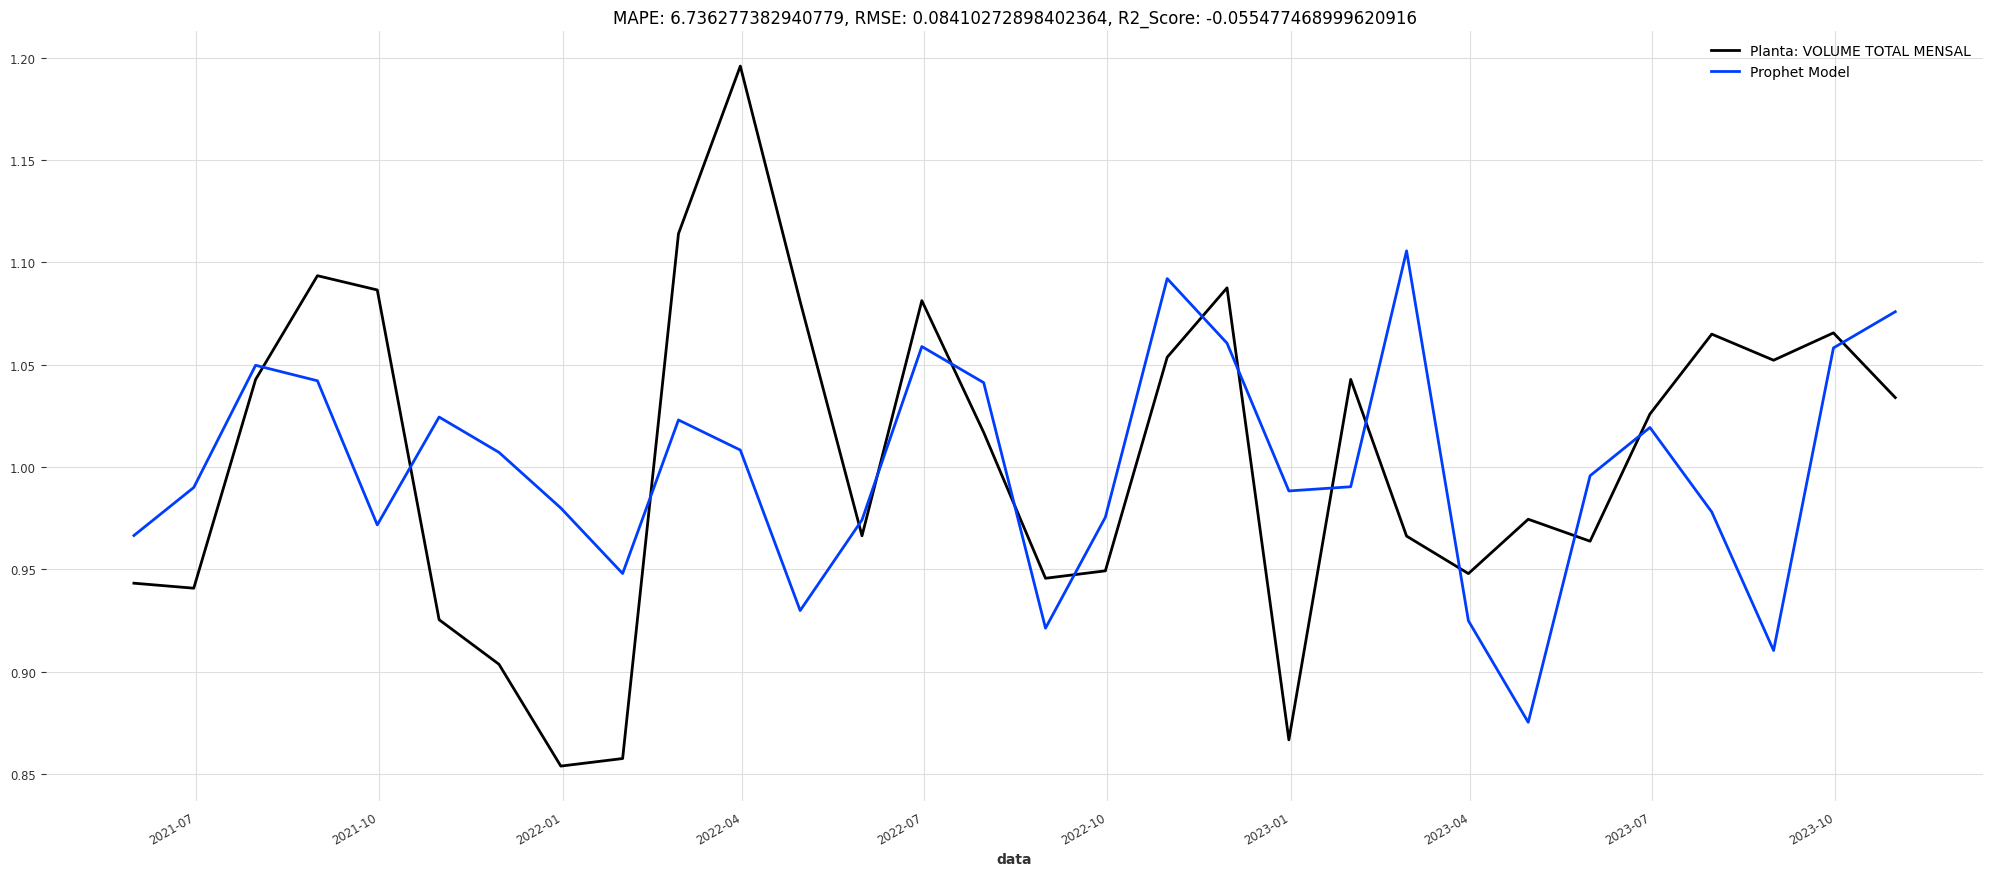

In [ ]:
plot_model(test_m,
           'VOLUME TOTAL MENSAL',
           pred_prophet_m,
           'Prophet Model')

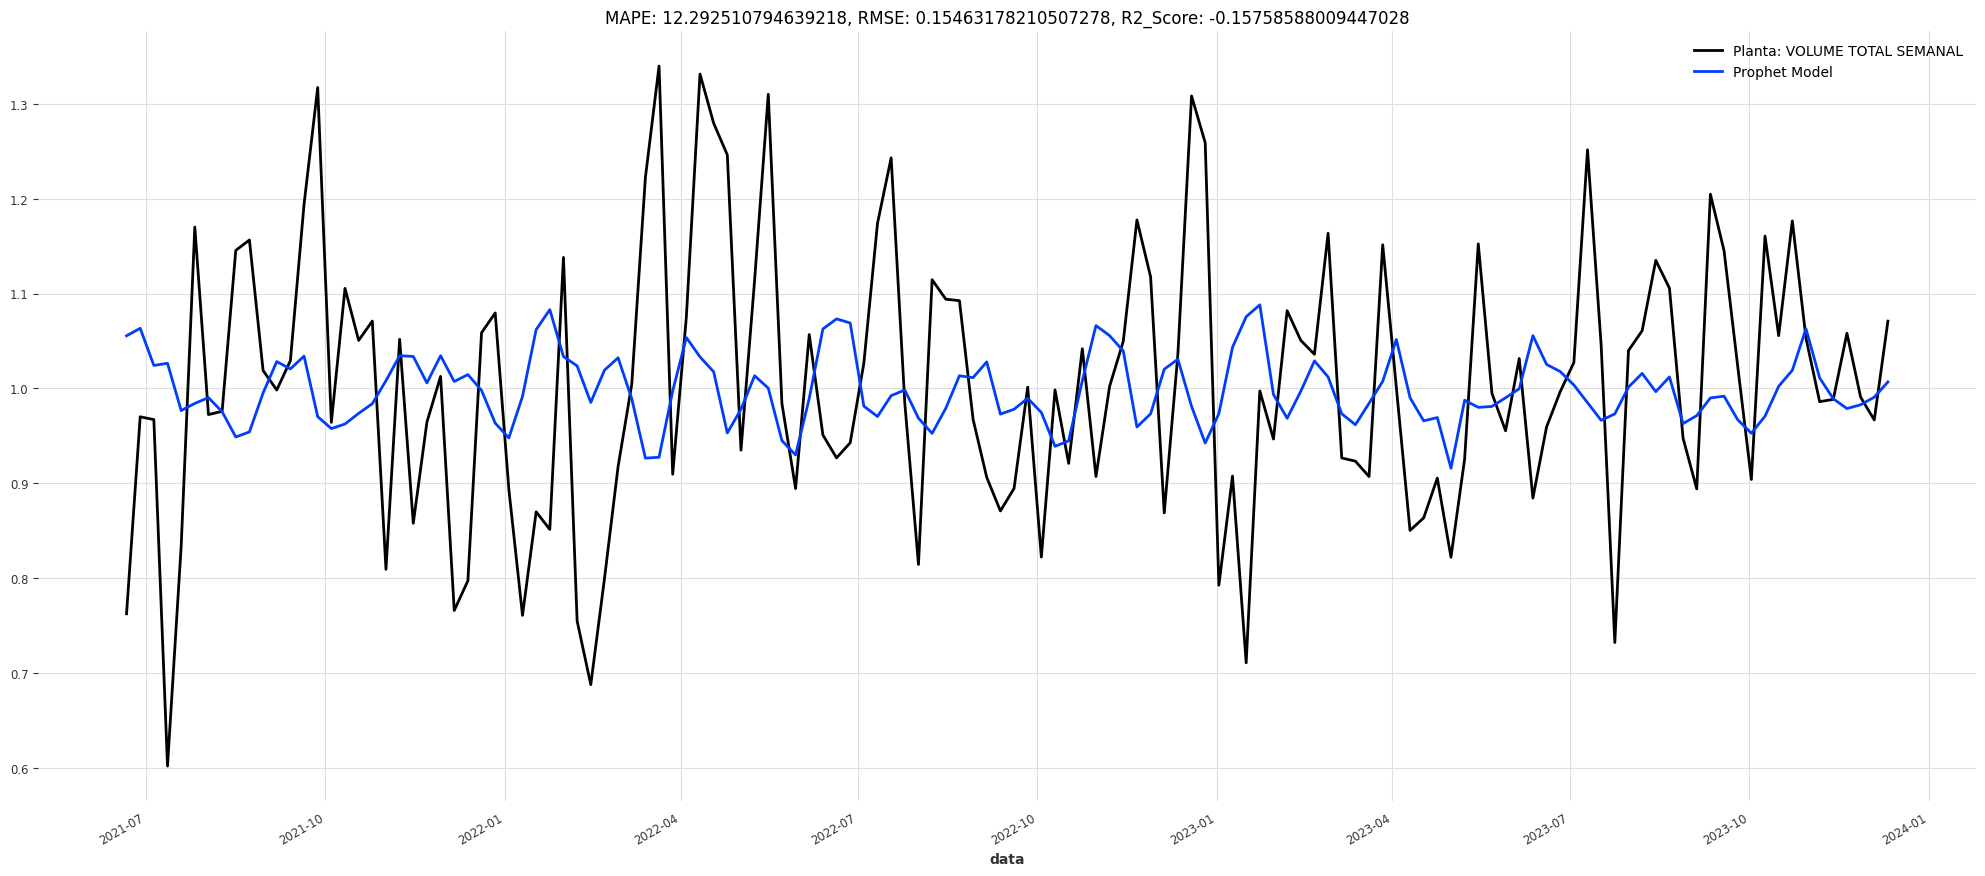

In [ ]:
plot_model(test_w,
           'VOLUME TOTAL SEMANAL',
           pred_prophet_w,
           'Prophet Model')

## Regressors

### Linear Regression

In [ ]:
model_linear_regression_m = LinearRegressionModel(
    lags=10,
    output_chunk_length=10,
    multi_models=True
)

model_linear_regression_w = LinearRegressionModel(
    lags=1,
    output_chunk_length=1,
    multi_models=True
)

pred_linear_regression_m = model_linear_regression_m.fit(train_m).predict(len(test_m))
pred_linear_regression_w = model_linear_regression_w.fit(train_w).predict(len(test_w))

In [ ]:
# parameters_linear_regression_m={
#     'lags': [5,10,12,14,23,25],
#     'output_chunk_length': [1,5,10,12,14,23,25],
#     # 'output_chunk_shift': [0,1,5,10,12,14,23,25],
#     'likelihood': ['quantile', 'poisson'],
#     'multi_models': [True, False]}

# linear_regression_m_grid = model_linear_regression_m.gridsearch(
#                                 parameters=parameters_linear_regression_m,
#                                 series=train_m,
#                                 forecast_horizon=6)

In [ ]:
# parameters_linear_regression_w={
#     'lags': [1,4,8,9,10,14,21],
#     'output_chunk_length': [1,4,8,9,10,14,21],
#     # 'output_chunk_shift': [0,1,4,8,9,10,14,21],
#     'likelihood': ['quantile'],
#     'multi_models': [True, False]}

# linear_regression_w_grid = model_linear_regression_w.gridsearch(
#     parameters=parameters_linear_regression_w,
#     series=train_w,
#     forecast_horizon=24)

In [ ]:
# linear_regression_m_grid, linear_regression_w_grid

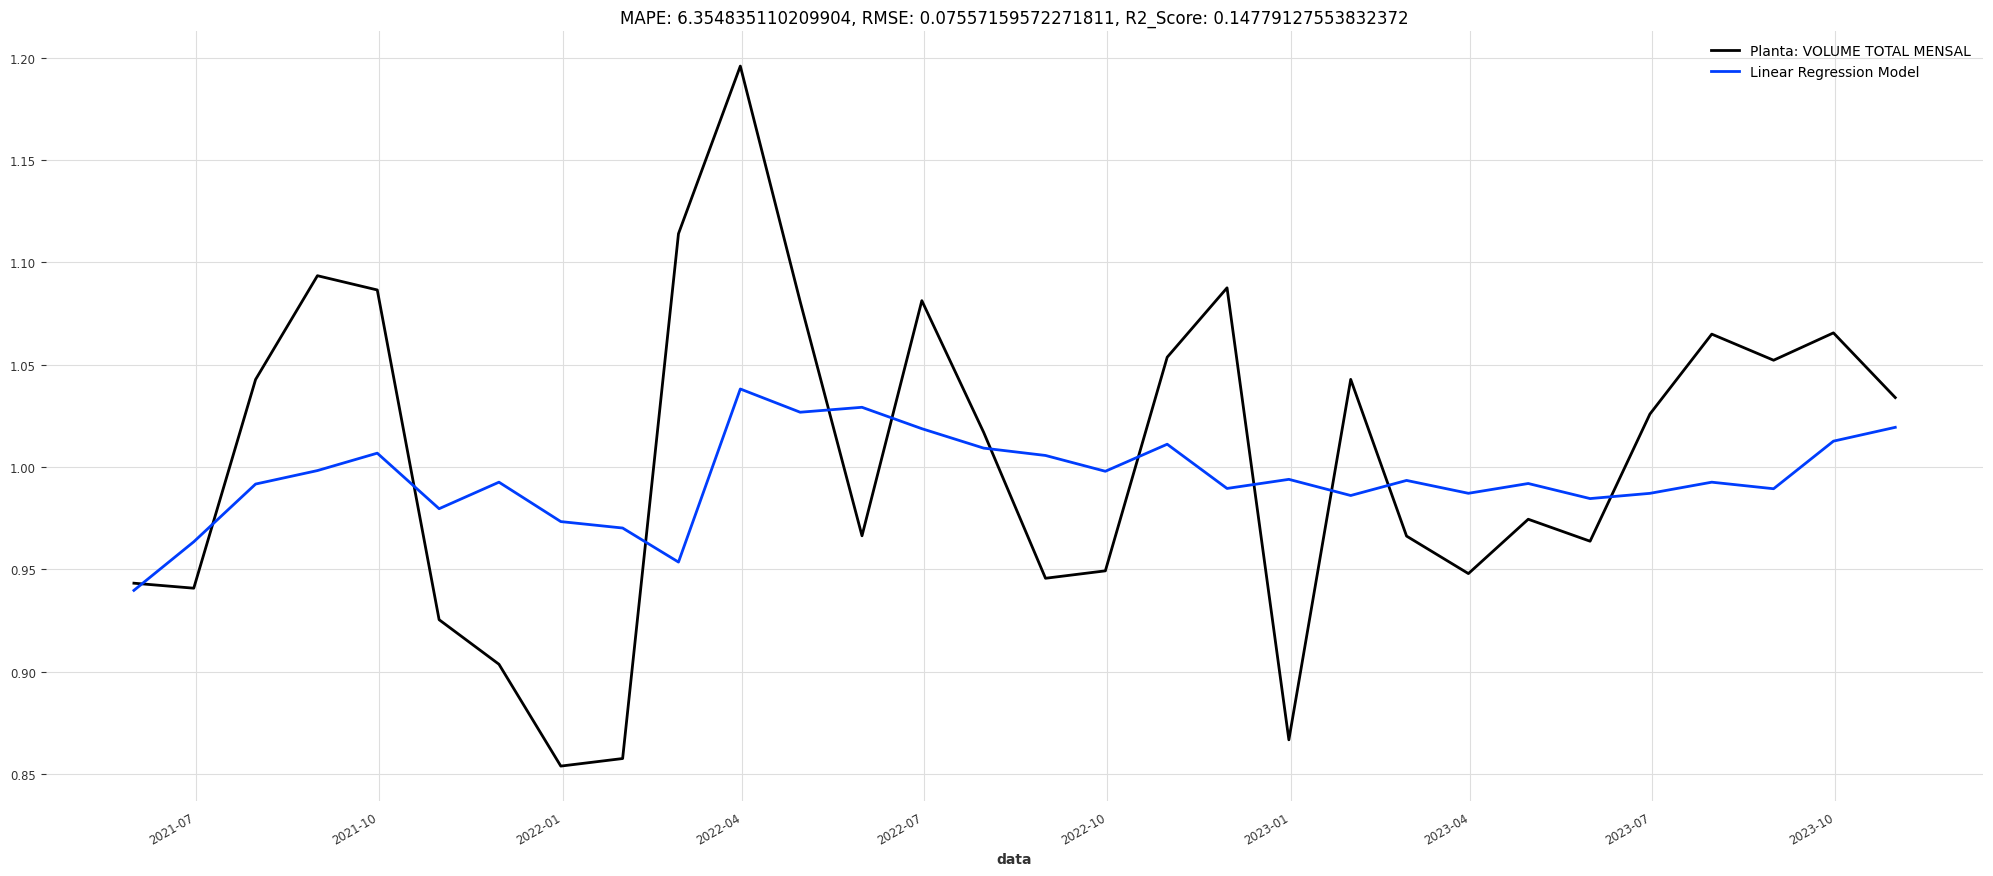

In [ ]:
plot_model(test_m,
           'VOLUME TOTAL MENSAL',
           pred_linear_regression_m,
           'Linear Regression Model')

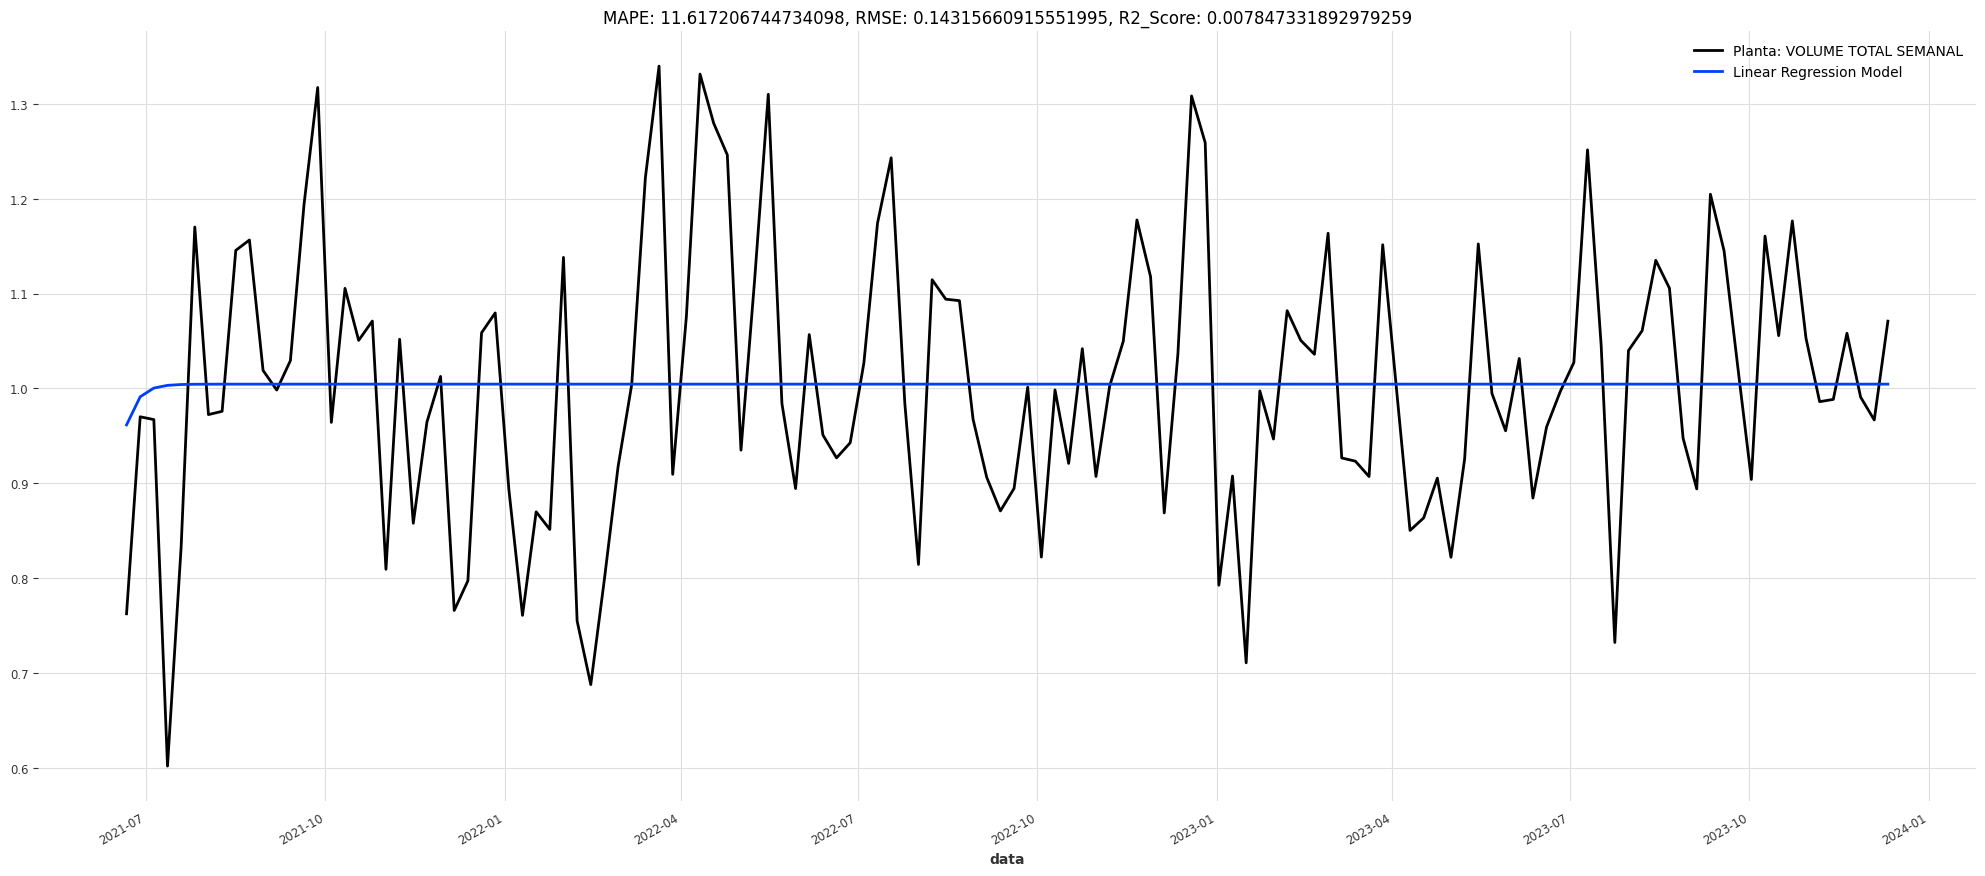

In [ ]:
plot_model(test_w,
           'VOLUME TOTAL SEMANAL',
           pred_linear_regression_w,
           'Linear Regression Model')

### Random Forest Regression

In [ ]:
model_random_forest_m = RandomForest(
    lags=12,
    output_chunk_length=12,
    # output_chunk_shift=-12,
    n_estimators=150,
    criterion="absolute_error",
    multi_models=True
)

model_random_forest_w = RandomForest(
    lags=21,
    output_chunk_length=21,
    # output_chunk_shift=-12,
    n_estimators=150,
    criterion="absolute_error",
    multi_models=True
)

pred_random_forest_m = model_random_forest_m.fit(train_m).predict(len(test_m))
pred_random_forest_w = model_random_forest_w.fit(train_w).predict(len(test_w))

In [ ]:
# parameters_random_forest_m={
#     'lags': [5,10,12,14,23,25],
#     'output_chunk_length': [1,5,10,12,14,23,25],
#     # 'output_chunk_shift': [0,1,5,10,12,14,23,25],
#     'n_estimators': [50,100,150,200,250,300],
#     'criterion': ['squared_error',
#                   'absolute_error',
#                   'friedman_mse',
#                   'poisson'],
#     'multi_models': [True, False]}


# random_forest_m_grid = model_random_forest_m.gridsearch(
#                                     parameters=parameters_random_forest_m,
#                                     series=train_m,
#                                     forecast_horizon=6)

In [ ]:
# parameters_random_forest_w={
#     'lags': [1,4,8,9,10,14,21],
#     'output_chunk_length': [1,4,8,9,10,14,21],
#     'output_chunk_shift': [0,1,4,8,9,10,14,21],
#     'n_estimators': [50,100,150,200,250,300],
#     'criterion': ['squared_error',
#                   'absolute_error',
#                   'friedman_mse',
#                   'poisson'],
#     'multi_models': [True, False]}

# random_forest_w_grid = model_random_forest_w.gridsearch(
#                             parameters=parameters_random_forest_w,
#                             series=train_w,
#                             forecast_horizon=24)

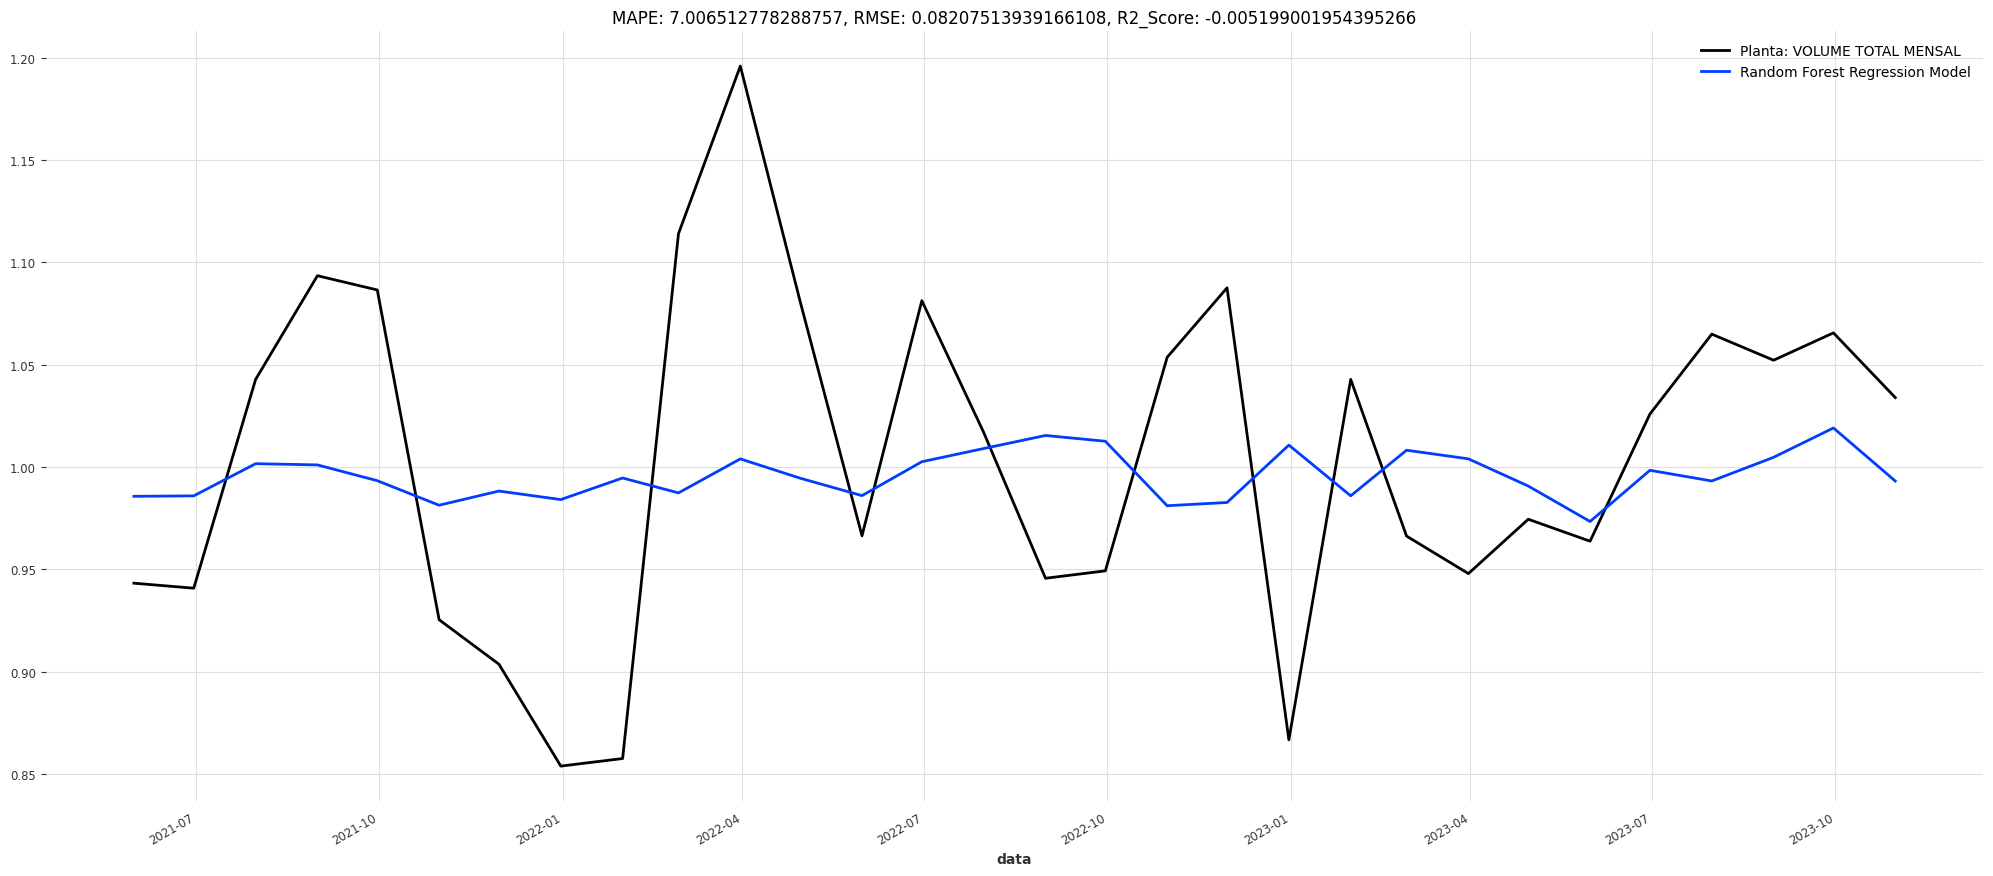

In [ ]:
plot_model(test_m,
           'VOLUME TOTAL MENSAL',
           pred_random_forest_m,
           'Random Forest Regression Model')

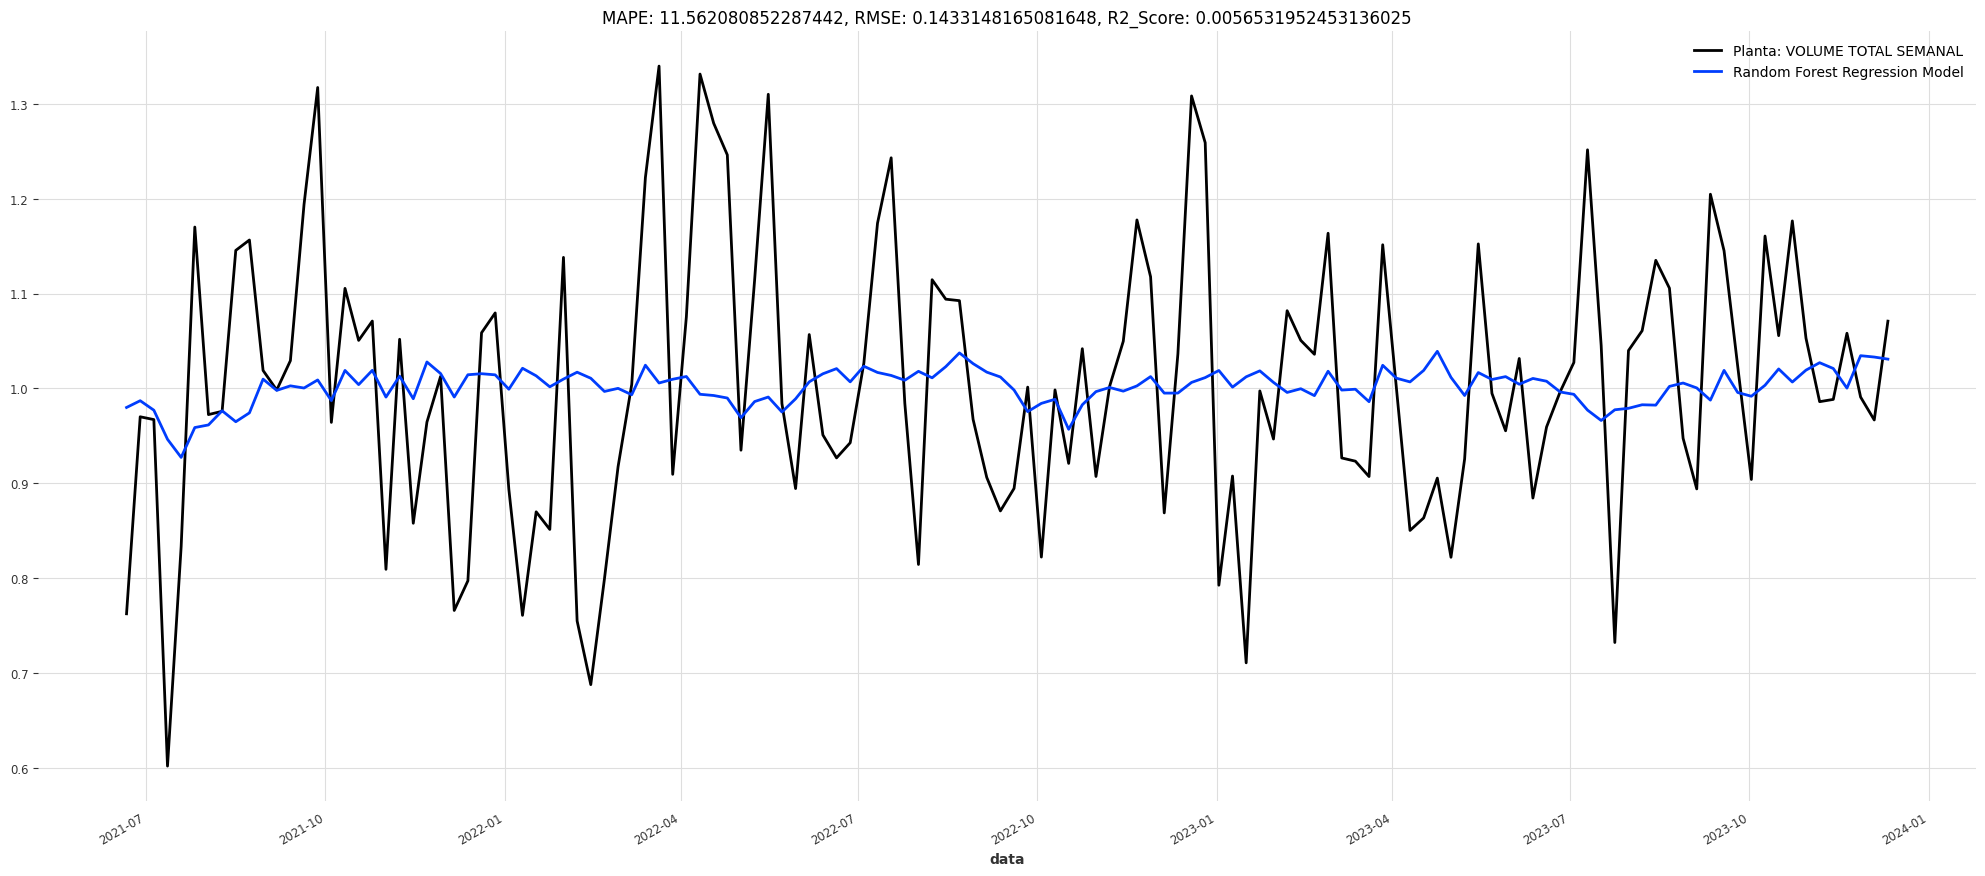

In [ ]:
plot_model(test_w,
           'VOLUME TOTAL SEMANAL',
           pred_random_forest_w,
           'Random Forest Regression Model')

### LightGBM

In [ ]:
model_lgbm_m = LightGBMModel(
    lags=14,
    output_chunk_length=1,
    likelihood='poisson',
    # quantiles = [0.175, 0.25, 0.5, 0.675, 0.85],
    multi_models=True
)

model_lgbm_w = LightGBMModel(
    lags=9,
    output_chunk_length=9,
    likelihood='poisson',
    # quantiles = [0.175, 0.25, 0.5, 0.675, 0.85],
    multi_models=True
)

pred_lgbm_m = model_lgbm_m.fit(train_m).predict(len(test_m))
pred_lgbm_w = model_lgbm_w.fit(train_w).predict(len(test_w))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 14
[LightGBM] [Info] Start training from score 0.000289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [ ]:
# parameters_lgbm_m={
#     'lags': [5,10,12,14,23,25],
#     'output_chunk_length': [1,5,10,12,14,23,25],
#     'output_chunk_shift': [0,1,5,10,12,14,23,25],
#     'likelihood': [None,
#                    'sklearn.linear_model.QuantileRegressor',
#                    'sklearn.linear_model.PoissonRegressor'],
#     'quantiles': [None, 0.0, 0.175, 0.25, 0.50, 0.675, 0.85],
#     'random_state': None,
#     'multi_models': [True, False]}

# lgbm_m_grid = model_lgbm_m.gridsearch(
#                       parameters=parameters_lgbm_m,
#                       series=train_m,
#                       forecast_horizon=6)

In [ ]:
# parameters_lgbm_w={
#     'lags': [1,4,8,9,10,14,21],
#     'output_chunk_length': [1,4,8,9,10,14,21],
#     'output_chunk_shift': [0,1,4,8,9,10,14,21],
#     'likelihood': [None,
#                    'sklearn.linear_model.QuantileRegressor',
#                    'sklearn.linear_model.PoissonRegressor'],
#     'quantiles': [None, 0.0, 0.175, 0.25, 0.50, 0.675, 0.85],
#     'random_state': None,
#     'multi_models': [True, False]}


# lgb_w_grid = model_lgbm_w.gridsearch(
#                   parameters=parameters_lgbm_w,
#                   series=train_w,
#                   forecast_horizon=24)

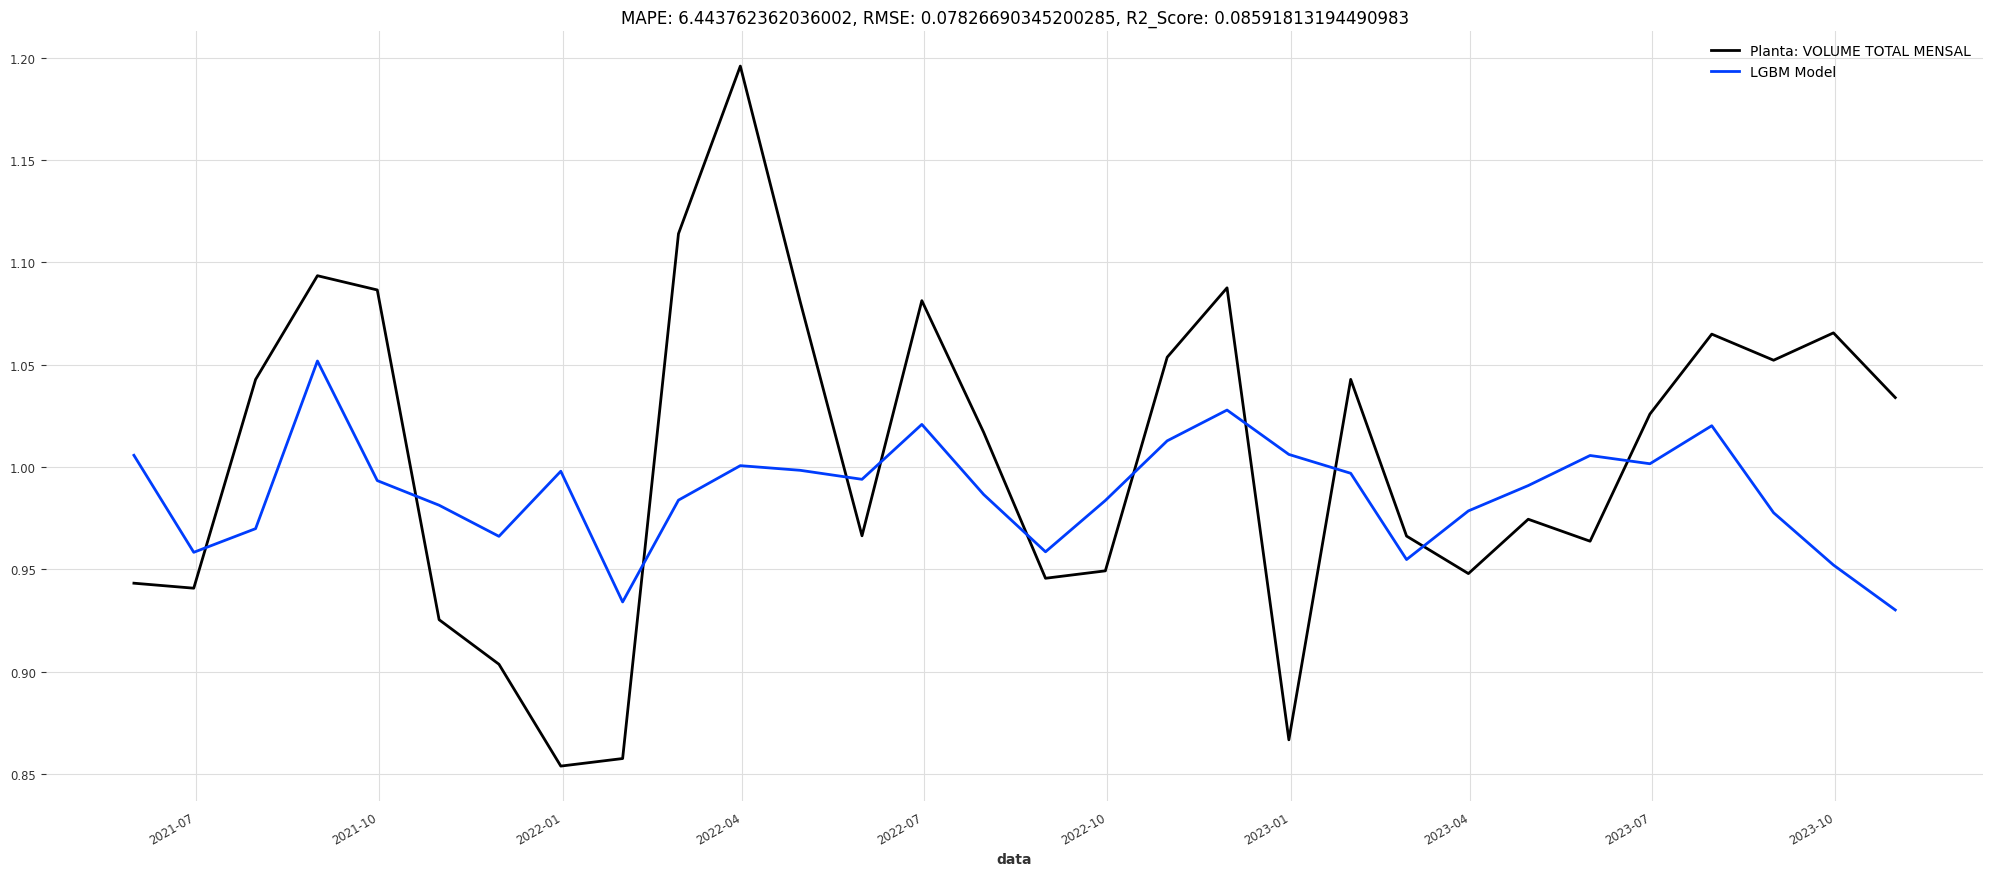

In [ ]:
plot_model(test_m,
           'VOLUME TOTAL MENSAL',
           pred_lgbm_m,
           'LGBM Model')

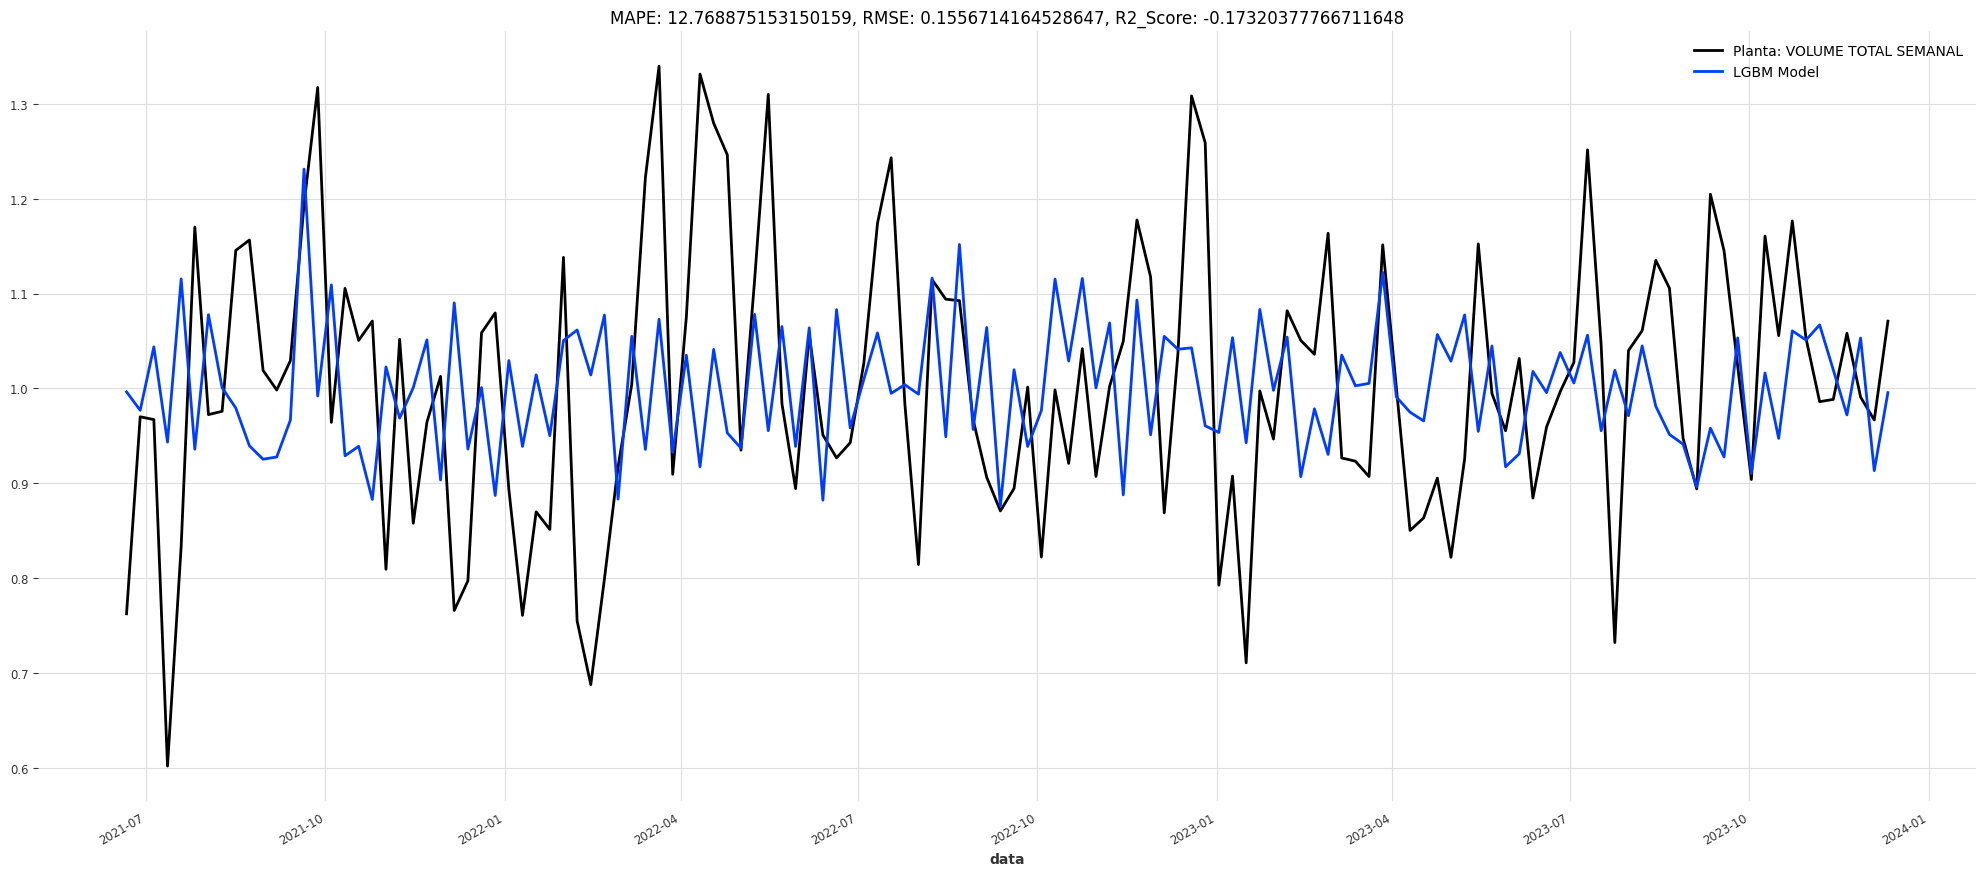

In [ ]:
plot_model(test_w,
           'VOLUME TOTAL SEMANAL',
           pred_lgbm_w,
           'LGBM Model')

### XGBoost

In [ ]:
w = [1, 4, 8, 9, 10, 14, 21]
m = [5, 10, 12, 14, 23, 25]

In [ ]:
model_xgb_m = XGBModel(
    lags=12,
    output_chunk_length=1,
    likelihood='poisson',
    # quantiles = [0.175, 0.25, 0.5, 0.675, 0.85],
    multi_models=True
)

model_xgb_w = XGBModel(
    lags=8,
    output_chunk_length=1,
    likelihood='poisson',
    # quantiles = [0.175, 0.25, 0.5, 0.675, 0.85],
    multi_models=True
)

pred_xgb_m = model_xgb_m.fit(train_m).predict(len(test_m))
pred_xgb_w = model_xgb_w.fit(train_w).predict(len(test_w))

In [ ]:
# parameters_xgb_m={
#     'lags': [5,10,12,14,23,25],
#     'output_chunk_length': [1,5,10,12,14,23,25],
#     'output_chunk_shift': [0,1,5,10,12,14,23,25],
#     'likelihood': [None,
#                    'sklearn.linear_model.QuantileRegressor',
#                    'sklearn.linear_model.PoissonRegressor'],
#     'quantiles': [None, 0.0, 0.175, 0.25, 0.50, 0.675, 0.85],
#     'random_state': None,
#     'multi_models': [True, False]}

# xgb_m_grid = model_xgb_m.gridsearch(
#                     parameters=parameters_xgb_m,
#                     series=train_m,
#                     forecast_horizon=6)

In [ ]:
# parameters_xgb_w={
#     'lags': [1,4,8,9,10,14,21],
#     'output_chunk_length': [1,4,8,9,10,14,21],
#     'output_chunk_shift': [0,1,4,8,9,10,14,21],
#     'likelihood': [None,
#                    'sklearn.linear_model.QuantileRegressor',
#                    'sklearn.linear_model.PoissonRegressor'],
#     'quantiles': [None, 0.0, 0.175, 0.25, 0.50, 0.675, 0.85],
#     'random_state': None,
#     'multi_models': [True, False]}

# xgb_w_grid = model_xgb_w.gridsearch(
#     parameters=parameters_xgb_w,
#     series=train_w,
#     forecast_horizon=24)

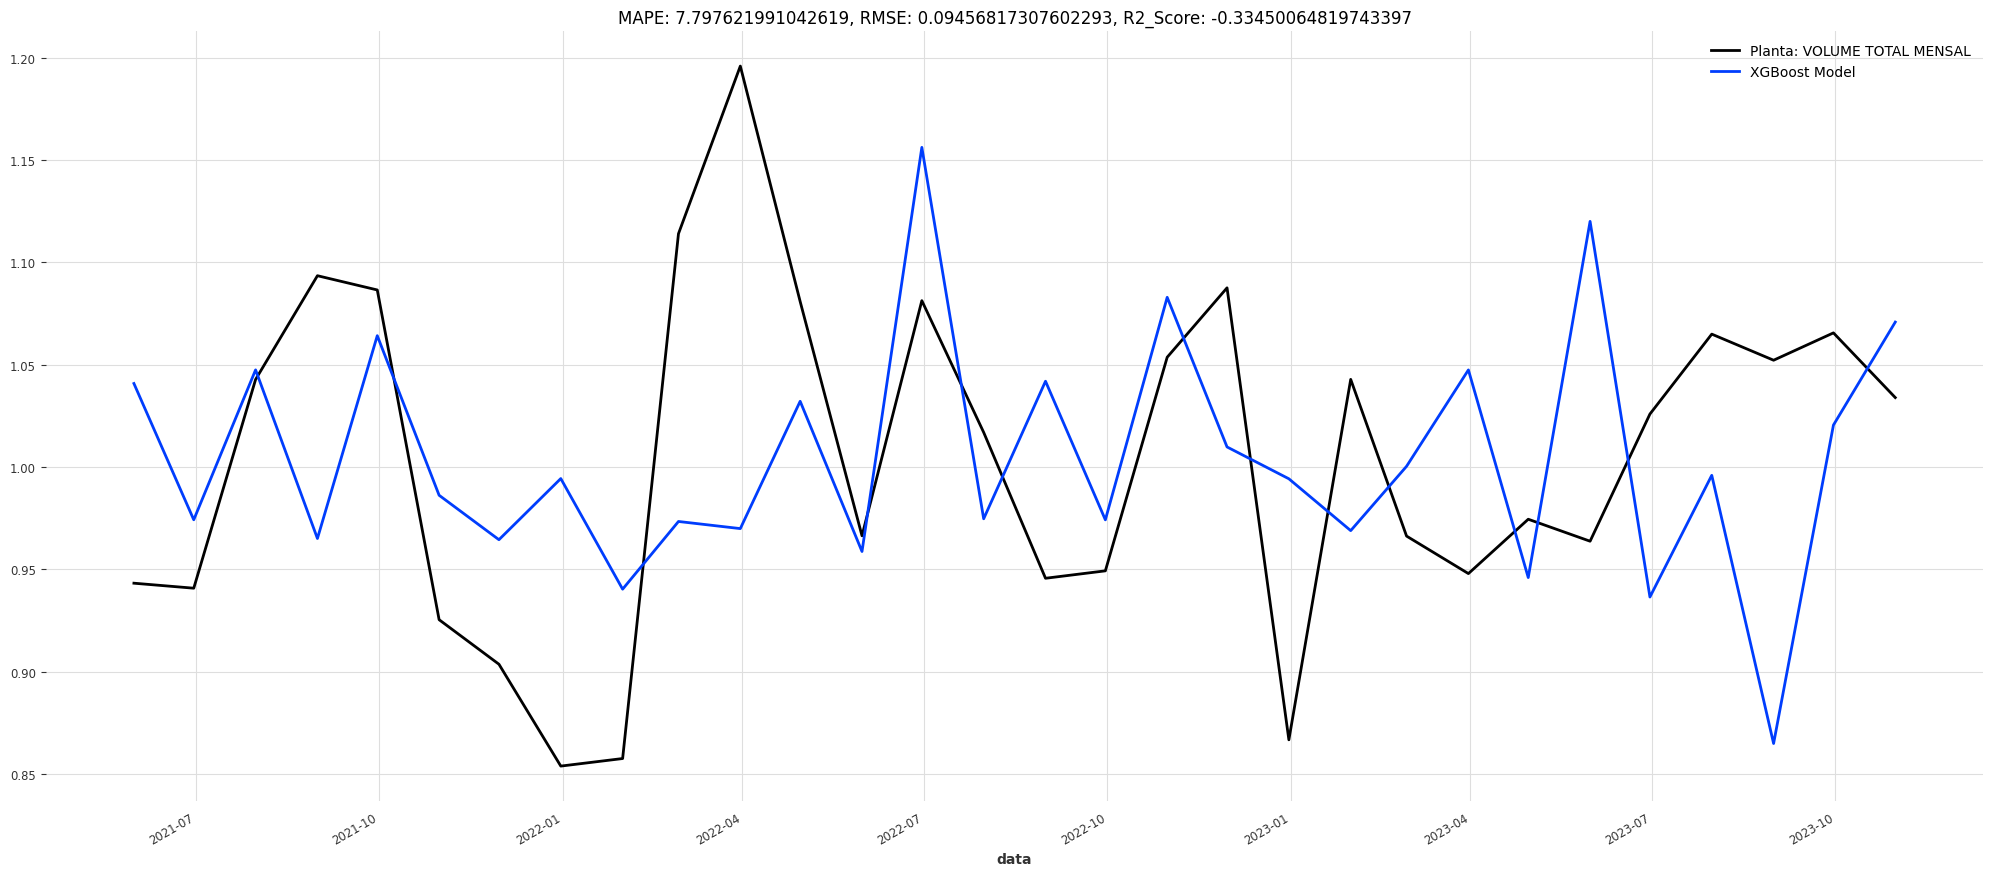

In [ ]:
plot_model(test_m,
           'VOLUME TOTAL MENSAL',
           pred_xgb_m,
           'XGBoost Model')

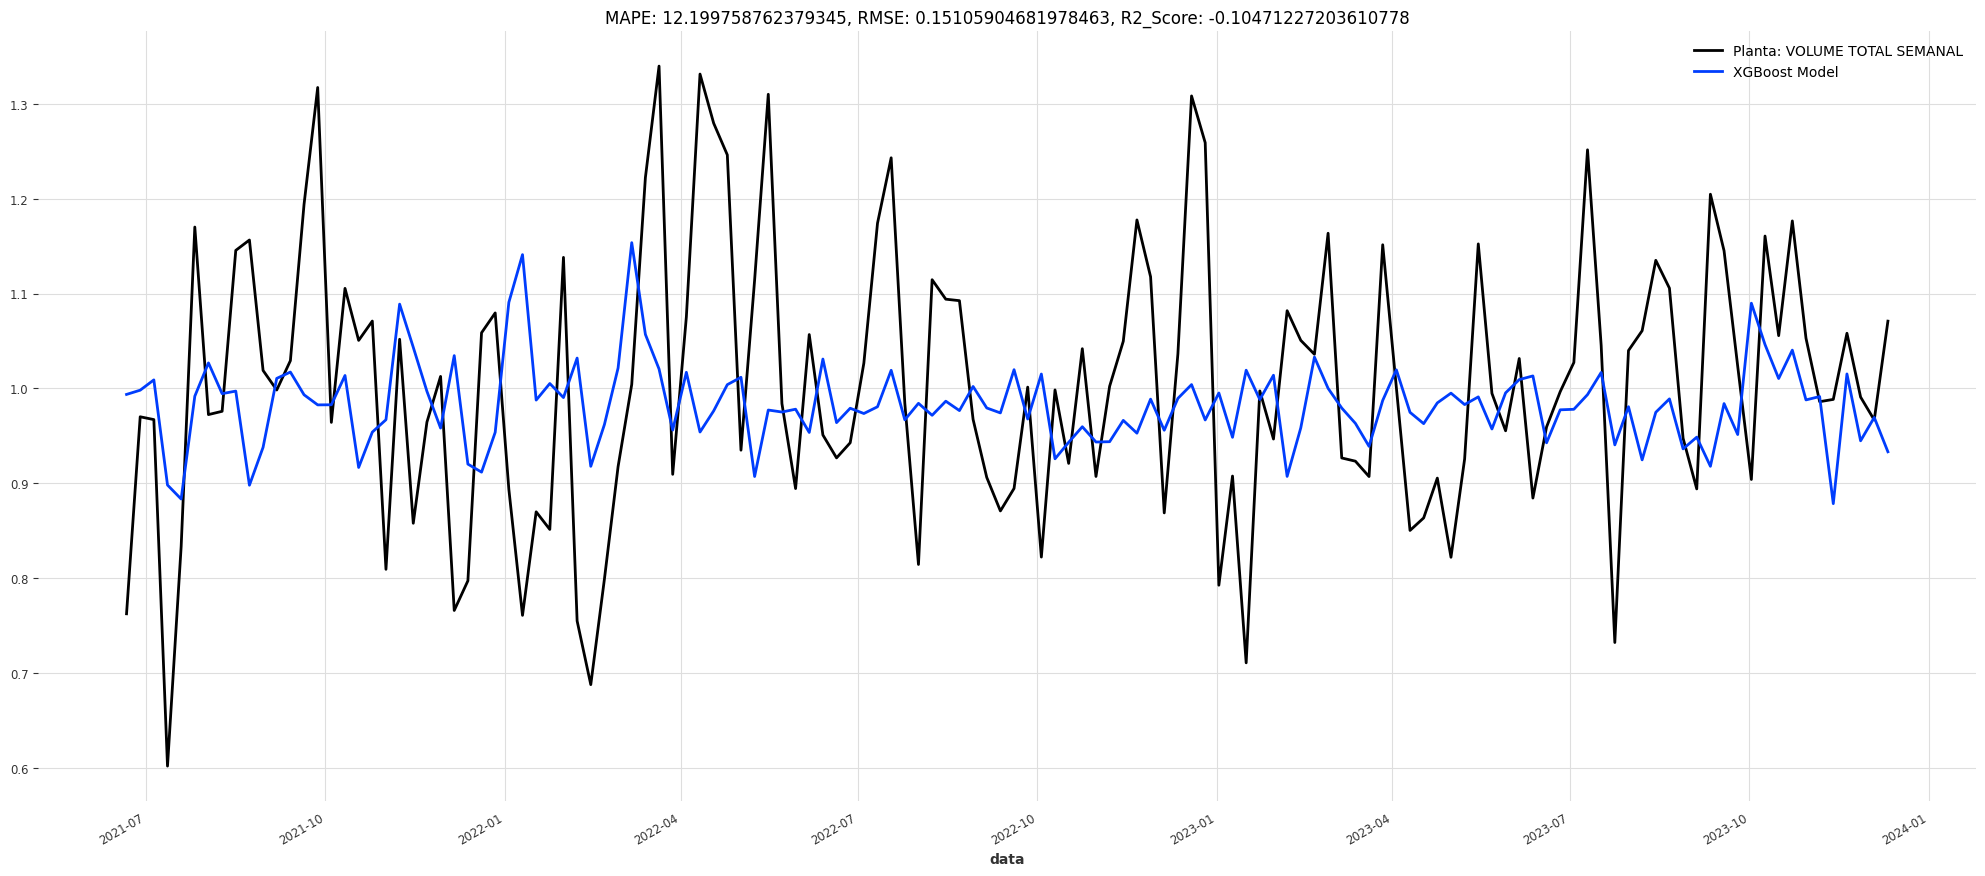

In [ ]:
plot_model(test_w,
           'VOLUME TOTAL SEMANAL',
           pred_xgb_w,
           'XGBoost Model')

## Neural Networks

### Scaling

In [ ]:
from darts.dataprocessing.transformers import Scaler

# creating scaler object
scaler_monthly , scaler_weekly = Scaler(), Scaler()

# perfoming the scaling
ts_m_scaled = scaler_monthly.fit_transform(ts_m)
ts_w_scaled = scaler_weekly.fit_transform(ts_w)

In [ ]:
#original
train_m, test_m = train_test_split(ts_m, df_m)
train_w, test_w = train_test_split(ts_w, df_w)

#scaled (better for neural networks)
train_m_scaled, test_m_scaled = train_test_split(ts_m_scaled, df_m)
train_w_scaled, test_w_scaled = train_test_split(ts_w_scaled, df_w)

### NBEATS

In [ ]:
model_nbeats_m = NBEATSModel(
    input_chunk_length=12,
    output_chunk_length=6,
    n_epochs = 150,
    random_state = 15
)

model_nbeats_w = NBEATSModel(
    input_chunk_length=12,
    output_chunk_length=6,
    n_epochs = 150,
    random_state = 15
)

pred_nbeats_m = model_nbeats_m.fit(train_m_scaled).predict(len(test_m_scaled))
pred_nbeats_w = model_nbeats_w.fit(train_w_scaled).predict(len(test_w_scaled))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.1 M 
---------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.406    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.1 M 
---------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.406    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

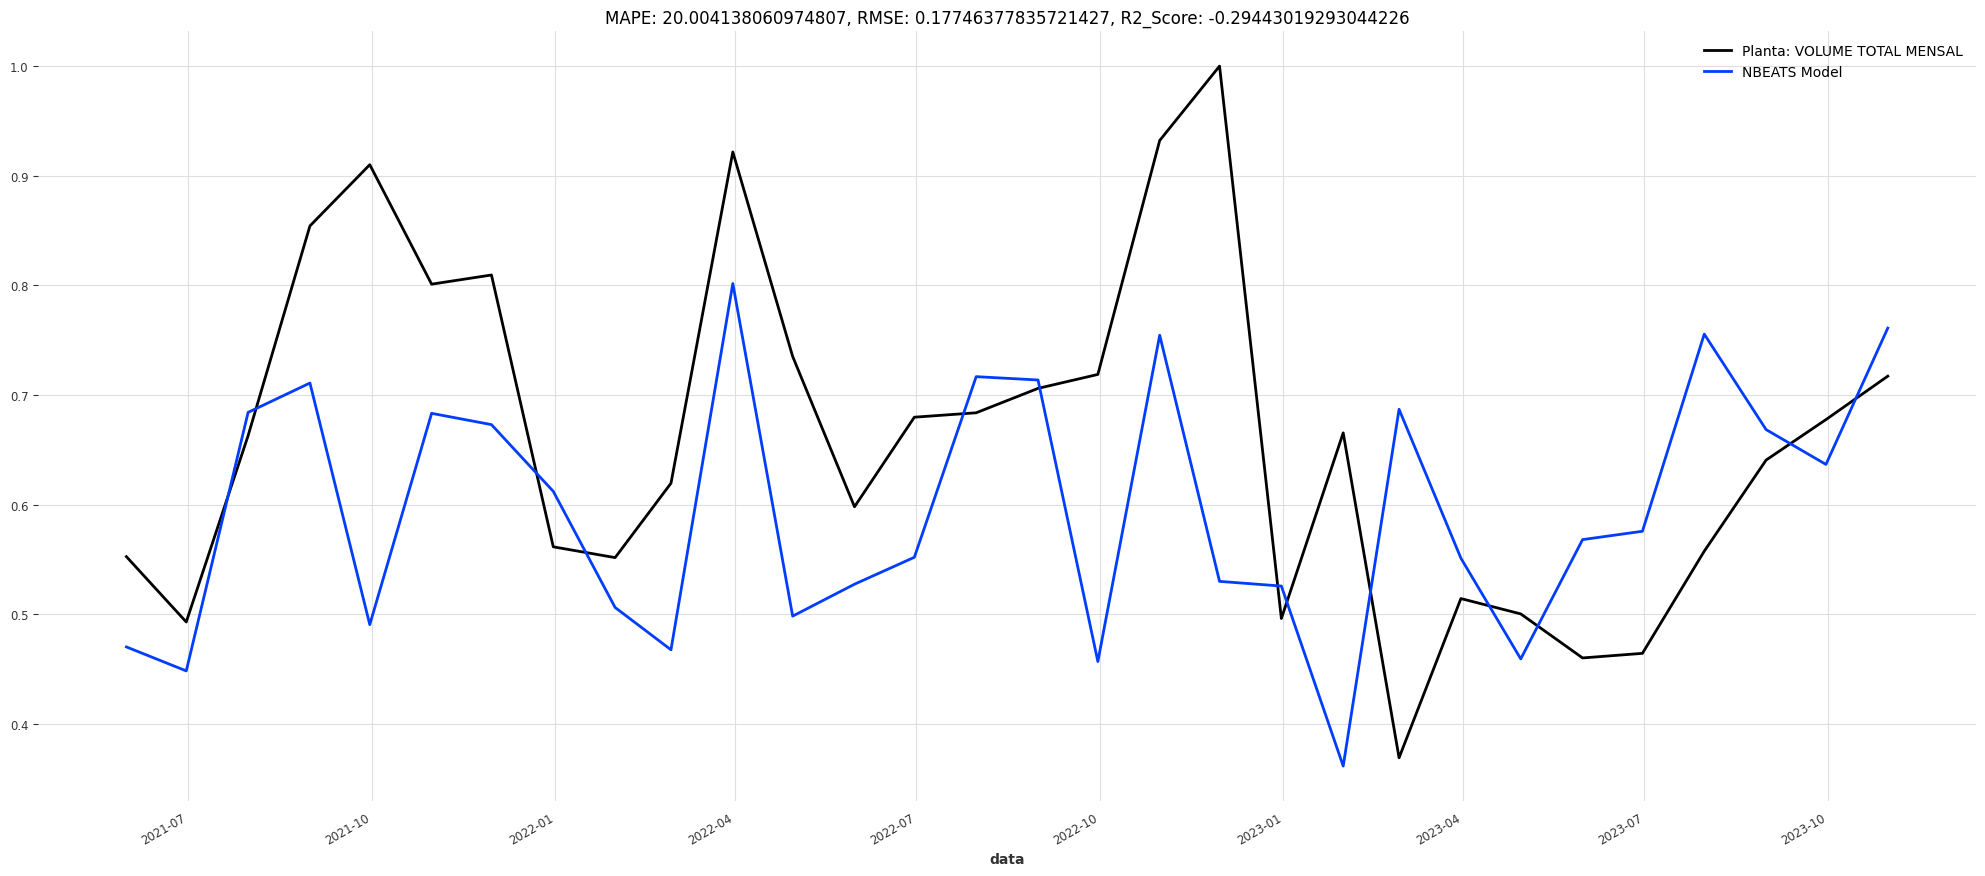

In [ ]:
plot_model(test_m_scaled,
           'VOLUME TOTAL MENSAL',
           pred_nbeats_m,
           'NBEATS Model')

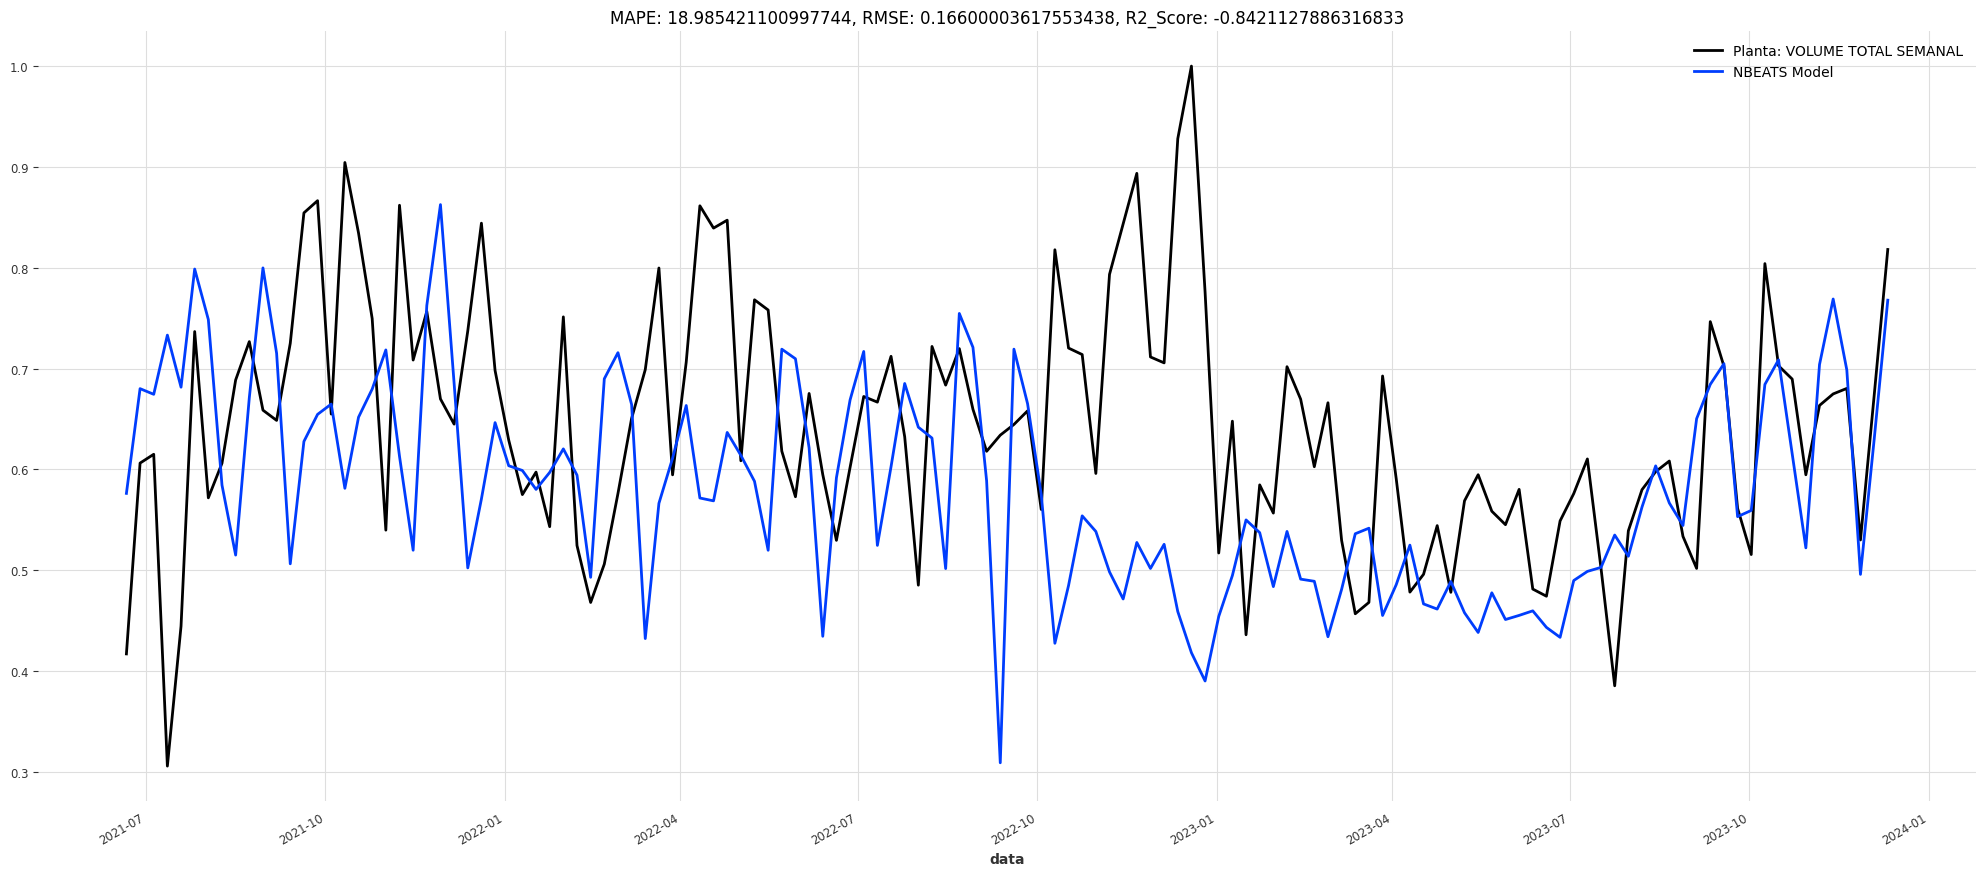

In [ ]:
plot_model(test_w_scaled,
           'VOLUME TOTAL SEMANAL',
           pred_nbeats_w,
           'NBEATS Model')

### TCN

In [ ]:
model_tcn_m = TCNModel(
    input_chunk_length=12,
    output_chunk_length=3,
    n_epochs=500,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=45
)

model_tcn_w = TCNModel(
    input_chunk_length=12,
    output_chunk_length=3,
    n_epochs=500,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=45
)

pred_tcn_m = model_tcn_m.fit(train_m_scaled).predict(len(test_m_scaled))
pred_tcn_w = model_tcn_w.fit(train_w_scaled).predict(len(test_w_scaled))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | res_blocks    | ModuleList       | 150   
---------------------------------------------------
150       Trainable params
0         Non-trainable params
150       Total params
0.001     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | res_blocks    | ModuleList       | 150   
---------------------------------------------------
150       Trainable params
0         Non-trainable params
150       Total params
0.001     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

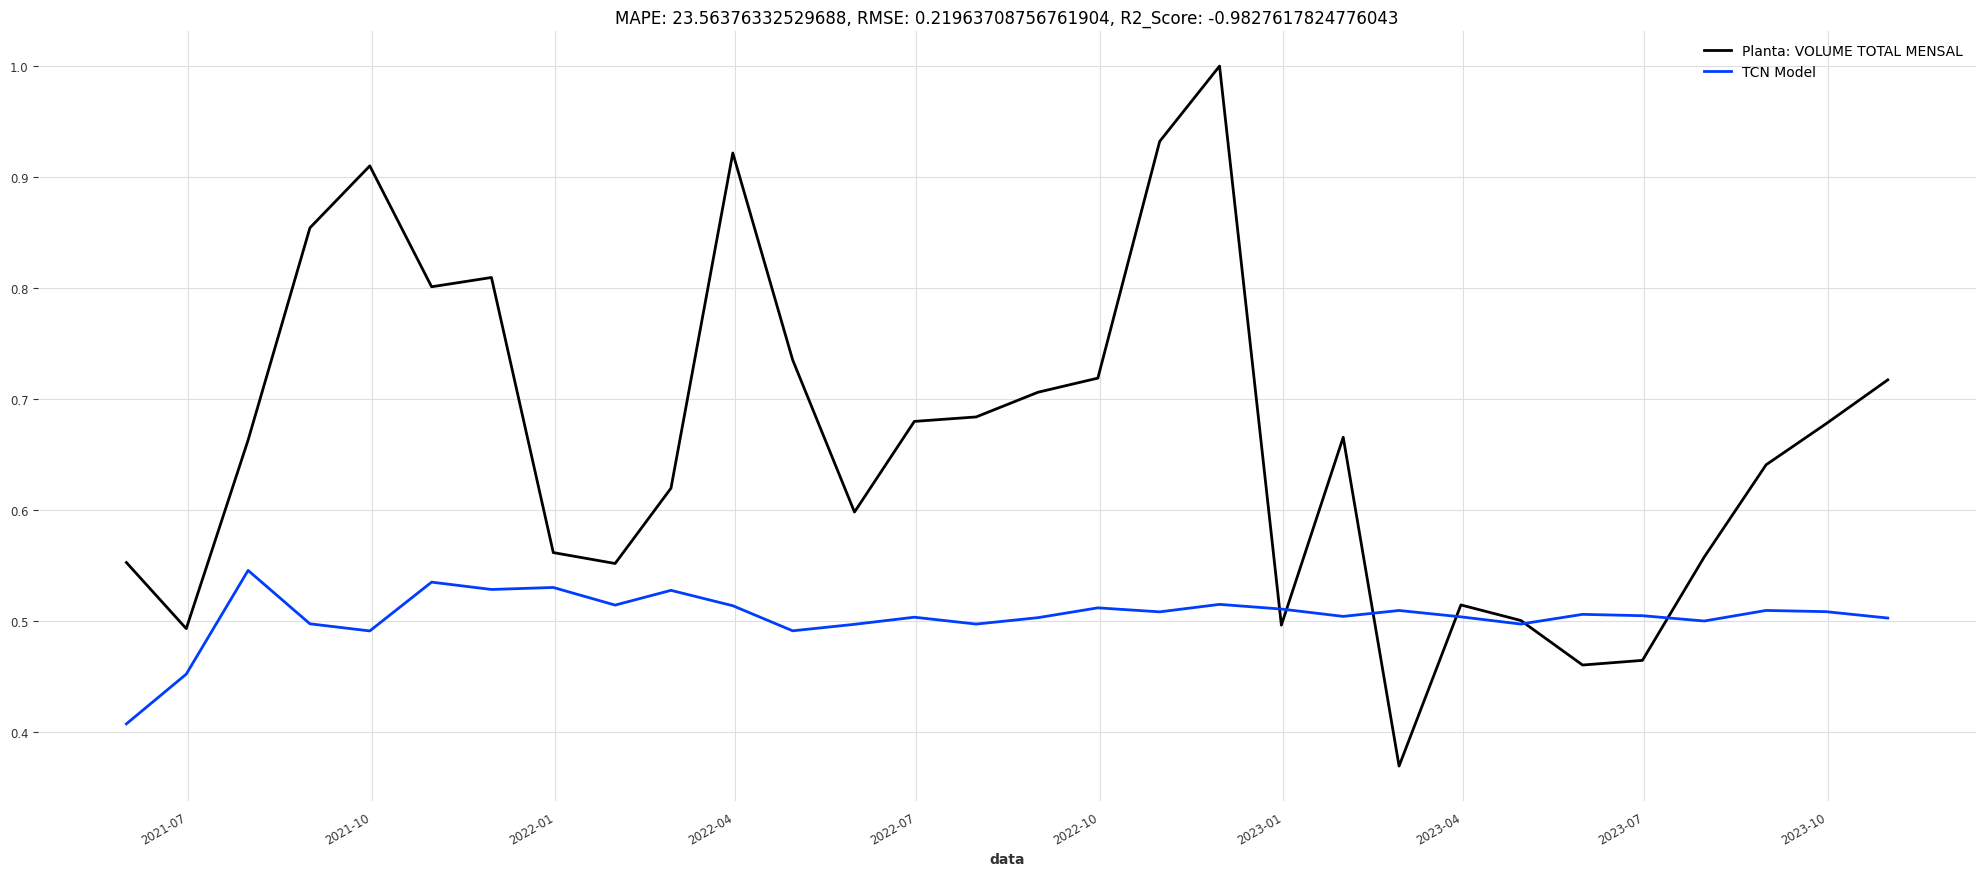

In [ ]:
plot_model(test_m_scaled,
           'VOLUME TOTAL MENSAL',
           pred_tcn_m,
           'TCN Model')

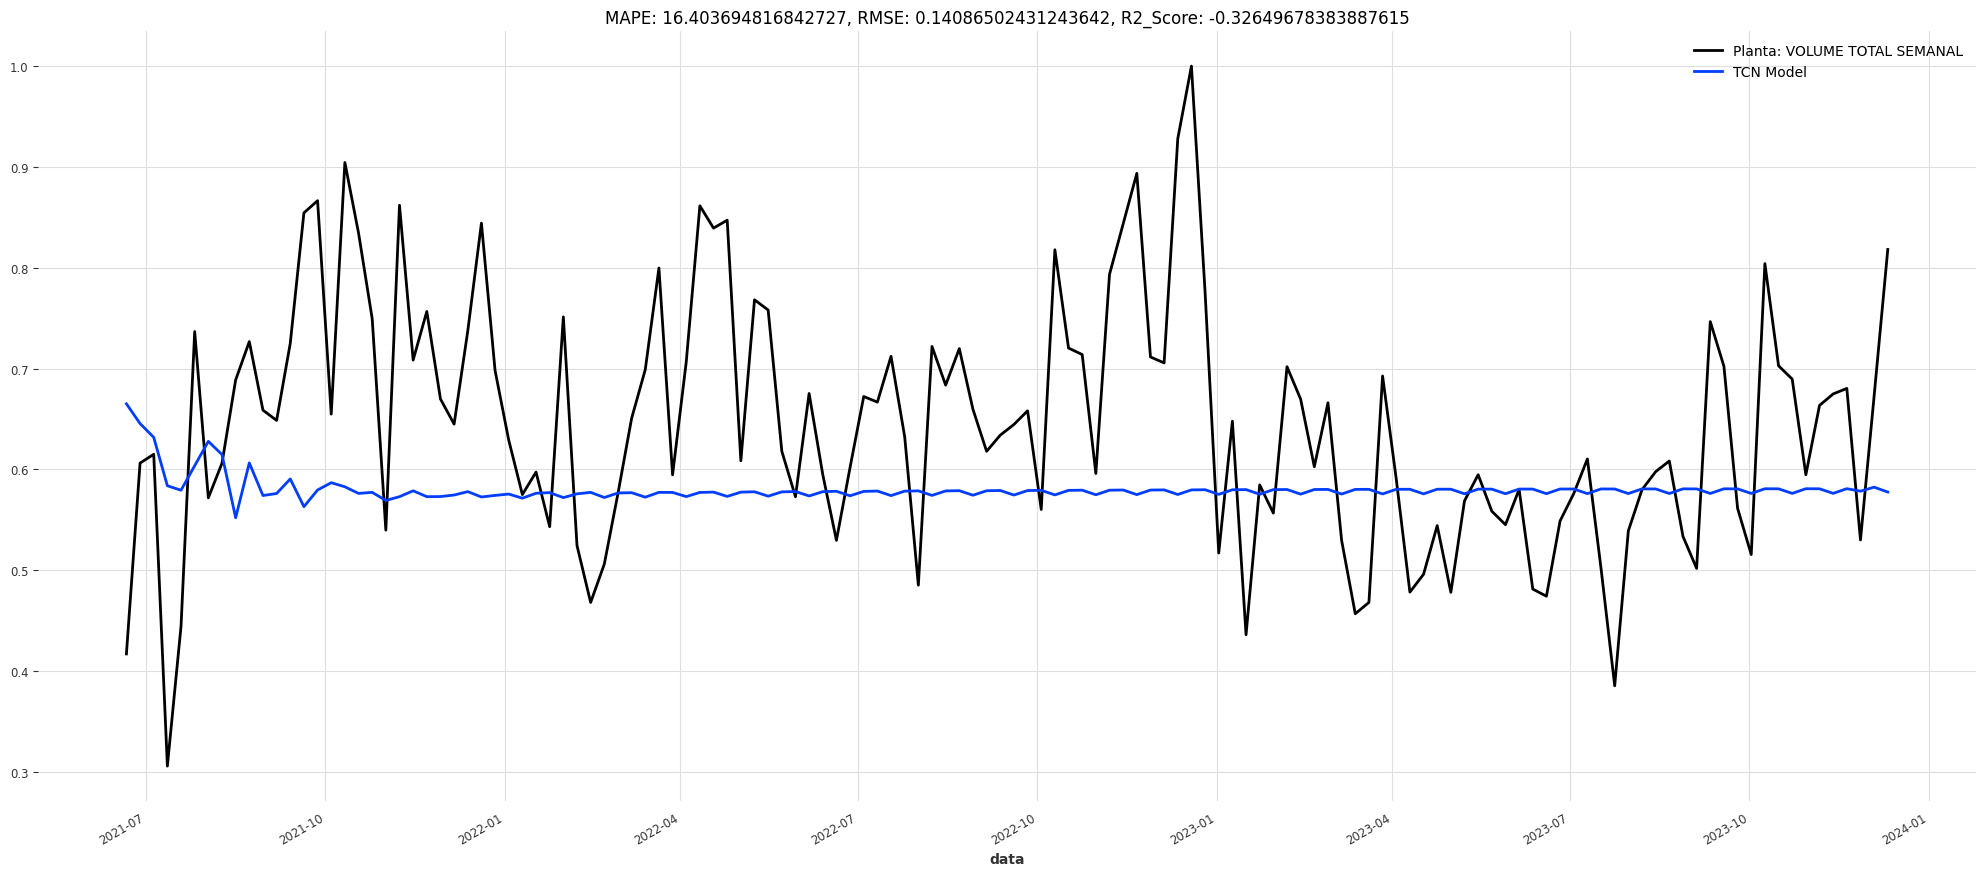

In [ ]:
plot_model(test_w_scaled,
           'VOLUME TOTAL SEMANAL',
           pred_tcn_w,
           'TCN Model')

### NHiTS

In [ ]:
model_rnn_lstm_m = RNNModel(
    input_chunk_length=6,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)


model_rnn_lstm_w = RNNModel(
    input_chunk_length=16,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)

pred_rnn_lstm_m = model_rnn_lstm_m.fit(train_m_scaled).predict(len(test_m_scaled))
pred_rnn_lstm_w = model_rnn_lstm_w.fit(train_w_scaled).predict(len(test_w_scaled))


In [ ]:
plot_model(test_m_scaled,
           'VOLUME TOTAL MENSAL',
           pred_rnn_lstm_m,
           'RNN(LSTM) Model')

In [ ]:
plot_model(test_w_scaled,
           'VOLUME TOTAL SEMANAL',
           pred_rnn_lstm_w,
           'RNN(LSTM) Model')

### Transformer

In [ ]:
model_rnn_lstm_m = RNNModel(
    input_chunk_length=6,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)


model_rnn_lstm_w = RNNModel(
    input_chunk_length=16,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)

pred_rnn_lstm_m = model_rnn_lstm_m.fit(train_m_scaled).predict(len(test_m_scaled))
pred_rnn_lstm_w = model_rnn_lstm_w.fit(train_w_scaled).predict(len(test_w_scaled))

In [ ]:
plot_model(test_m_scaled,
           'VOLUME TOTAL MENSAL',
           pred_rnn_lstm_m,
           'RNN(LSTM) Model')

In [ ]:
plot_model(test_w_scaled,
           'VOLUME TOTAL SEMANAL',
           pred_rnn_lstm_w,
           'RNN(LSTM) Model')

### TFT

In [ ]:
model_rnn_lstm_m = RNNModel(
    input_chunk_length=6,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)


model_rnn_lstm_w = RNNModel(
    input_chunk_length=16,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)

pred_rnn_lstm_m = model_rnn_lstm_m.fit(train_m_scaled).predict(len(test_m_scaled))
pred_rnn_lstm_w = model_rnn_lstm_w.fit(train_w_scaled).predict(len(test_w_scaled))

In [ ]:
plot_model(test_m_scaled,
           'VOLUME TOTAL MENSAL',
           pred_rnn_lstm_m,
           'RNN(LSTM) Model')

In [ ]:
plot_model(test_w_scaled,
           'VOLUME TOTAL SEMANAL',
           pred_rnn_lstm_w,
           'RNN(LSTM) Model')

### Dlinear

In [ ]:
model_rnn_lstm_m = RNNModel(
    input_chunk_length=6,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)


model_rnn_lstm_w = RNNModel(
    input_chunk_length=16,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)

pred_rnn_lstm_m = model_rnn_lstm_m.fit(train_m_scaled).predict(len(test_m_scaled))
pred_rnn_lstm_w = model_rnn_lstm_w.fit(train_w_scaled).predict(len(test_w_scaled))

In [ ]:
plot_model(test_m_scaled,
           'VOLUME TOTAL MENSAL',
           pred_rnn_lstm_m,
           'RNN(LSTM) Model')

In [ ]:
plot_model(test_w_scaled,
           'VOLUME TOTAL SEMANAL',
           pred_rnn_lstm_w,
           'RNN(LSTM) Model')

### Nlinear

In [ ]:
model_rnn_lstm_m = RNNModel(
    input_chunk_length=6,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)


model_rnn_lstm_w = RNNModel(
    input_chunk_length=16,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)

pred_rnn_lstm_m = model_rnn_lstm_m.fit(train_m_scaled).predict(len(test_m_scaled))
pred_rnn_lstm_w = model_rnn_lstm_w.fit(train_w_scaled).predict(len(test_w_scaled))

In [ ]:
plot_model(test_m_scaled,
           'VOLUME TOTAL MENSAL',
           pred_rnn_lstm_m,
           'RNN(LSTM) Model')

In [ ]:
plot_model(test_w_scaled,
           'VOLUME TOTAL SEMANAL',
           pred_rnn_lstm_w,
           'RNN(LSTM) Model')

### TiDE

In [ ]:
model_rnn_lstm_m = RNNModel(
    input_chunk_length=6,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)


model_rnn_lstm_w = RNNModel(
    input_chunk_length=16,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)

pred_rnn_lstm_m = model_rnn_lstm_m.fit(train_m_scaled).predict(len(test_m_scaled))
pred_rnn_lstm_w = model_rnn_lstm_w.fit(train_w_scaled).predict(len(test_w_scaled))

In [ ]:
plot_model(test_m_scaled,
           'VOLUME TOTAL MENSAL',
           pred_rnn_lstm_m,
           'RNN(LSTM) Model')

In [ ]:
plot_model(test_w_scaled,
           'VOLUME TOTAL SEMANAL',
           pred_rnn_lstm_w,
           'RNN(LSTM) Model')

### TSMixerModel

In [ ]:
model_rnn_lstm_m = RNNModel(
    input_chunk_length=6,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)


model_rnn_lstm_w = RNNModel(
    input_chunk_length=16,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)

pred_rnn_lstm_m = model_rnn_lstm_m.fit(train_m_scaled).predict(len(test_m_scaled))
pred_rnn_lstm_w = model_rnn_lstm_w.fit(train_w_scaled).predict(len(test_w_scaled))

In [ ]:
plot_model(test_m_scaled,
           'VOLUME TOTAL MENSAL',
           pred_rnn_lstm_m,
           'RNN(LSTM) Model')

In [ ]:
plot_model(test_w_scaled,
           'VOLUME TOTAL SEMANAL',
           pred_rnn_lstm_w,
           'RNN(LSTM) Model')

### RNN

In [ ]:
model_rnn_lstm_m = RNNModel(
    input_chunk_length=6,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)


model_rnn_lstm_w = RNNModel(
    input_chunk_length=16,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)

pred_rnn_lstm_m = model_rnn_lstm_m.fit(train_m_scaled).predict(len(test_m_scaled))
pred_rnn_lstm_w = model_rnn_lstm_w.fit(train_w_scaled).predict(len(test_w_scaled))

In [ ]:
plot_model(test_m_scaled,
           'VOLUME TOTAL MENSAL',
           pred_rnn_lstm_m,
           'RNN(LSTM) Model')

In [ ]:
plot_model(test_w_scaled,
           'VOLUME TOTAL SEMANAL',
           pred_rnn_lstm_w,
           'RNN(LSTM) Model')

### BlockRNN

In [ ]:
model_rnn_lstm_m = RNNModel(
    input_chunk_length=6,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)


model_rnn_lstm_w = RNNModel(
    input_chunk_length=16,
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    training_length=18,
    batch_size=16,
    n_epochs=300,
)

pred_rnn_lstm_m = model_rnn_lstm_m.fit(train_m_scaled).predict(len(test_m_scaled))
pred_rnn_lstm_w = model_rnn_lstm_w.fit(train_w_scaled).predict(len(test_w_scaled))

In [ ]:
plot_model(test_m_scaled,
           'VOLUME TOTAL MENSAL',
           pred_rnn_lstm_m,
           'RNN(LSTM) Model')

In [ ]:
plot_model(test_w_scaled,
           'VOLUME TOTAL SEMANAL',
           pred_rnn_lstm_w,
           'RNN(LSTM) Model')